In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import Column, DataFrameReader
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import DateType, TimestampType, StringType, DoubleType, IntegerType, FloatType, LongType, StructType, StructField
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import geobr
import numpy as np
import squarify
from numerize import numerize
import requests
requests.packages.urllib3.disable_warnings()
import json
from urllib.request import urlopen

**<h1>Iniciar a sessão e importar o dataset</h1>**

Iniciar sessão spark

In [2]:
spark = SparkSession.builder \
  .appName('siasus') \
  .getOrCreate()

In [3]:
# Alterar o log settings
sc.setLogLevel('ERROR')

In [4]:
# Aumentar o número de caracteres das strings
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

Path do arquivo com a população brasileira e abrir arquivo

In [5]:
df_pop_br = spark.read.csv("brasil.csv", header=True)

In [6]:
# Transformar em data e integer as colunas
df_pop_br = df_pop_br.withColumn('ano', F.year(to_date(df_pop_br.ano, 'yyyy')))
df_pop_br = df_pop_br.withColumn('populacao', F.column('populacao').cast(IntegerType()))

In [7]:
df_pop_br.show()

+----+---------+
| ano|populacao|
+----+---------+
|1991|146815815|
|1992|149236984|
|1993|151571727|
|1994|153725670|
|1995|155822440|
|1996|157070163|
|1997|159636413|
|1998|161790311|
|1999|163947554|
|2000|169872854|
|2001|172385826|
|2002|174632960|
|2003|176871437|
|2004|181581024|
|2005|184184264|
|2006|186770562|
|2007|184014516|
|2008|189612814|
|2009|191446848|
|2010|190755799|
+----+---------+
only showing top 20 rows



**<h1>Ler o dataset final</h1>**

In [8]:
df_final = spark.read.json("hdfs://127.0.1.1:9000/datasus/siasus-df-final")

In [9]:
df_final.show(5)

+--------------------+----------+----------+--------------------+-----------+----------+--------+---------+-----------+-----------+-----------+----------+-------+--------------------+--------+----------+--------------+------------------+-----------+---------+--------------------+-----------+--------------------+-----+-----+--------------------+------+-----------+-----------------+--------+----------------+---------+---------------+----+
|           AP_CNSPCN|  AP_DTFIM| AP_DTINIC|         AP_DTINIC_L|AP_DTINIC_N|AP_NUIDADE|AP_OBITO|AP_PRIPAL|AP_PRIPAL_C|AP_PRIPAL_N|AP_PRIPAL_S|AP_RACACOR|AP_SEXO|         AP_TPAPAC_L|AP_VL_AP|AP_VL_AP_C|    AP_VL_AP_L|        AP_VL_AP_S|AQ_DTIDEN_Y|AQ_ESTADI|         AQ_ESTADI_L|AQ_ESTADI_N|                 CID|CID_C|CID_N|               CID_S|MESANO|MESANO_LAST|          NOME_UF|N_PROCED|TEMPO_APAC_ATUAL|TEMPO_AUT|TEMP_APAC_TOTAL|Year|
+--------------------+----------+----------+--------------------+-----------+----------+--------+---------+-----------

In [10]:
df_final.count()

3317174

In [11]:
df_final.dtypes

[('AP_CNSPCN', 'string'),
 ('AP_DTFIM', 'string'),
 ('AP_DTINIC', 'string'),
 ('AP_DTINIC_L', 'array<string>'),
 ('AP_DTINIC_N', 'bigint'),
 ('AP_NUIDADE', 'bigint'),
 ('AP_OBITO', 'bigint'),
 ('AP_PRIPAL', 'bigint'),
 ('AP_PRIPAL_C', 'bigint'),
 ('AP_PRIPAL_N', 'bigint'),
 ('AP_PRIPAL_S', 'array<bigint>'),
 ('AP_RACACOR', 'string'),
 ('AP_SEXO', 'string'),
 ('AP_TPAPAC_L', 'array<bigint>'),
 ('AP_VL_AP', 'double'),
 ('AP_VL_AP_C', 'bigint'),
 ('AP_VL_AP_L', 'array<double>'),
 ('AP_VL_AP_S', 'double'),
 ('AQ_DTIDEN_Y', 'bigint'),
 ('AQ_ESTADI', 'string'),
 ('AQ_ESTADI_L', 'array<string>'),
 ('AQ_ESTADI_N', 'bigint'),
 ('CID', 'string'),
 ('CID_C', 'bigint'),
 ('CID_N', 'bigint'),
 ('CID_S', 'array<string>'),
 ('MESANO', 'string'),
 ('MESANO_LAST', 'string'),
 ('NOME_UF', 'string'),
 ('N_PROCED', 'bigint'),
 ('TEMPO_APAC_ATUAL', 'bigint'),
 ('TEMPO_AUT', 'bigint'),
 ('TEMP_APAC_TOTAL', 'bigint'),
 ('Year', 'bigint')]

**<h1>Início das análises</h1>**

**<h2>Número de pacientes por 100000 habitantes por ano</h2>**

In [12]:
# os pacientes unicos por ano foi estabelecido no df_final
# criar a coluna com a contagem agrupando pelo ano
# taxa por 100000 habitantes
df_num_pct = df_final.groupBy("Year", "AP_SEXO").agg(F.count("AP_CNSPCN").alias("N_Atendimentos"))
df_num_pct = df_num_pct.join(df_pop_br, df_num_pct.Year == df_pop_br.ano, 'inner').select("Year", "AP_SEXO", "N_Atendimentos", "populacao")
df_num_pct = df_num_pct.withColumn("Taxa", ( df_num_pct.N_Atendimentos / df_num_pct.populacao ) * 100000 )
df_num_pct.sort("Year").show()

+----+-------+--------------+---------+------------------+
|Year|AP_SEXO|N_Atendimentos|populacao|              Taxa|
+----+-------+--------------+---------+------------------+
|2015|      M|        173944|204450049| 85.07897202802823|
|2015|      F|        251016|204450049|122.77619948137064|
|2016|      M|        176601|206081432| 85.69476555267725|
|2016|      F|        256268|206081432|124.35278497094295|
|2017|      F|        270651|207660929| 130.3331355124584|
|2017|      M|        183864|207660929| 88.54048803759325|
|2018|      M|        189422|208494900| 90.85210237756415|
|2018|      F|        283083|208494900|135.77454412553976|
|2019|      F|        299261|210147125|142.40546950142667|
|2019|      M|        200337|210147125|  95.3317824357578|
|2020|      M|        200700|211755692| 94.77903432225095|
|2020|      F|        307296|211755692|145.11817703582673|
|2021|      M|        204100|213317639| 95.67891382859342|
|2021|      F|        320631|213317639|150.3068389013999

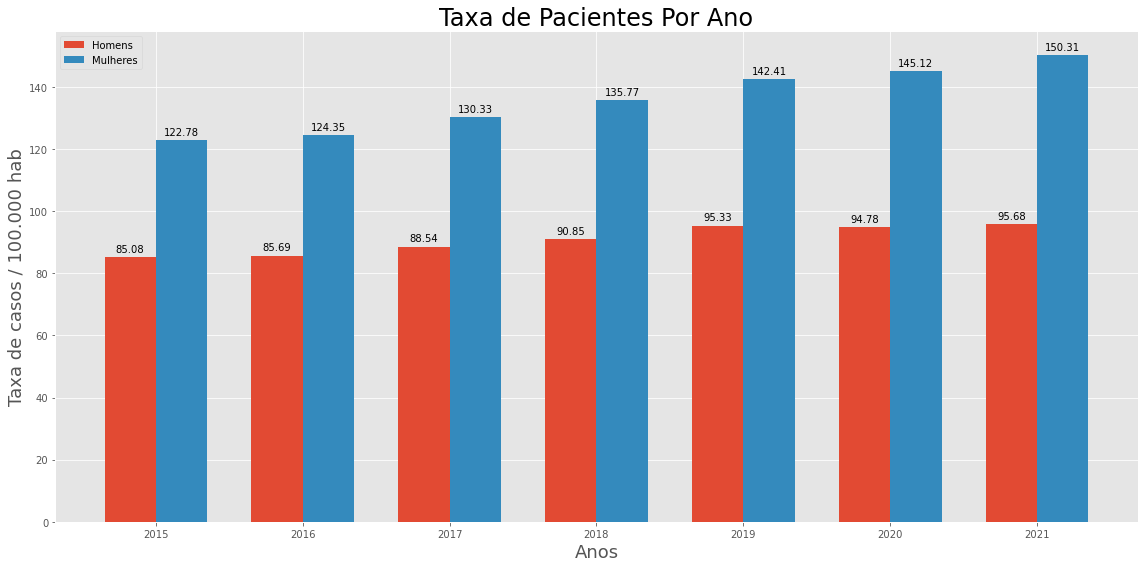

In [13]:
# Grafico da taxa de pacientes por 100000 habitantes por ano
df_graph = df_num_pct.filter(df_num_pct.Year > 2014).sort("Year").toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].Taxa
women = df_graph[df_graph.AP_SEXO == "F"].Taxa

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Taxa de casos / 100.000 hab', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Taxa de Pacientes Por Ano', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Número de pacientes por 100000 habitantes por CID por ano</h2>**

In [14]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pelo cid
df_num_pct_cid = df_final.groupBy("Year", "CID", "AP_SEXO").agg(F.count("AP_CNSPCN").alias("N_Atendimentos"))
df_num_pct_cid = df_num_pct_cid.join(df_pop_br, df_num_pct_cid.Year == df_pop_br.ano, 'inner').select("Year", "CID", "AP_SEXO", "N_Atendimentos", "populacao")
df_num_pct_cid = df_num_pct_cid.withColumn("Taxa", ( df_num_pct_cid.N_Atendimentos / df_num_pct_cid.populacao ) * 100000 )
df_num_pct_cid.sort("Year").show()

+----+--------------------+-------+--------------+---------+--------------------+
|Year|                 CID|AP_SEXO|N_Atendimentos|populacao|                Taxa|
+----+--------------------+-------+--------------+---------+--------------------+
|2014|              Cabeça|      F|           402|202768562| 0.19825558559714007|
|2014|Comportamento inc...|      M|          1942|202768562|  0.9577421572876766|
|2014|               Torax|      M|          1961|202768562|  0.9671124461591831|
|2014|                Pele|      F|           240|202768562| 0.11836154364008362|
|2014|Comportamento inc...|      F|          2935|202768562|  1.4474630440985226|
|2014|      Não específico|      M|           920|202768562|  0.4537192506203205|
|2014|           Endocrino|      M|            80|202768562| 0.03945384788002787|
|2014|           Digestivo|      F|          5380|202768562|  2.6532712699318743|
|2014|       Tecidos moles|      F|           518|202768562| 0.25546366502318046|
|2014|     Siste

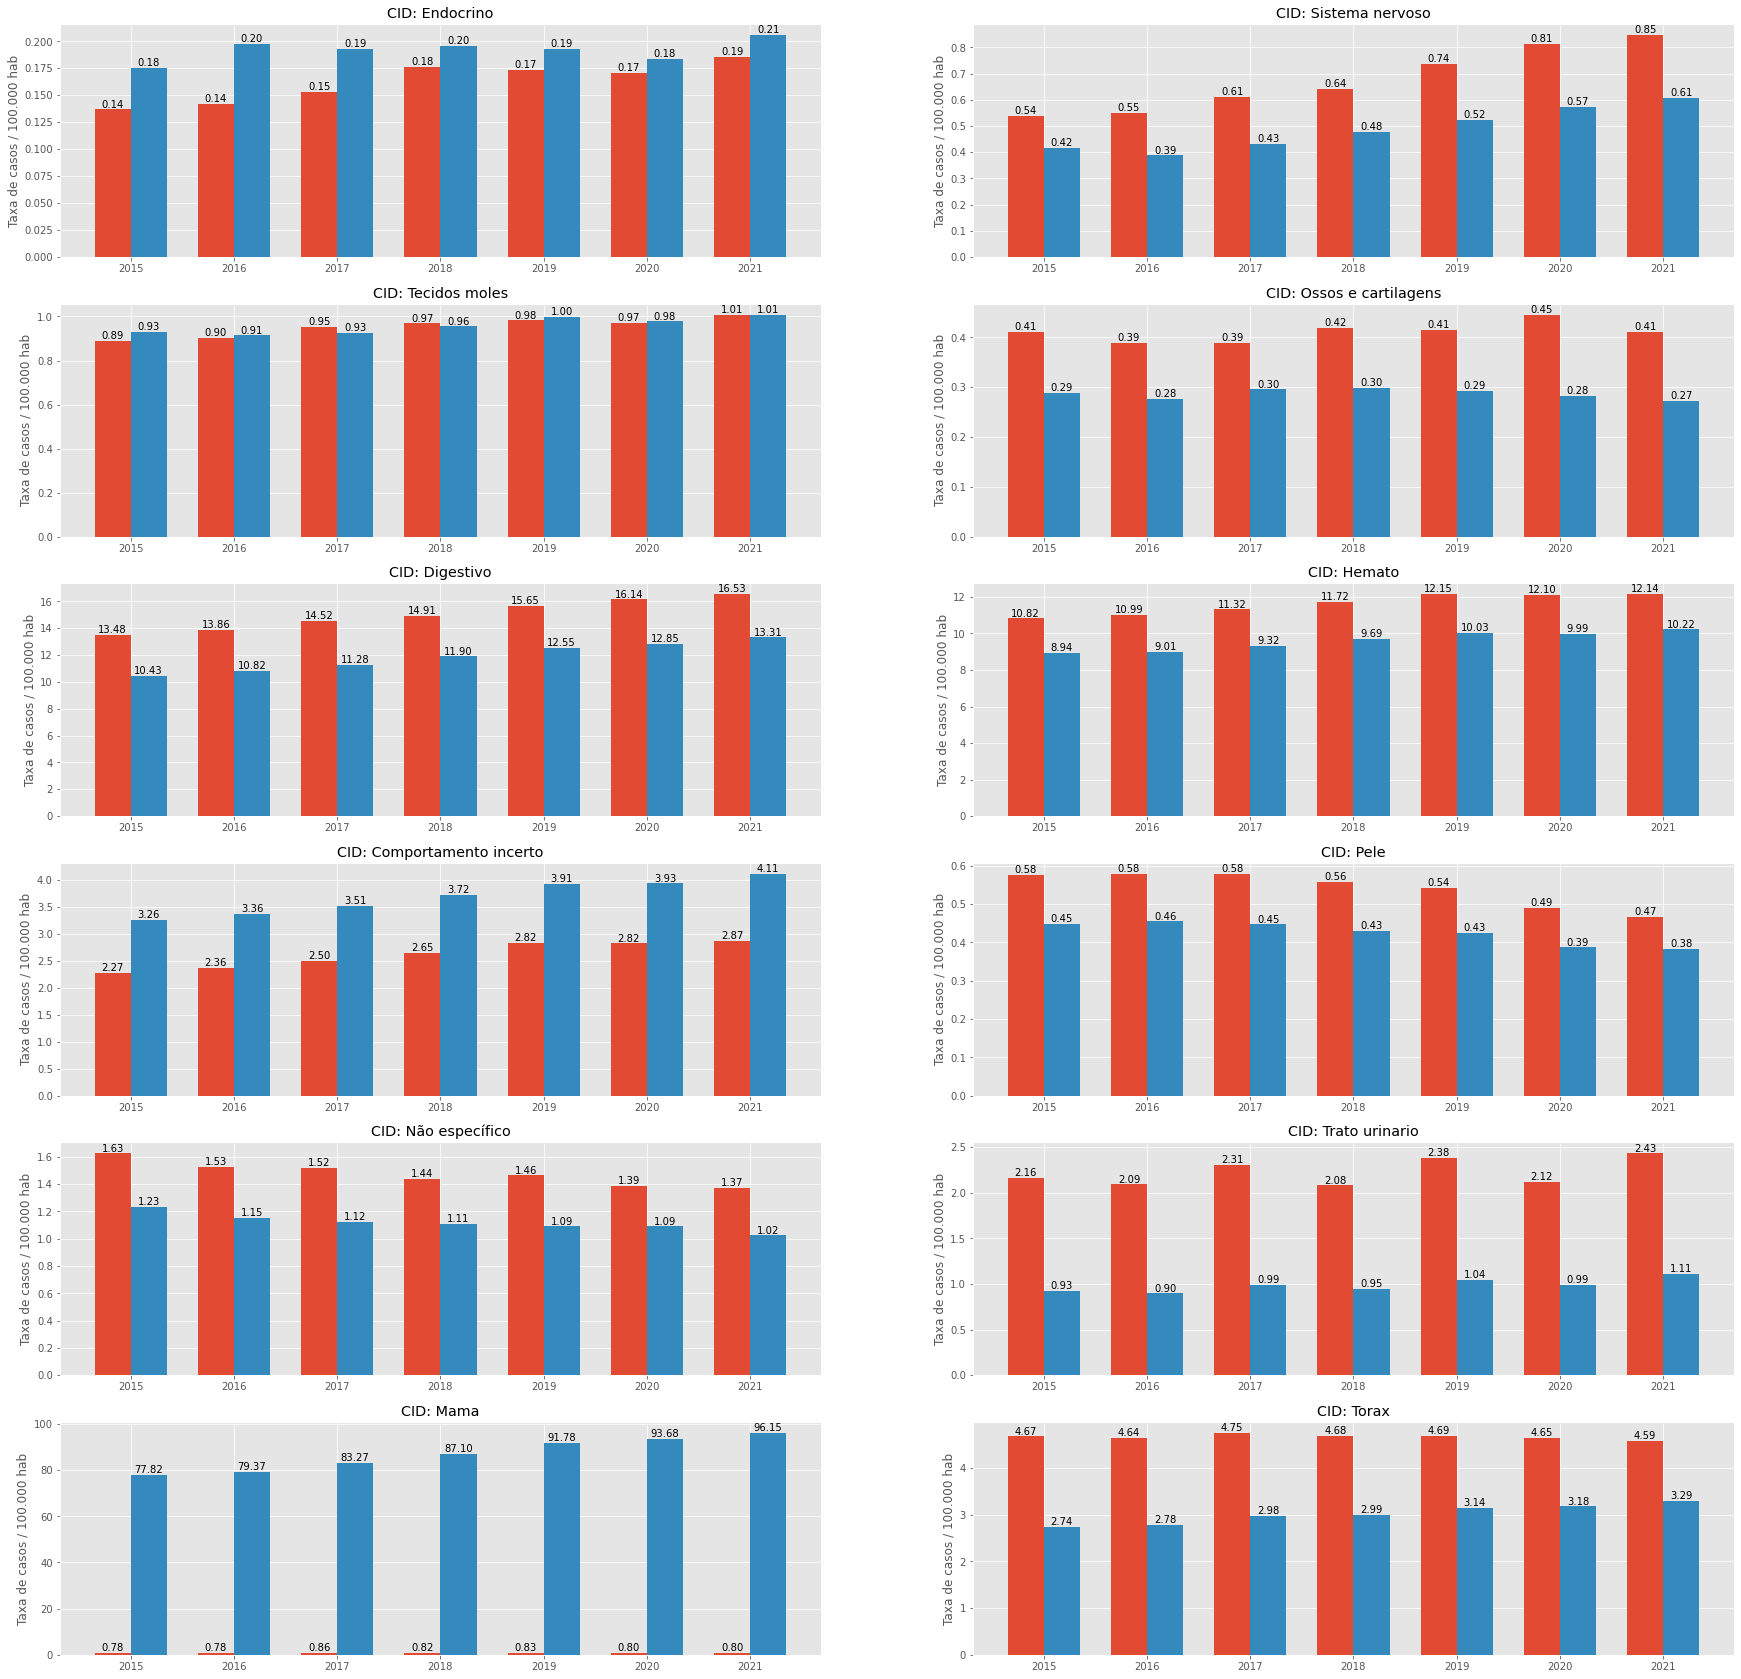

In [15]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pelo cid por ano
df_graph = df_num_pct_cid.filter(df_num_pct_cid.Year > 2014).sort("Year").toPandas()
cids = ['Endocrino', 'Sistema nervoso', 'Tecidos moles',
       'Ossos e cartilagens', 'Digestivo', 'Hemato',
       'Comportamento incerto', 'Pele', 'Não específico',
       'Trato urinario', 'Mama', 'Torax', 'Cabeça']
#df_graph.CID.unique()

plt.style.use("ggplot")
fig, axs = plt.subplots(6, 2, figsize=(30, 30))

for cid, ax in zip(cids, axs.ravel()):
    df = df_graph[df_graph["CID"] == cid]
    men = df[df.AP_SEXO == "M"]
    women = df[df.AP_SEXO == "F"]
    labels = df.Year.unique()
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, men.Taxa, width, label="Homens")
    rects2 = ax.bar(x + width/2, women.Taxa, width, label="Mulheres")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Taxa de casos / 100.000 hab')
    ax.set_title(f"CID: {cid}")
    ax.bar_label(rects1, fmt='%.2f')
    ax.bar_label(rects2, fmt='%.2f')

plt.show()

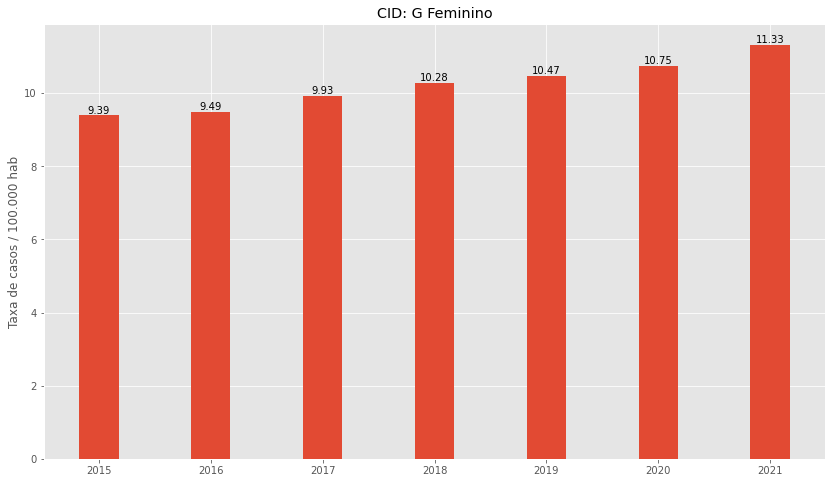

In [16]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pelo cid G Feminino por ano
df_graph = df_num_pct_cid.filter(df_num_pct_cid.Year > 2014).sort("Year").toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Feminino"]
women = df[df.AP_SEXO == "F"]
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women.Taxa, width)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Feminino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

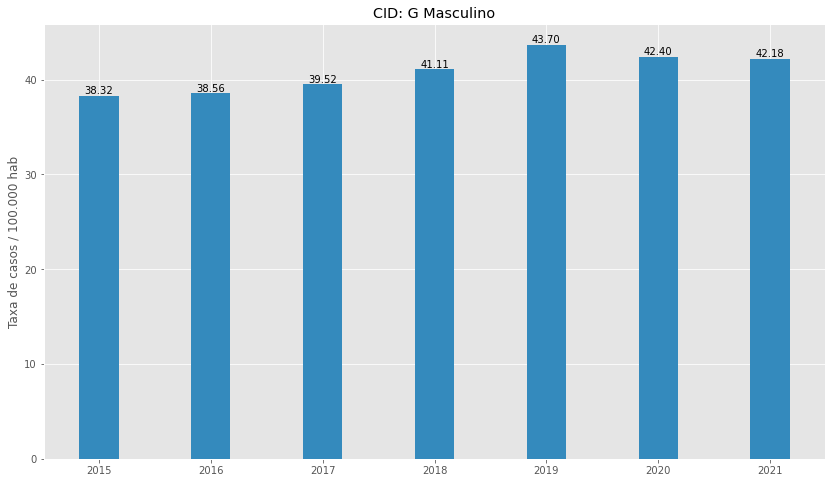

In [17]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pelo cid G Masculino por ano
df_graph = df_num_pct_cid.filter(df_num_pct_cid.Year > 2014).sort("Year").toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Masculino"]
women = df[df.AP_SEXO == "M"]
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women.Taxa, width, color="#348ABD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Masculino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

**<h2>Número de pacientes por 100000 habitantes por raça por ano</h2>**

In [17]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça
df_raca_pct = df_final.groupBy("Year", "AP_RACACOR").agg(F.count("AP_CNSPCN").alias("N_Raca"))
df_raca_pct = df_raca_pct.join(df_pop_br, df_raca_pct.Year == df_pop_br.ano, 'inner').select("Year", "AP_RACACOR", "N_Raca", "populacao")
df_raca_pct = df_raca_pct.withColumn("Taxa", ( df_raca_pct.N_Raca / df_raca_pct.populacao ) * 100000 )
df_raca_pct.sort("Year").show(50)

+----+----------+------+---------+--------------------+
|Year|AP_RACACOR|N_Raca|populacao|                Taxa|
+----+----------+------+---------+--------------------+
|2015|    Branca|210593|204450049|  103.00462192601383|
|2015|   Amarela|  7364|204450049|   3.601857781897621|
|2015|     Preta| 20027|204450049|   9.795546686320433|
|2015|     Parda|112556|204450049|  55.053056015653006|
|2015|  Indígena|    68|204450049| 0.03325995779047233|
|2015|        NA| 74352|204450049|  36.366829141723514|
|2016|     Preta| 20943|206081432|  10.162487613148961|
|2016|   Amarela|  8616|206081432|  4.1808715692542355|
|2016|        NA| 67760|206081432|   32.88020630601984|
|2016|    Branca|213872|206081432|  103.78033475621424|
|2016|     Parda|121616|206081432|   59.01356508431094|
|2016|  Indígena|    62|206081432|0.030085194671978017|
|2017|        NA| 70637|207660929|   34.01554656437081|
|2017|  Indígena|    86|207660929| 0.04141366429117727|
|2017|    Branca|220819|207660929|  106.33632482

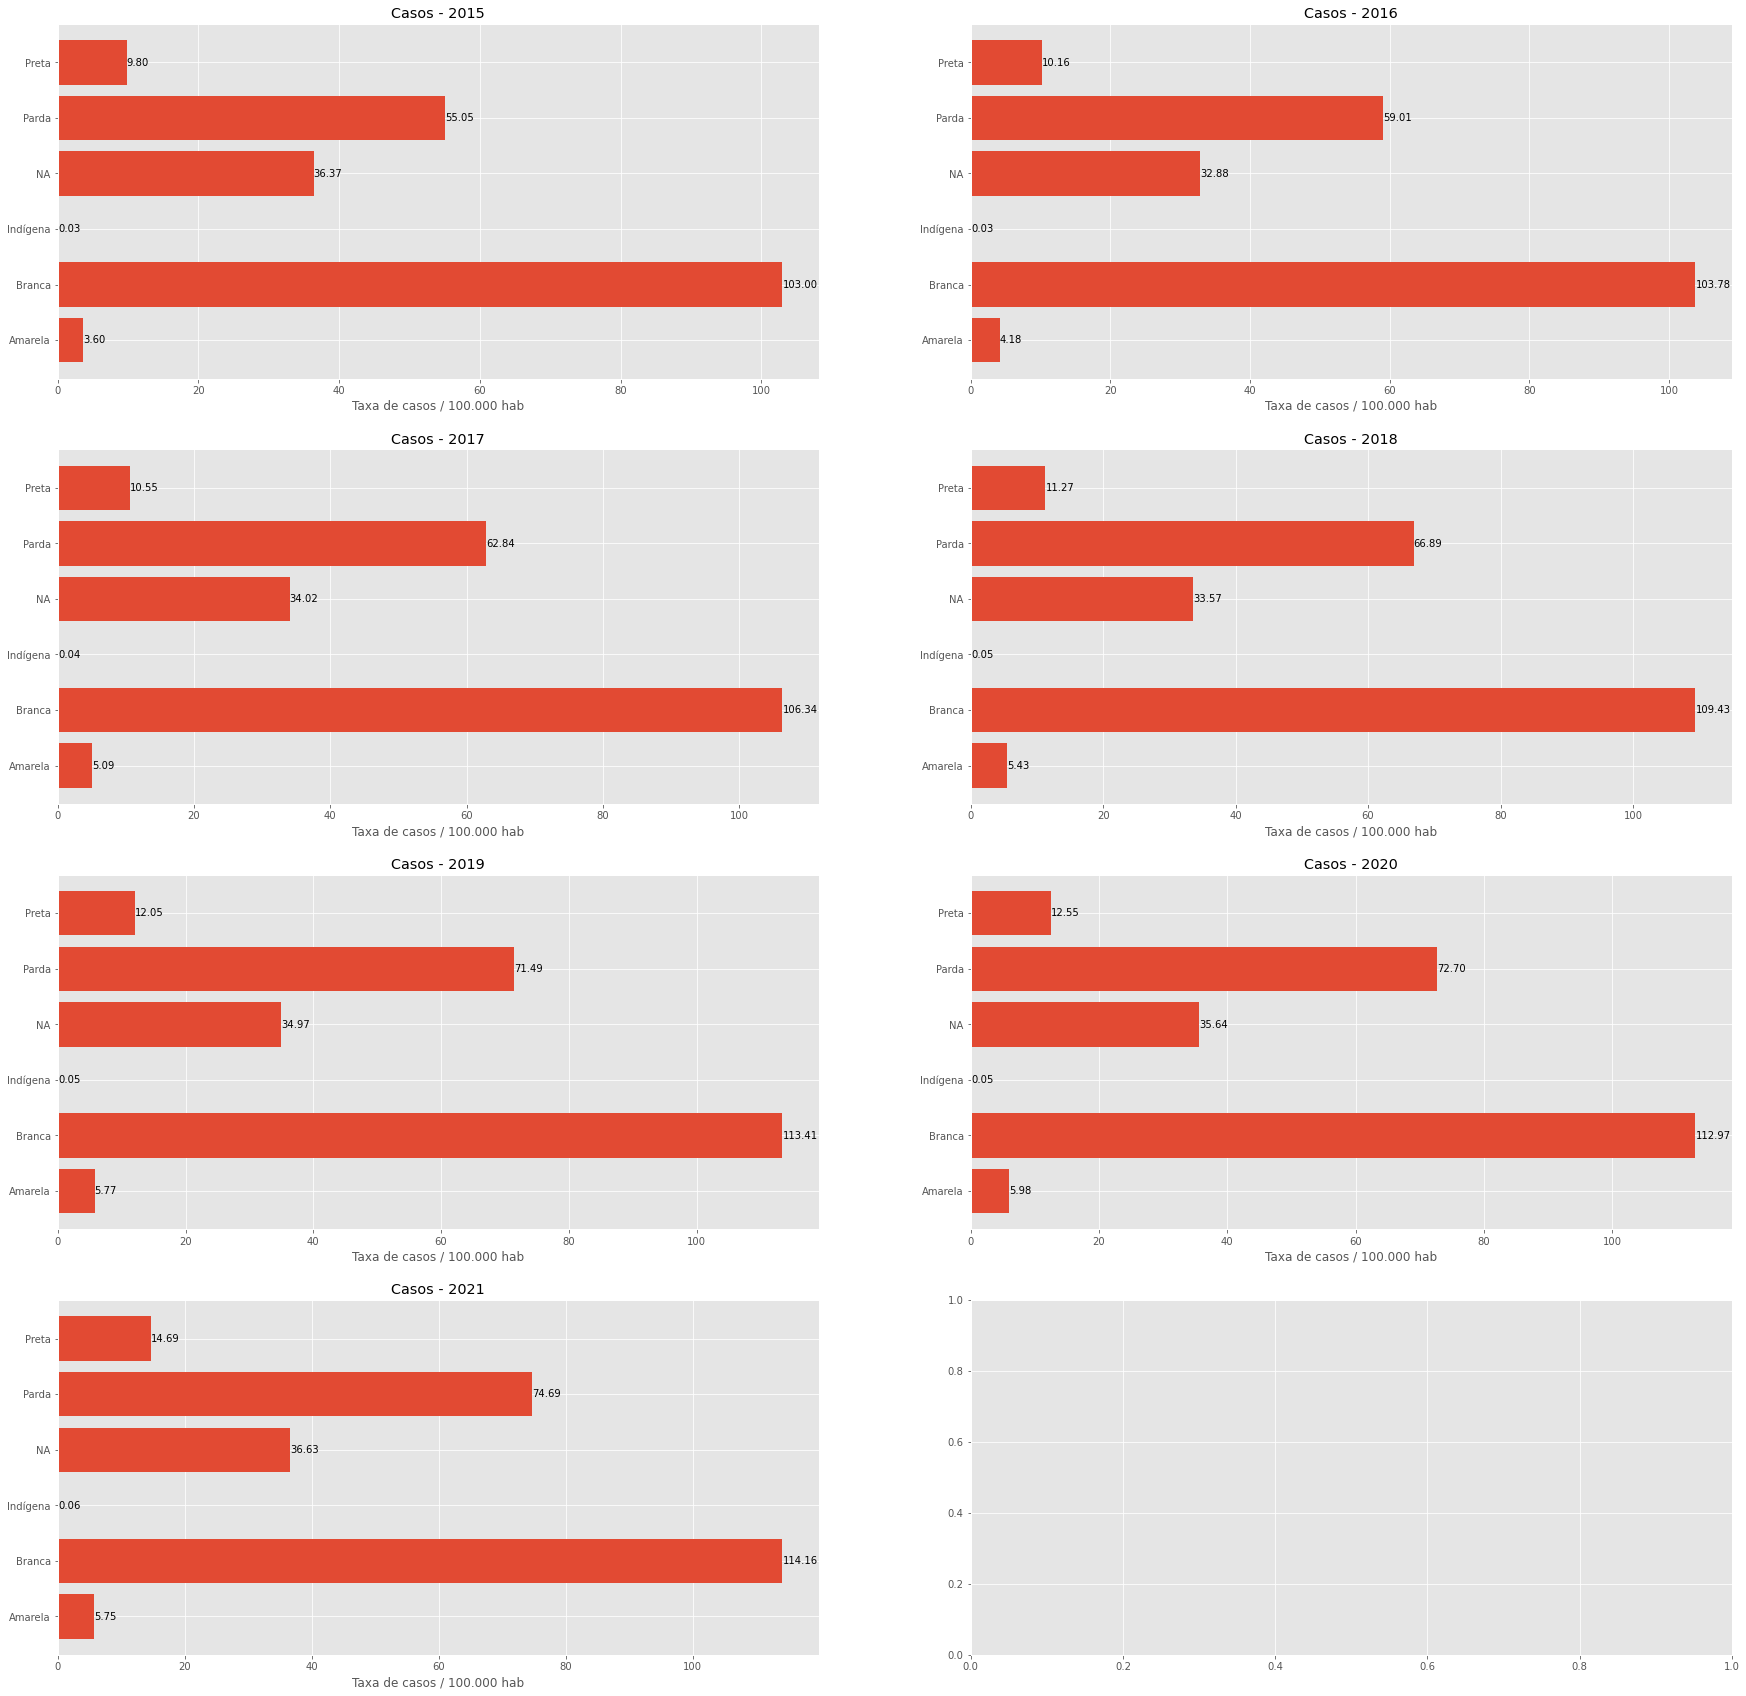

In [16]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça por ano
df_graph = df_raca_pct.filter(df_raca_pct.Year > 2014).sort("AP_RACACOR").toPandas()
years = df_graph.sort_values("Year").Year.unique()

plt.style.use("ggplot")
fig, axs = plt.subplots(4, 2, figsize=(30, 30))

for year, ax in zip(years, axs.ravel()):
    df = df_graph[df_graph["Year"] == year]
    y_pos = df.AP_RACACOR
    y = np.arange(len(y_pos))
    x_pos = df.Taxa
    barhs = ax.barh(y, x_pos, align='center')
    ax.set_yticks(y)
    ax.set_yticklabels(y_pos)
    ax.set_xlabel('Taxa de casos / 100.000 hab')
    ax.set_title(f"Casos - {year}")
    ax.bar_label(barhs, fmt='%.2f')

plt.show()

**<h2>Número de pacientes por 100000 habitantes por raça por CID por ano</h2>**

In [20]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça e pelo cid por ano
df_raca_cid_pct = df_final.groupBy("Year", "CID", "AP_RACACOR").agg(F.count("AP_CNSPCN").alias("N_Raca"))
df_raca_cid_pct = df_raca_cid_pct.join(df_pop_br, df_raca_cid_pct.Year == df_pop_br.ano, 'inner').select("Year", "CID", "AP_RACACOR", "N_Raca", "populacao")
df_raca_cid_pct = df_raca_cid_pct.withColumn("Taxa", ( df_raca_cid_pct.N_Raca / df_raca_cid_pct.populacao ) * 100000 )
df_raca_cid_pct.sort("Year").show()

+----+--------------------+----------+------+---------+--------------------+
|Year|                 CID|AP_RACACOR|N_Raca|populacao|                Taxa|
+----+--------------------+----------+------+---------+--------------------+
|2014|Comportamento inc...|     Parda|   951|202768562| 0.46900761667383134|
|2014|      Não específico|        NA|   329|202768562|  0.1622539494066146|
|2014|                Pele|        NA|    78|202768562| 0.03846750168302718|
|2014|                Pele|     Preta|     7|202768562|0.003452211689502...|
|2014| Ossos e cartilagens|   Amarela|    22|202768562|0.010849808167007665|
|2014|              Hemato|   Amarela|   268|202768562| 0.13217039039809336|
|2014|         G Masculino|     Preta|  2359|202768562|  1.1633953393623218|
|2014|              Cabeça|     Preta|    86|202768562| 0.04241288647102996|
|2014|      Não específico|     Parda|   378|202768562|  0.1864194312331317|
|2014|       Tecidos moles|    Branca|   475|202768562| 0.23425722178766548|

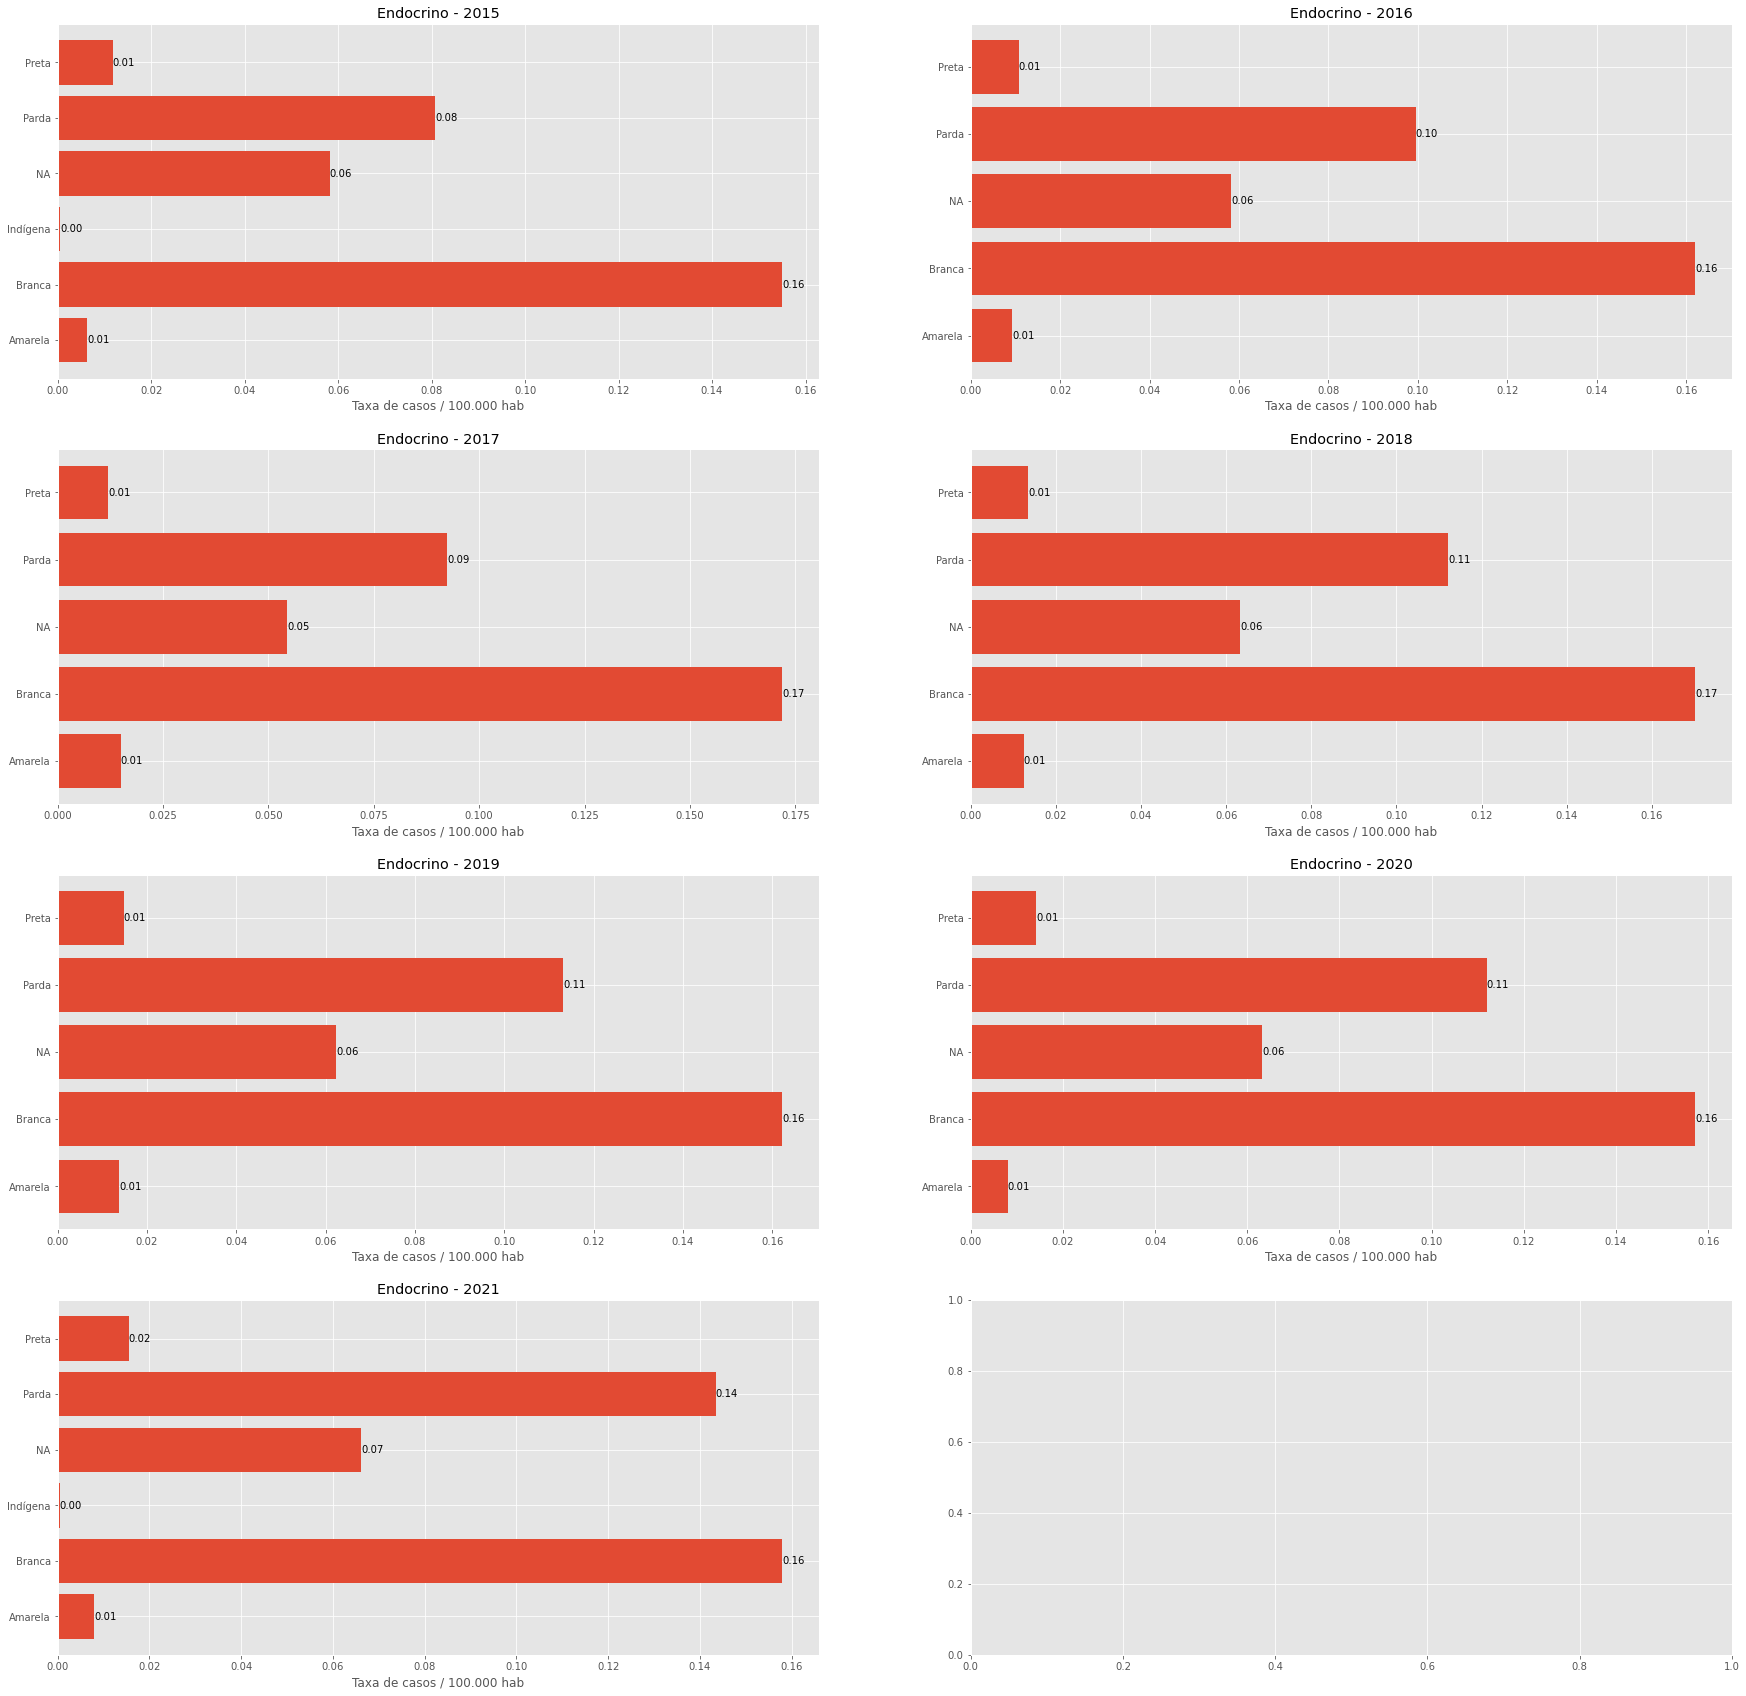

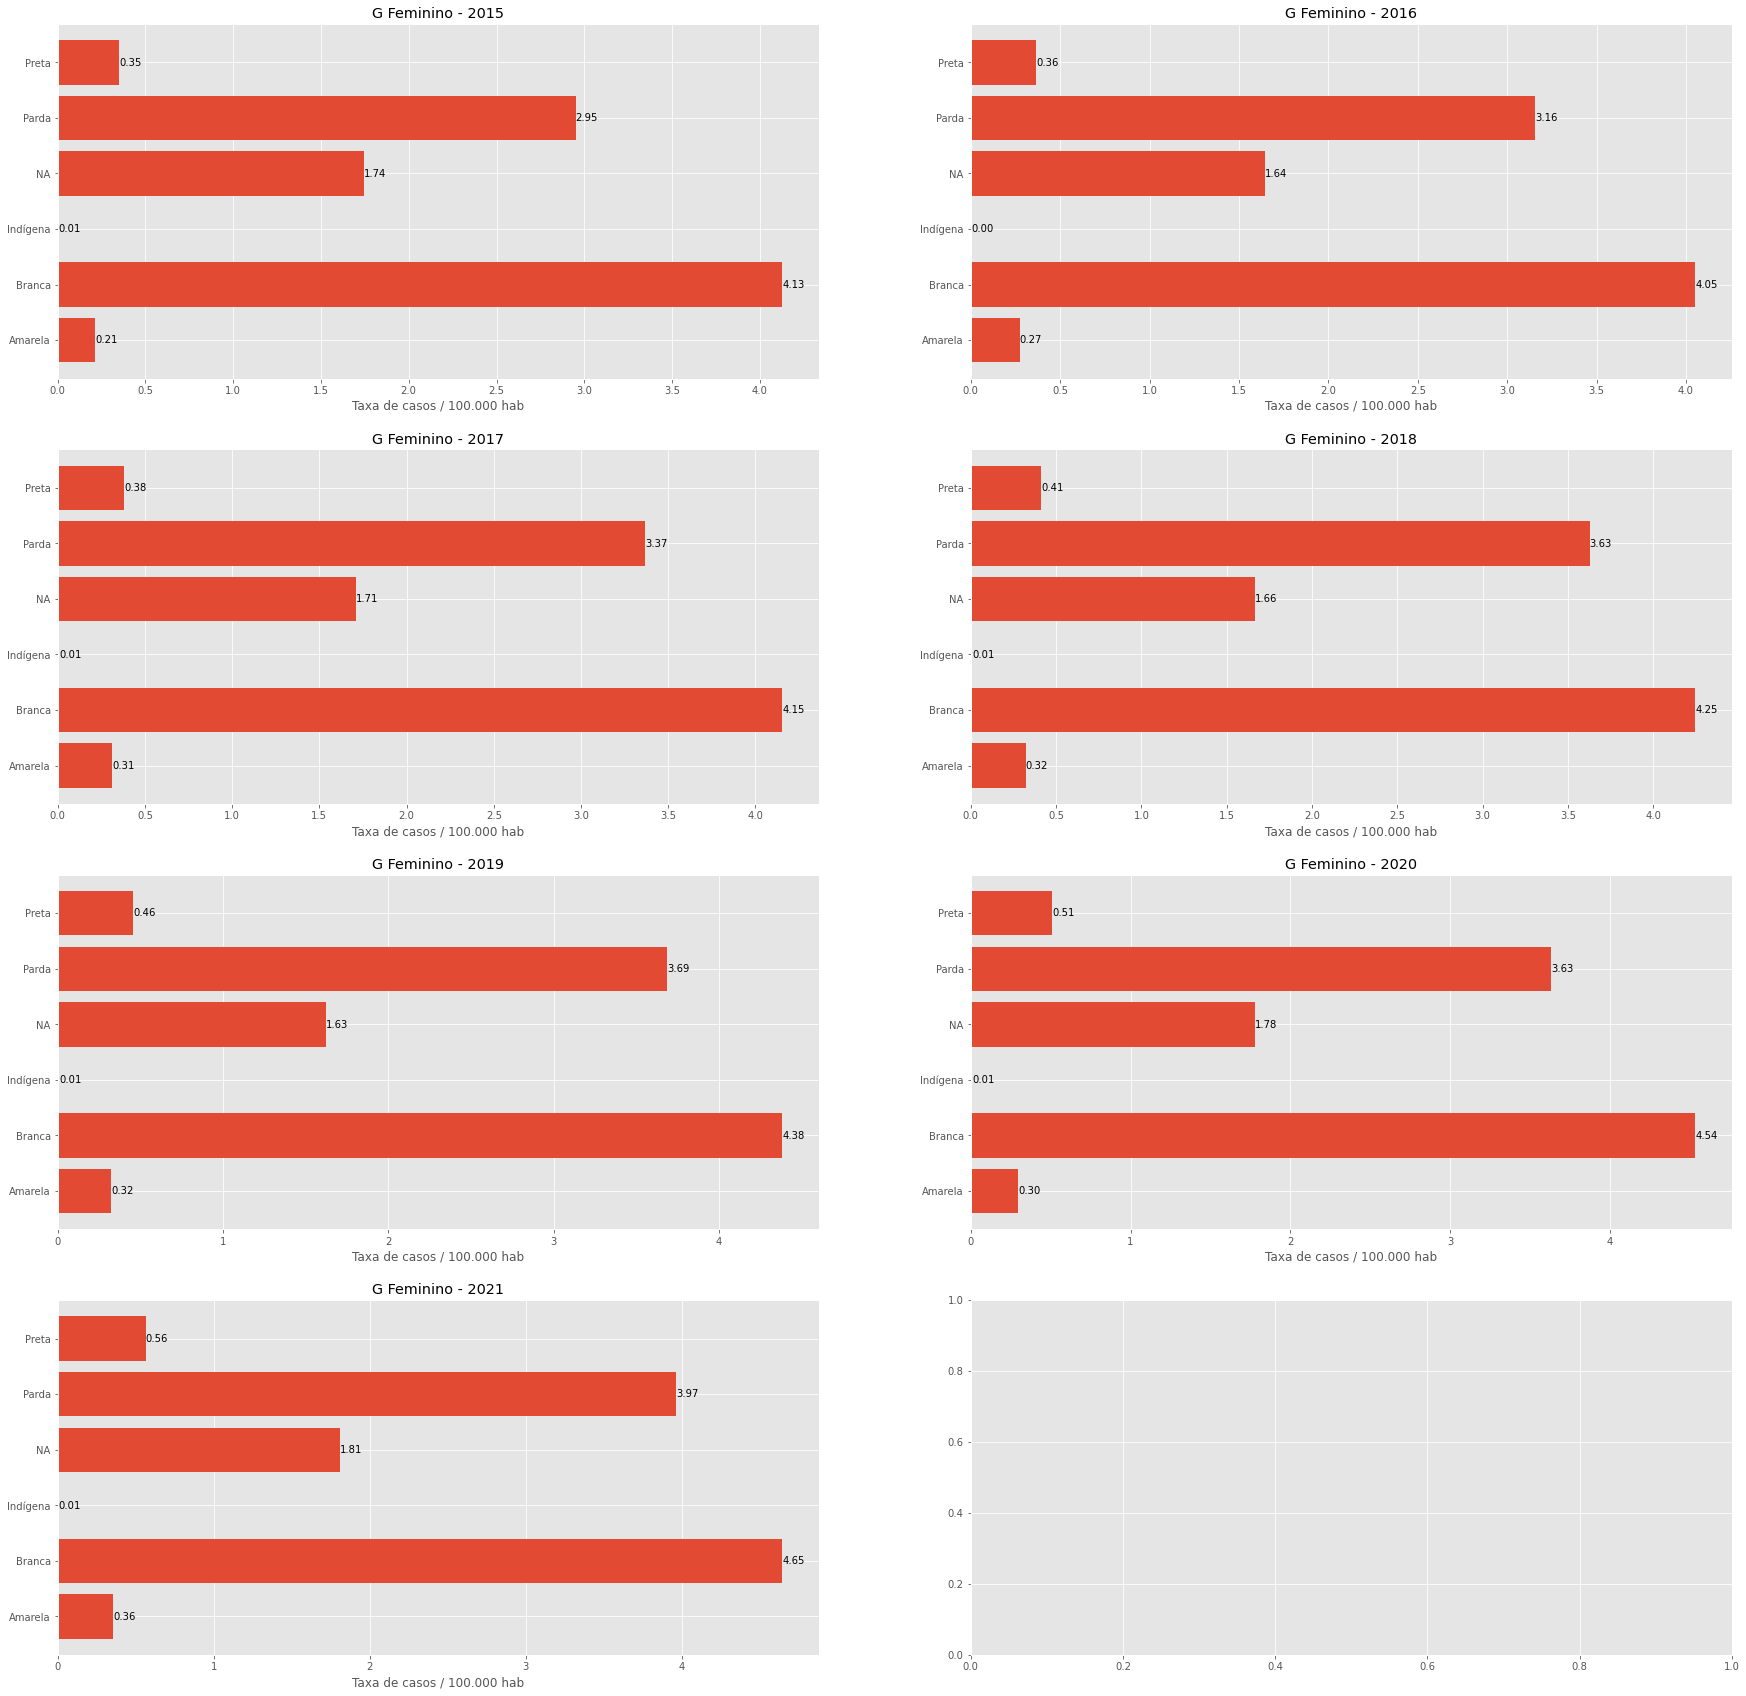

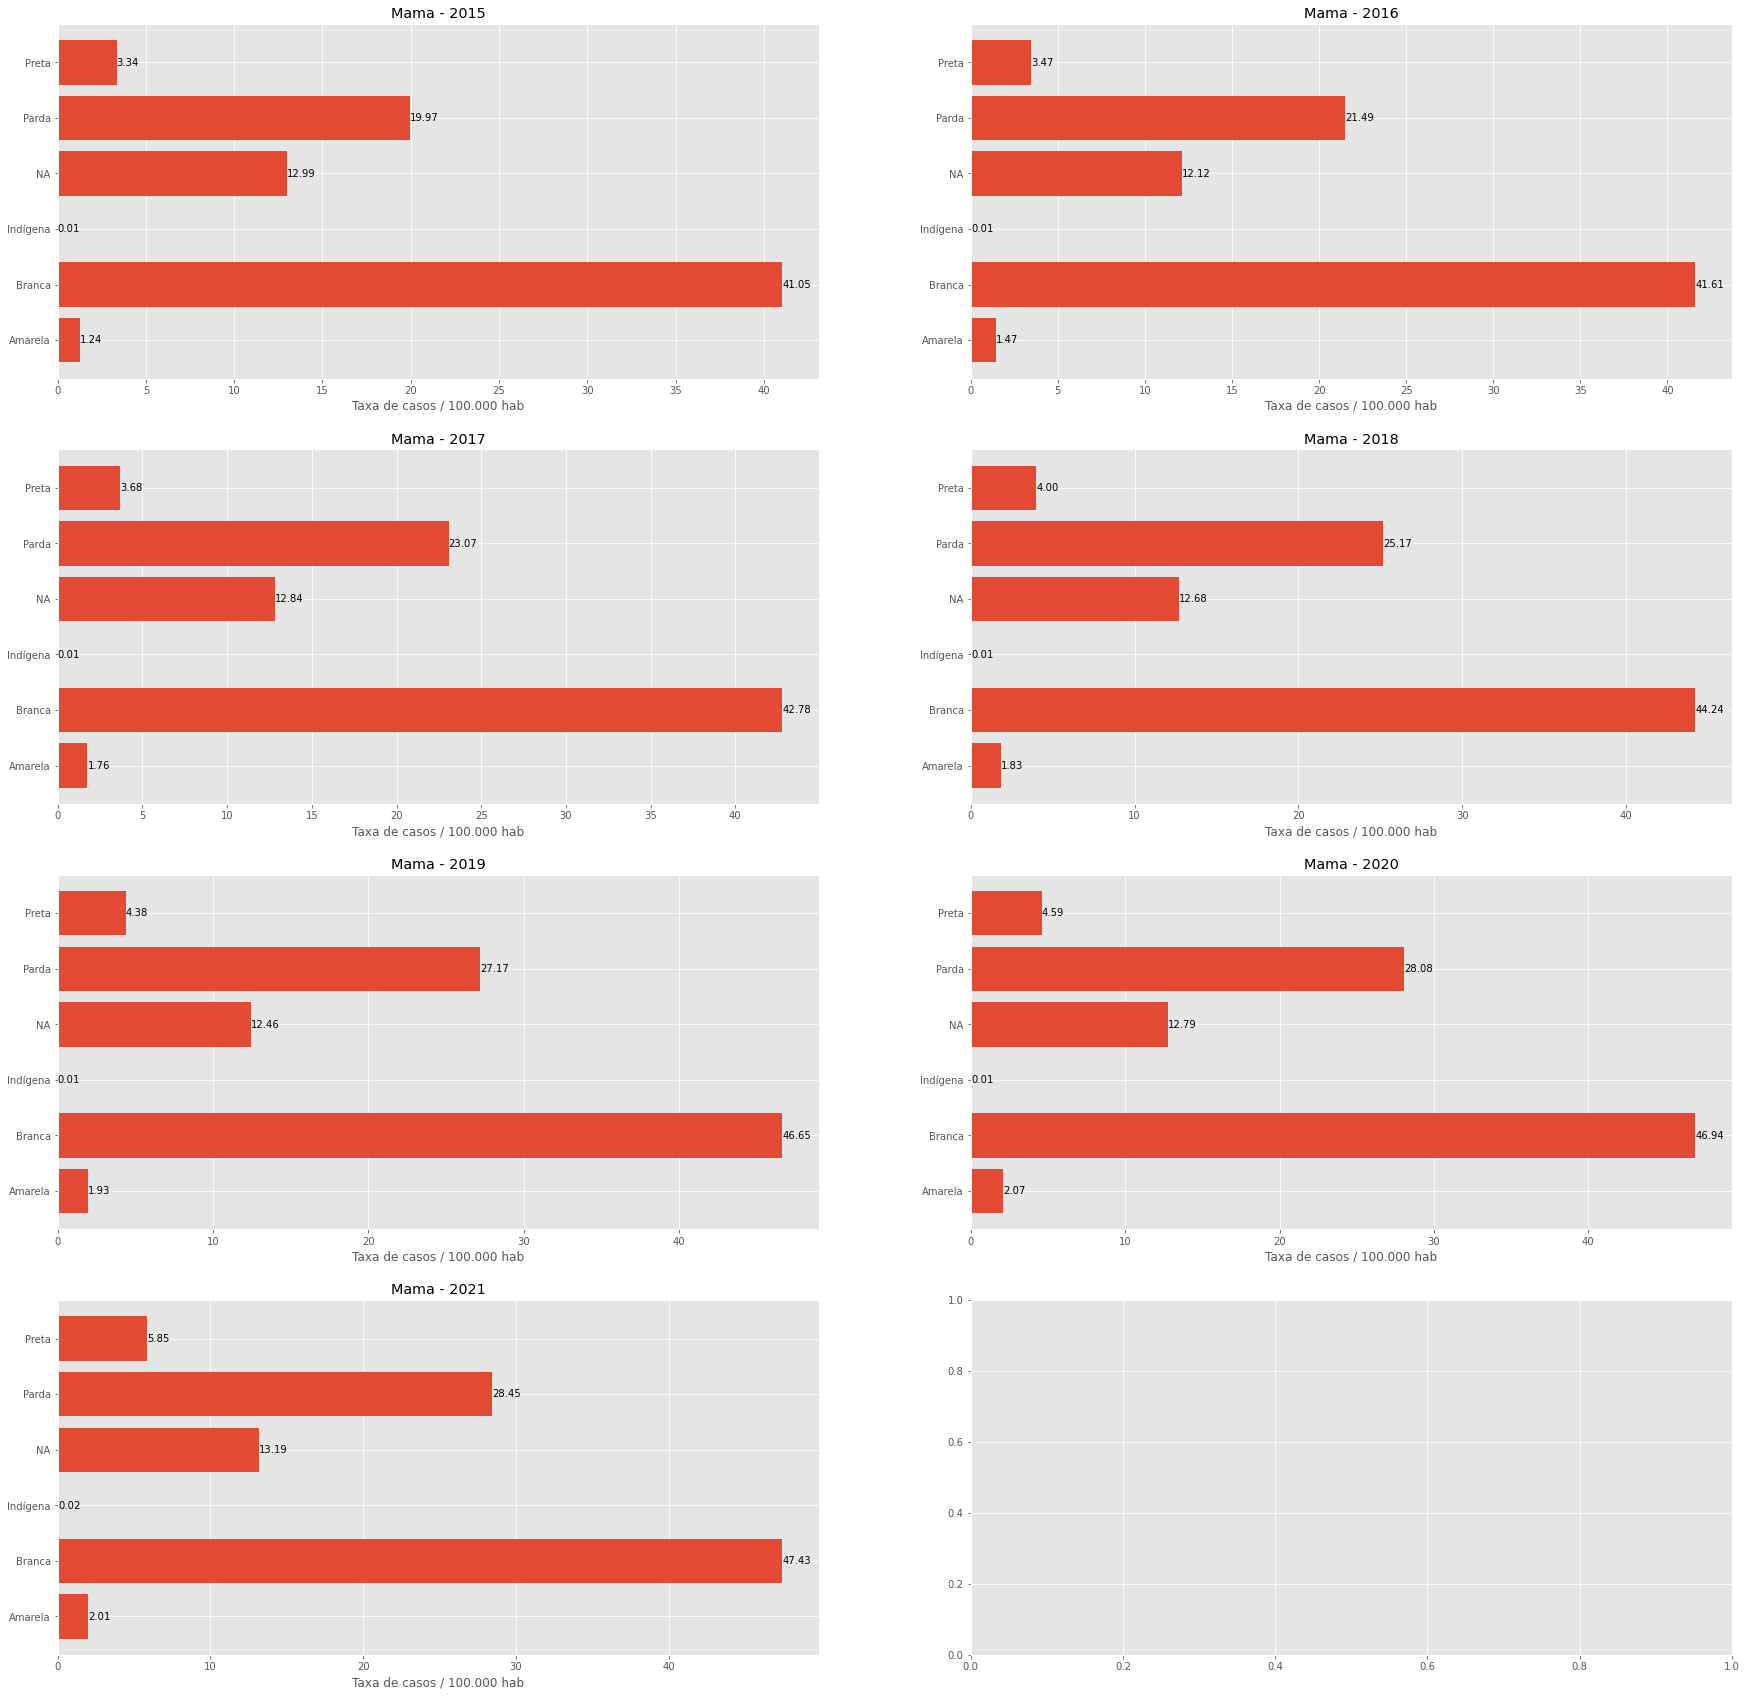

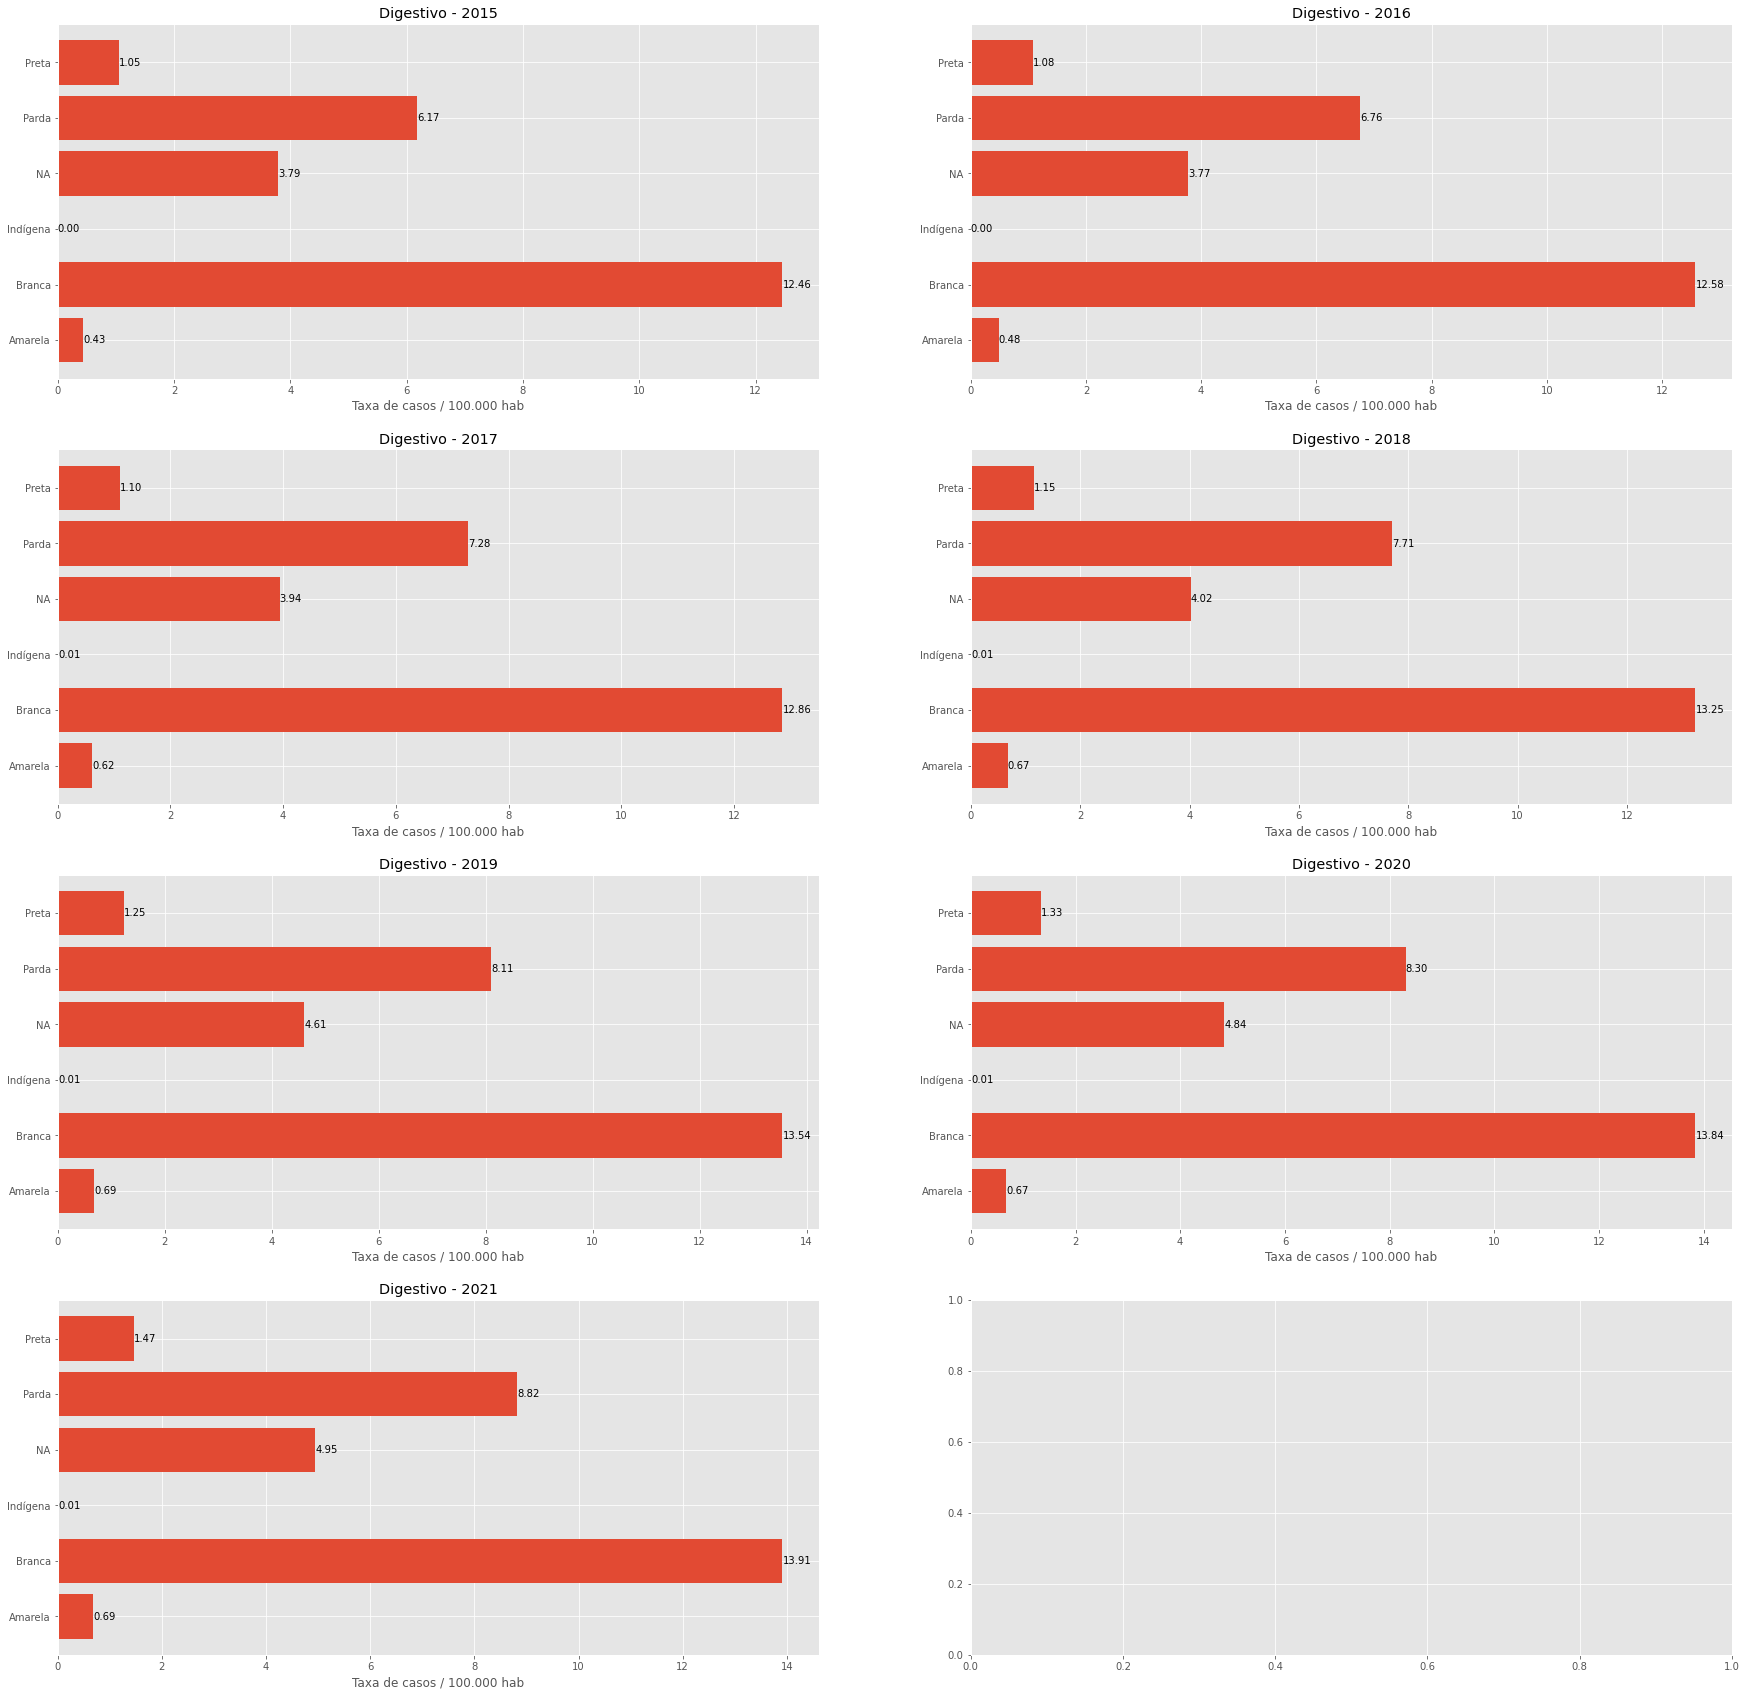

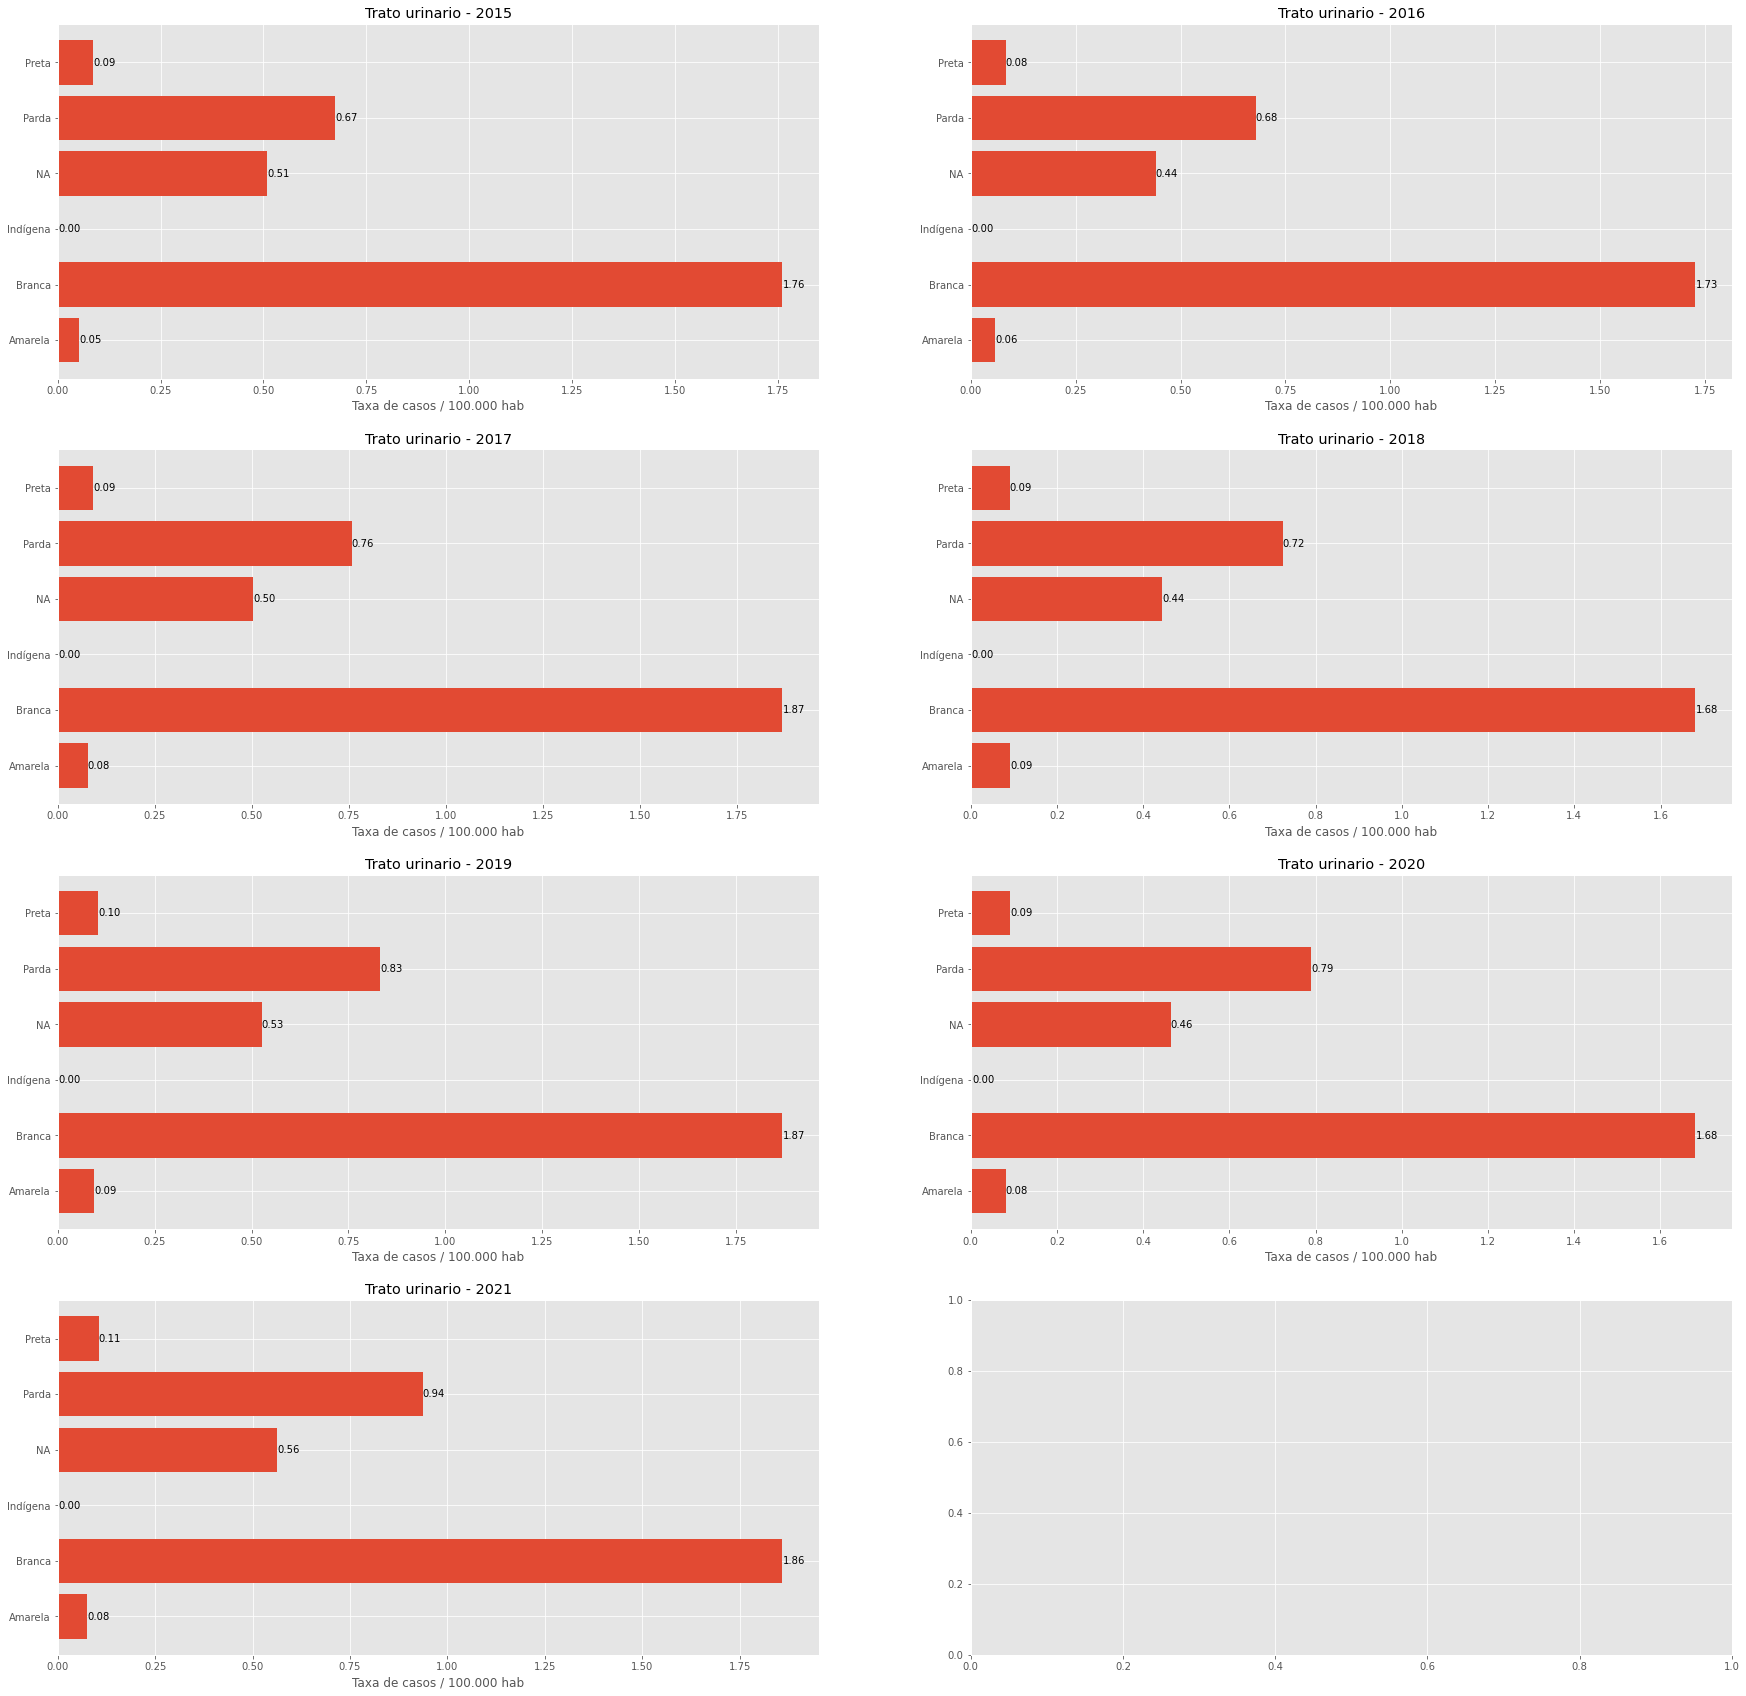

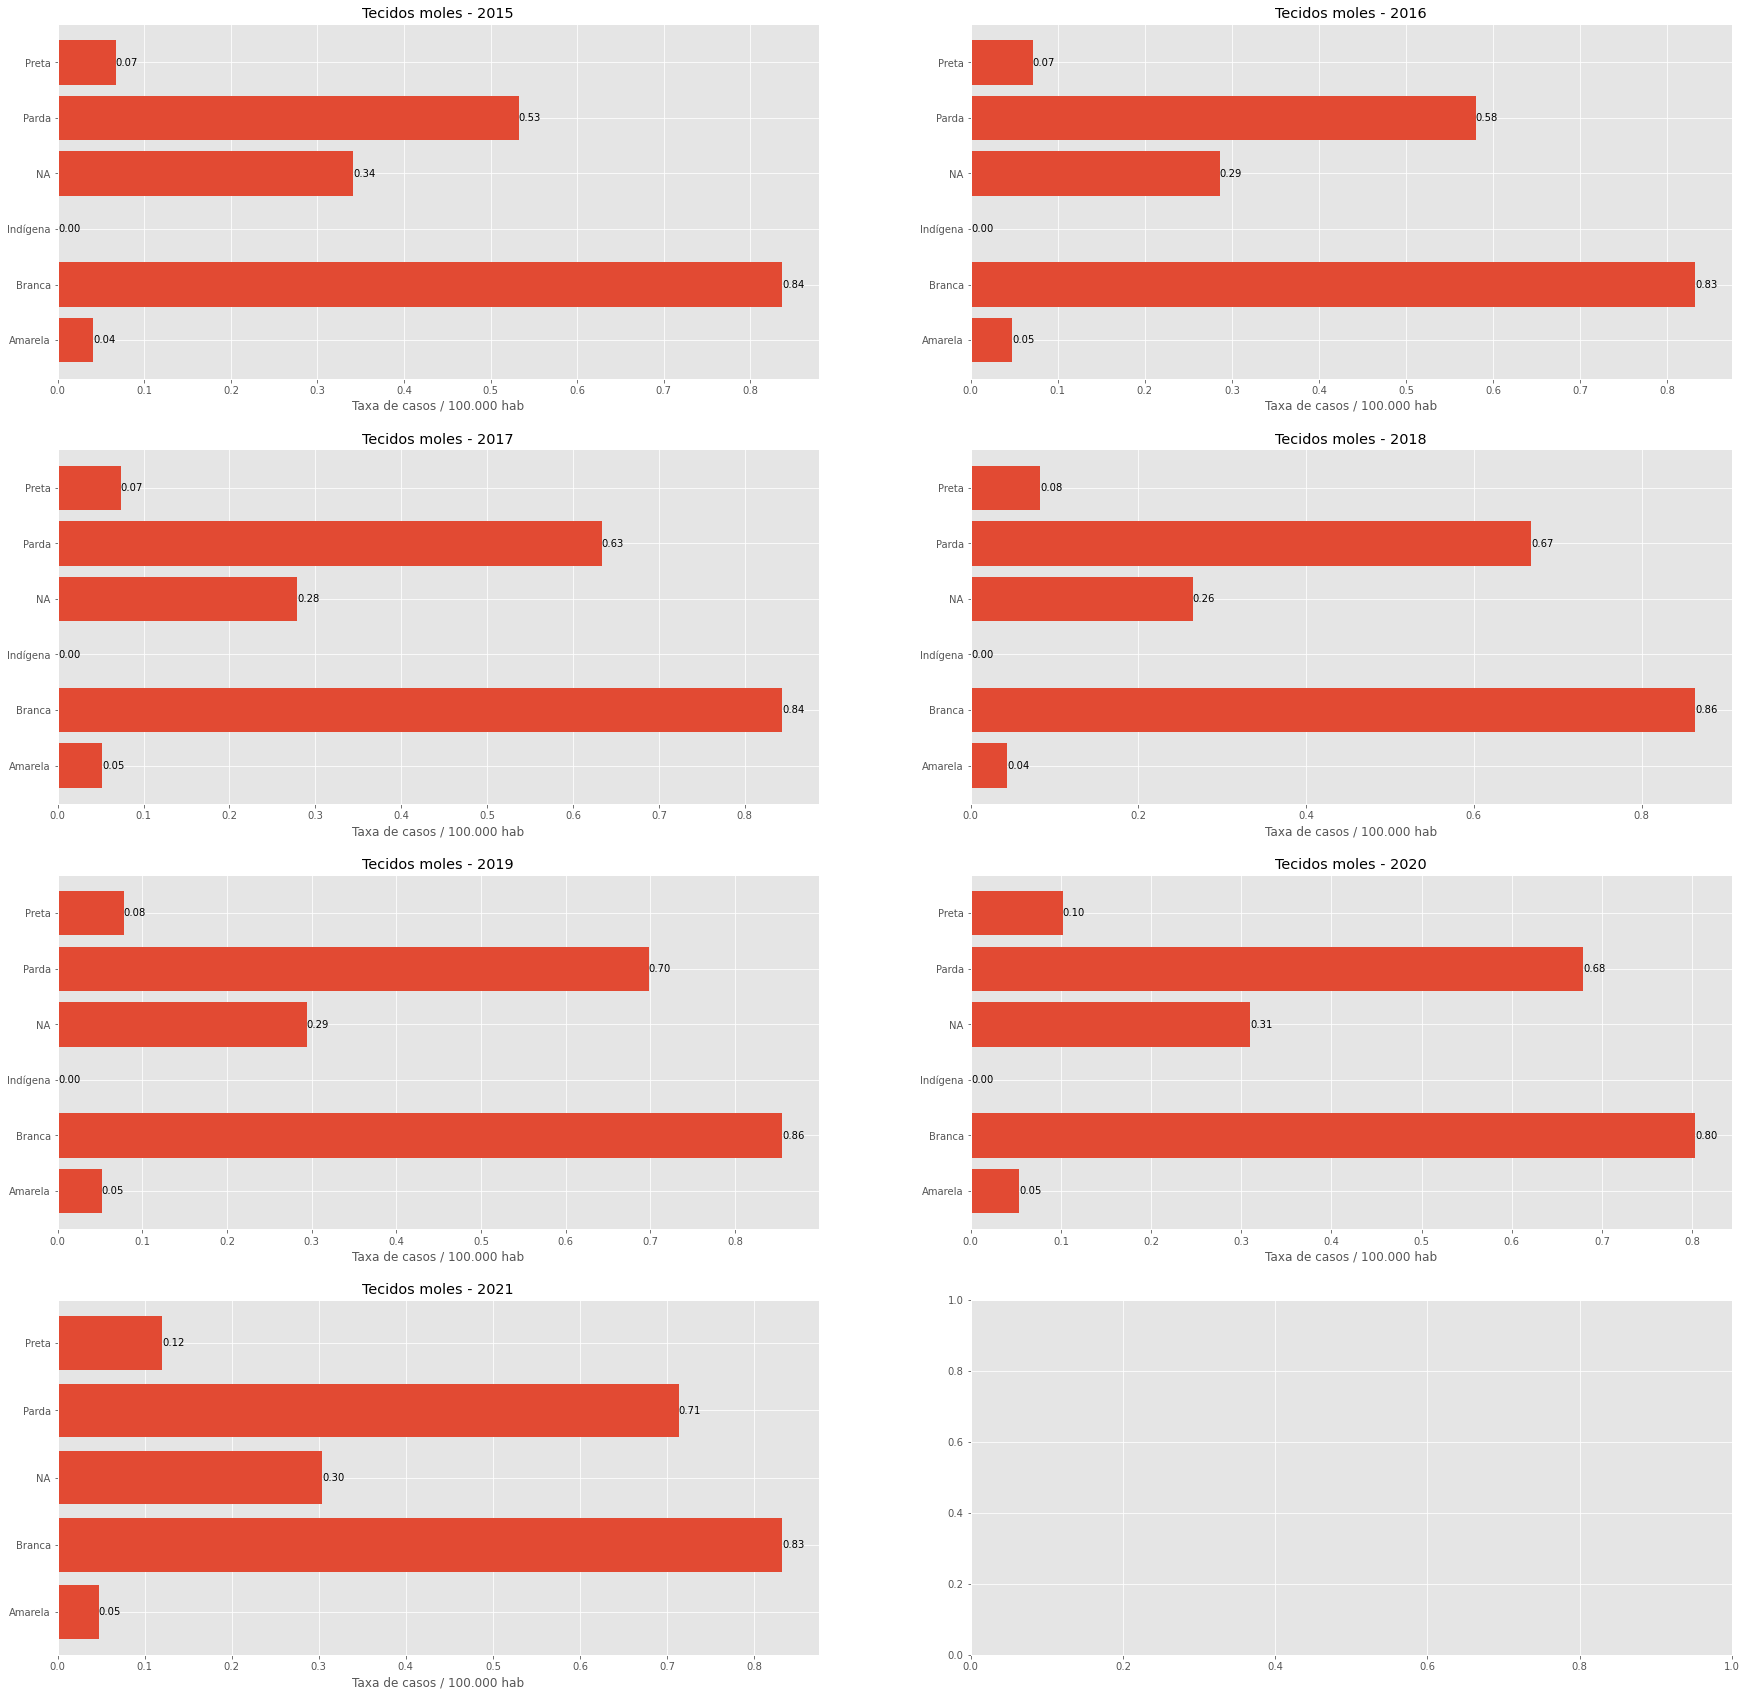

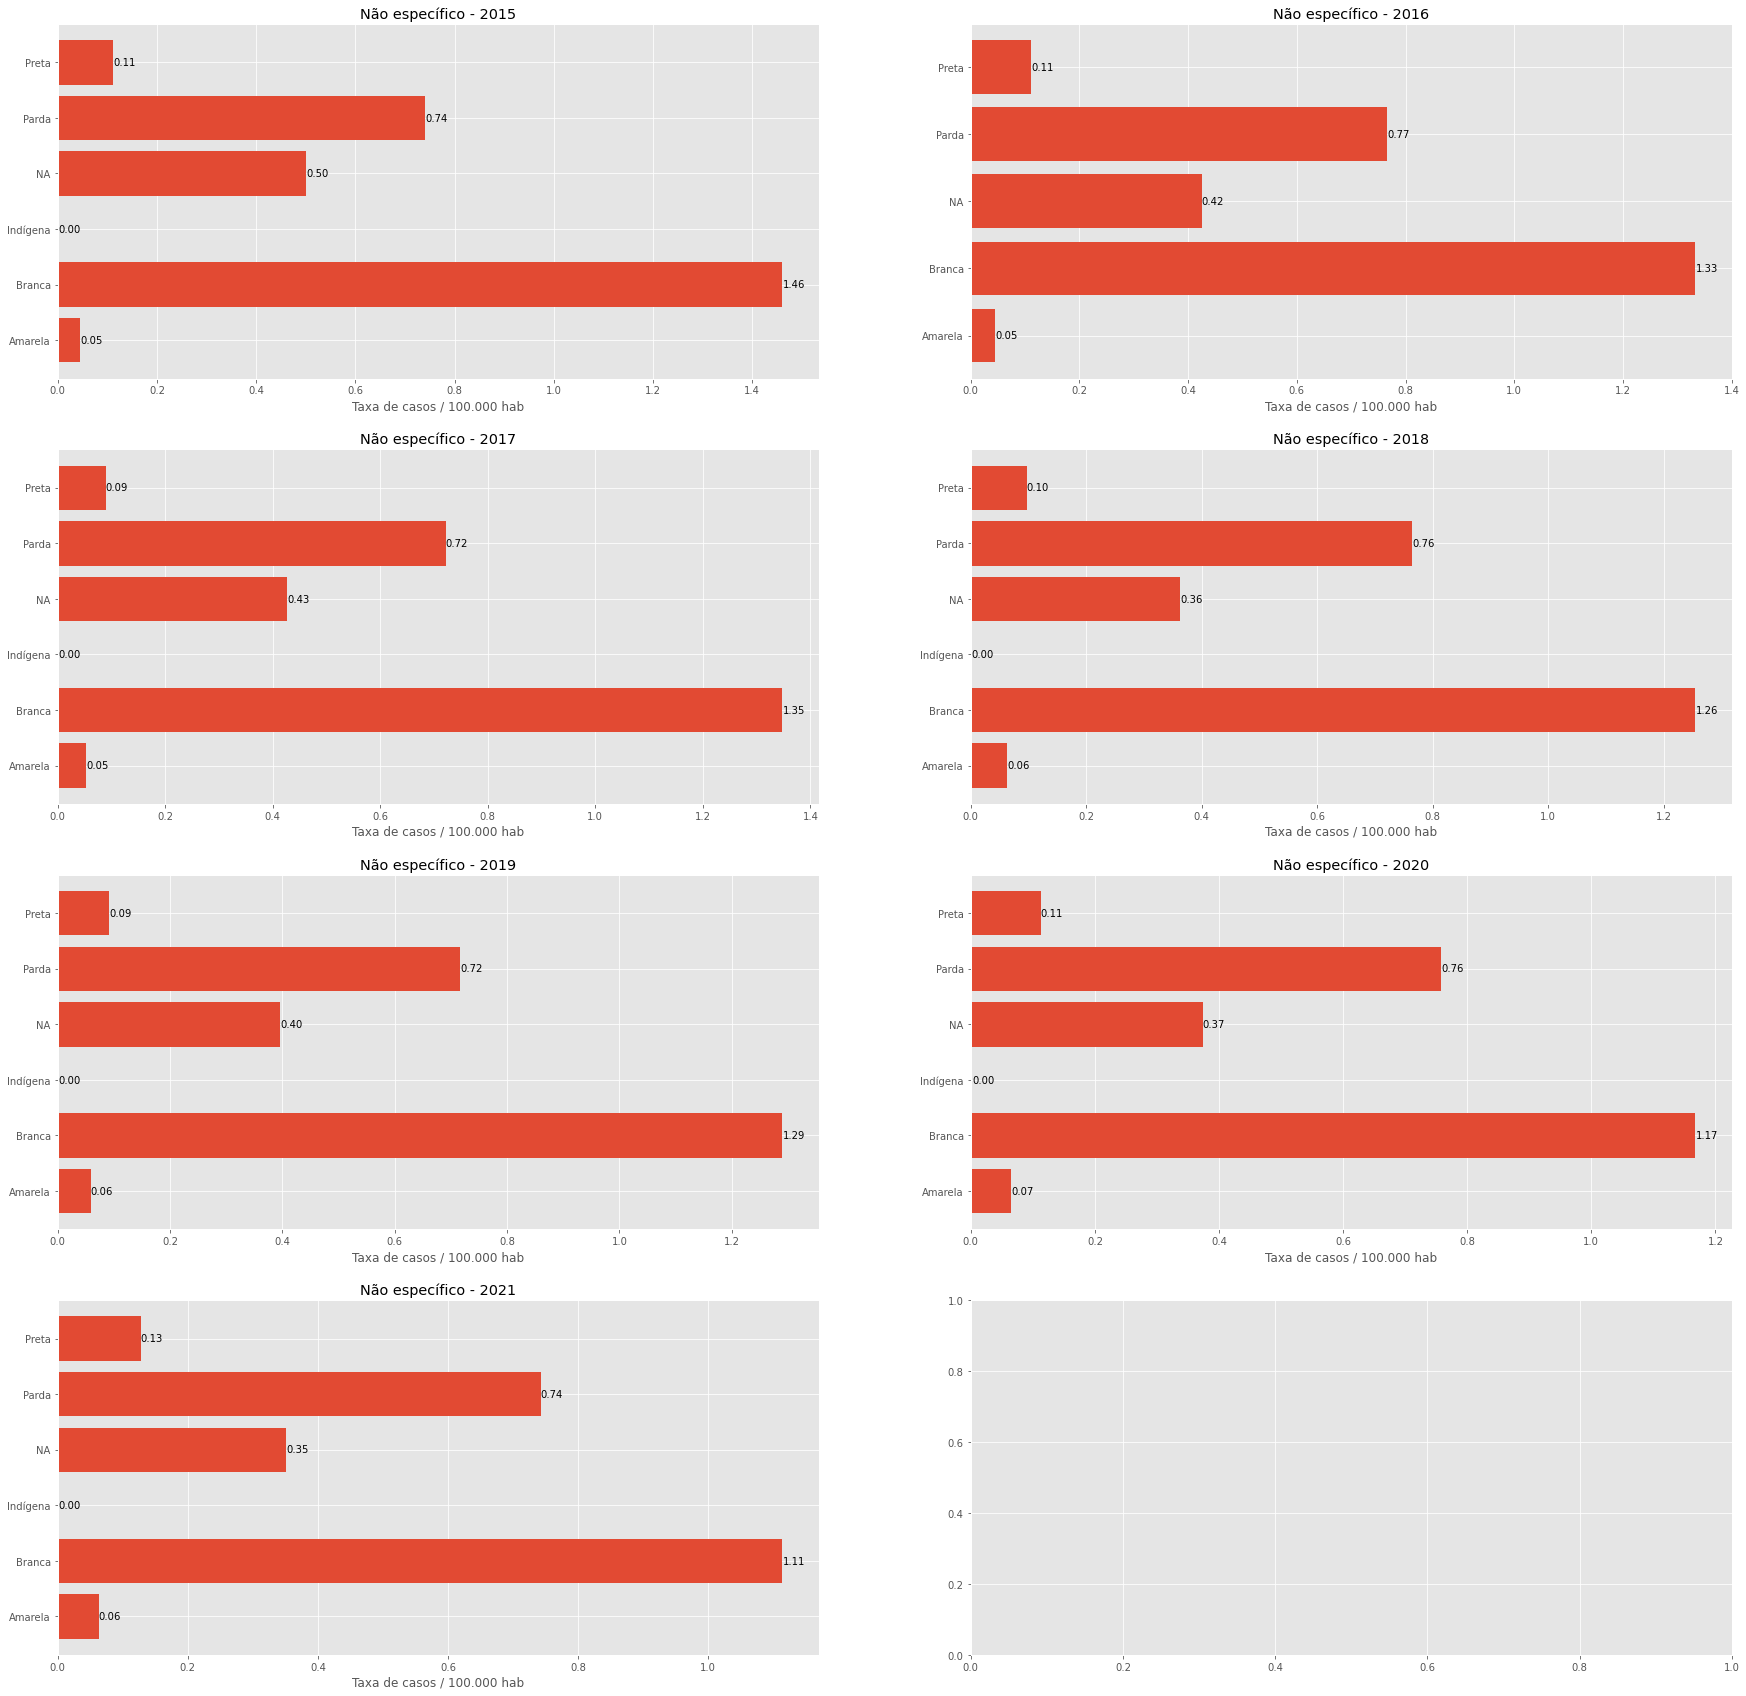

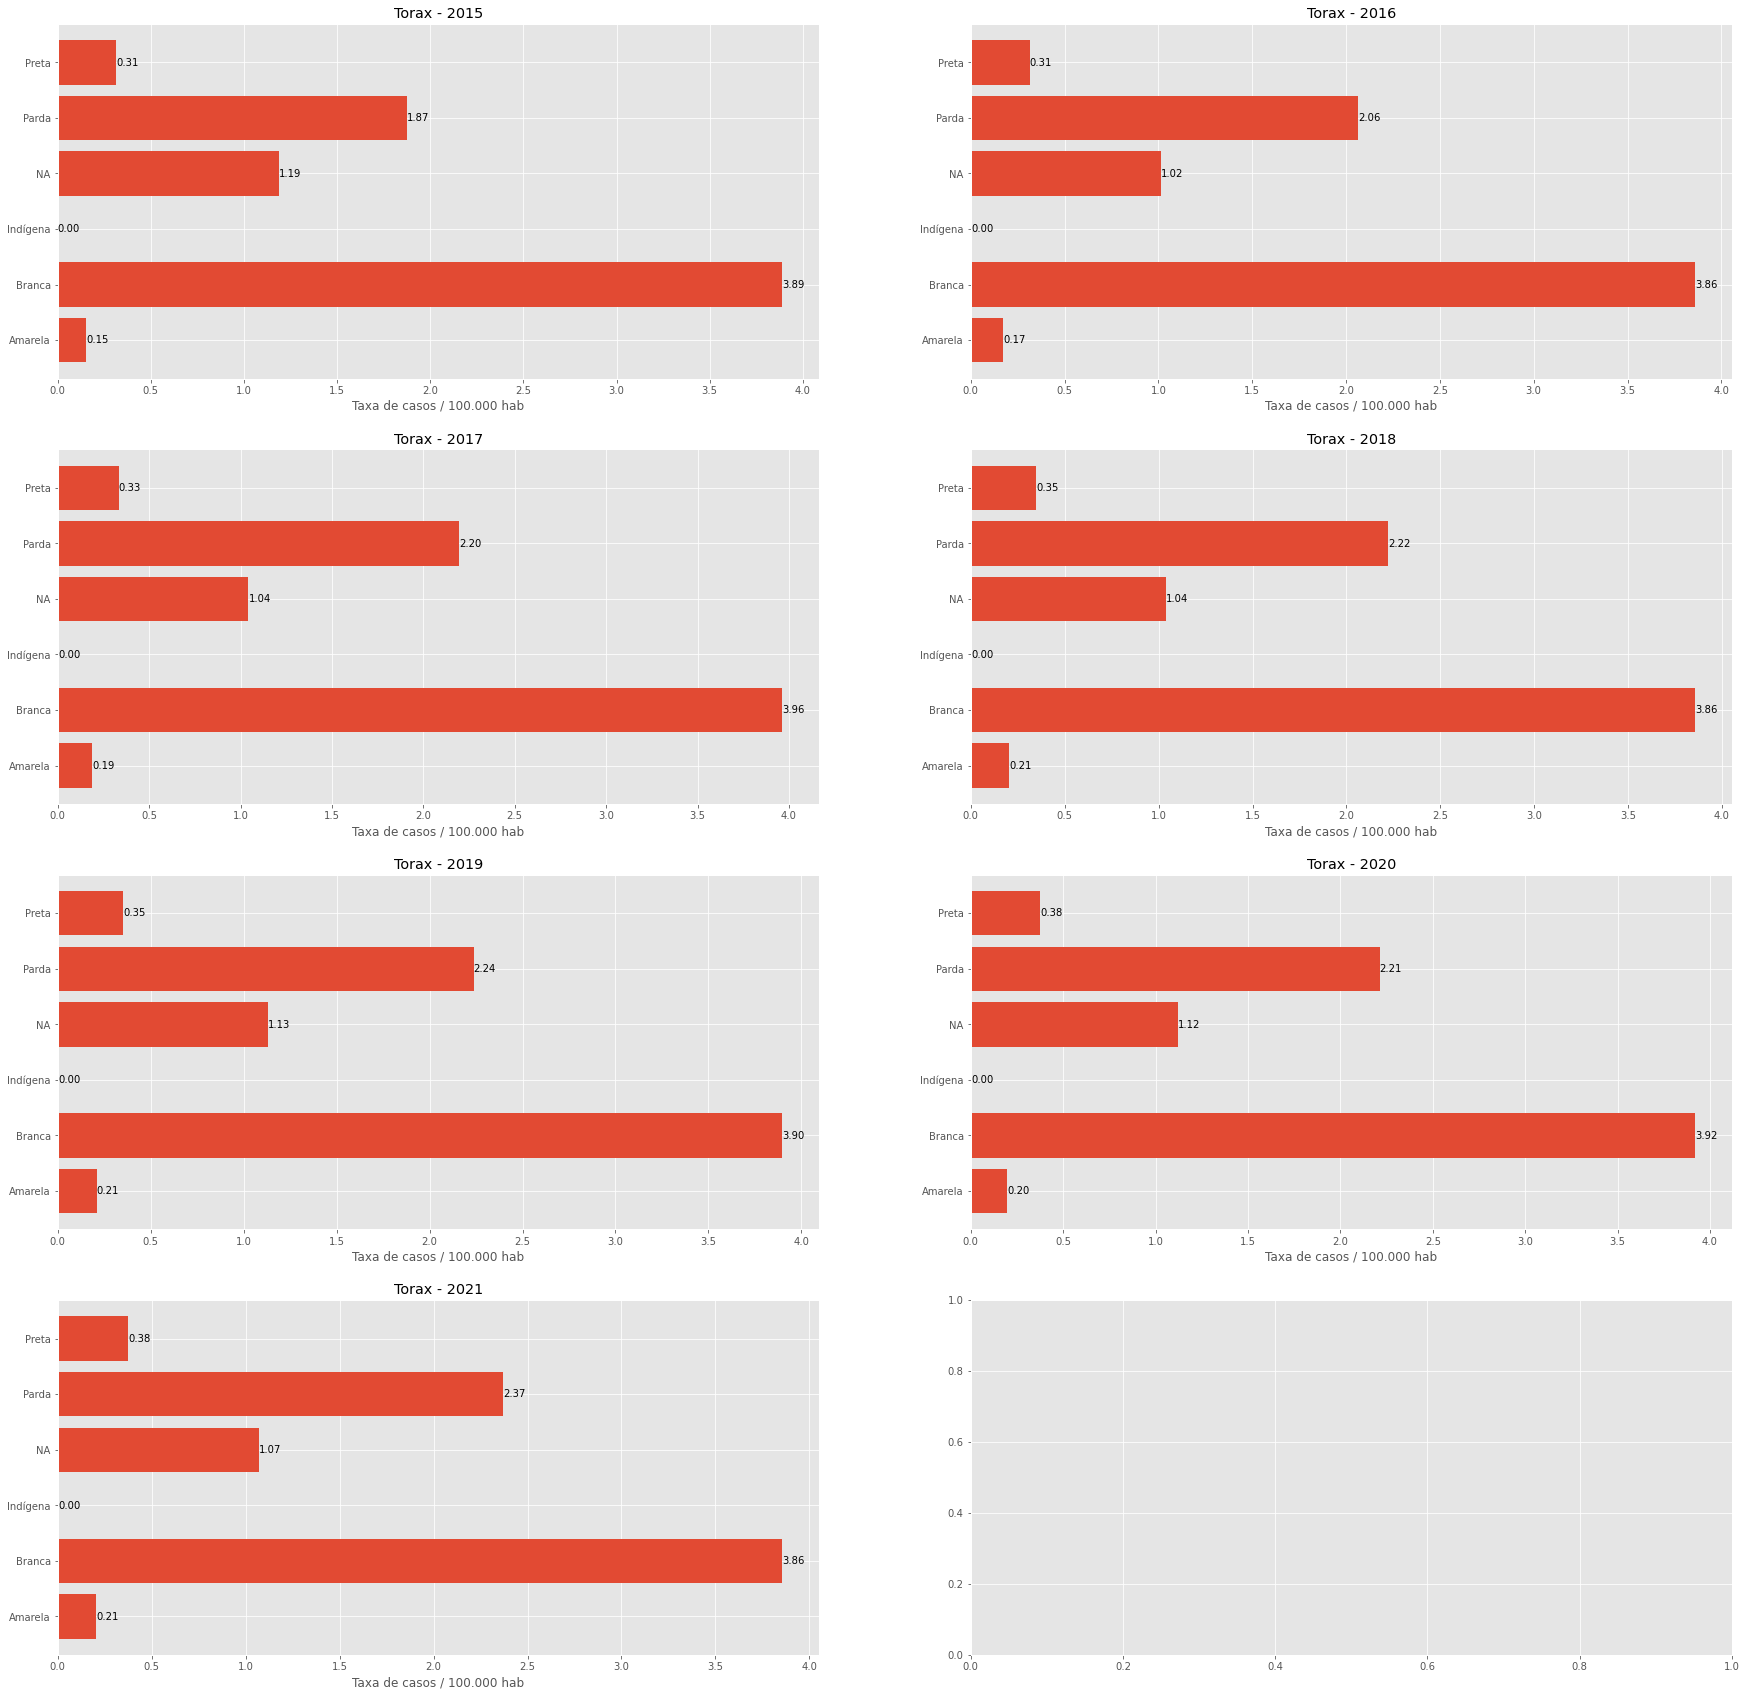

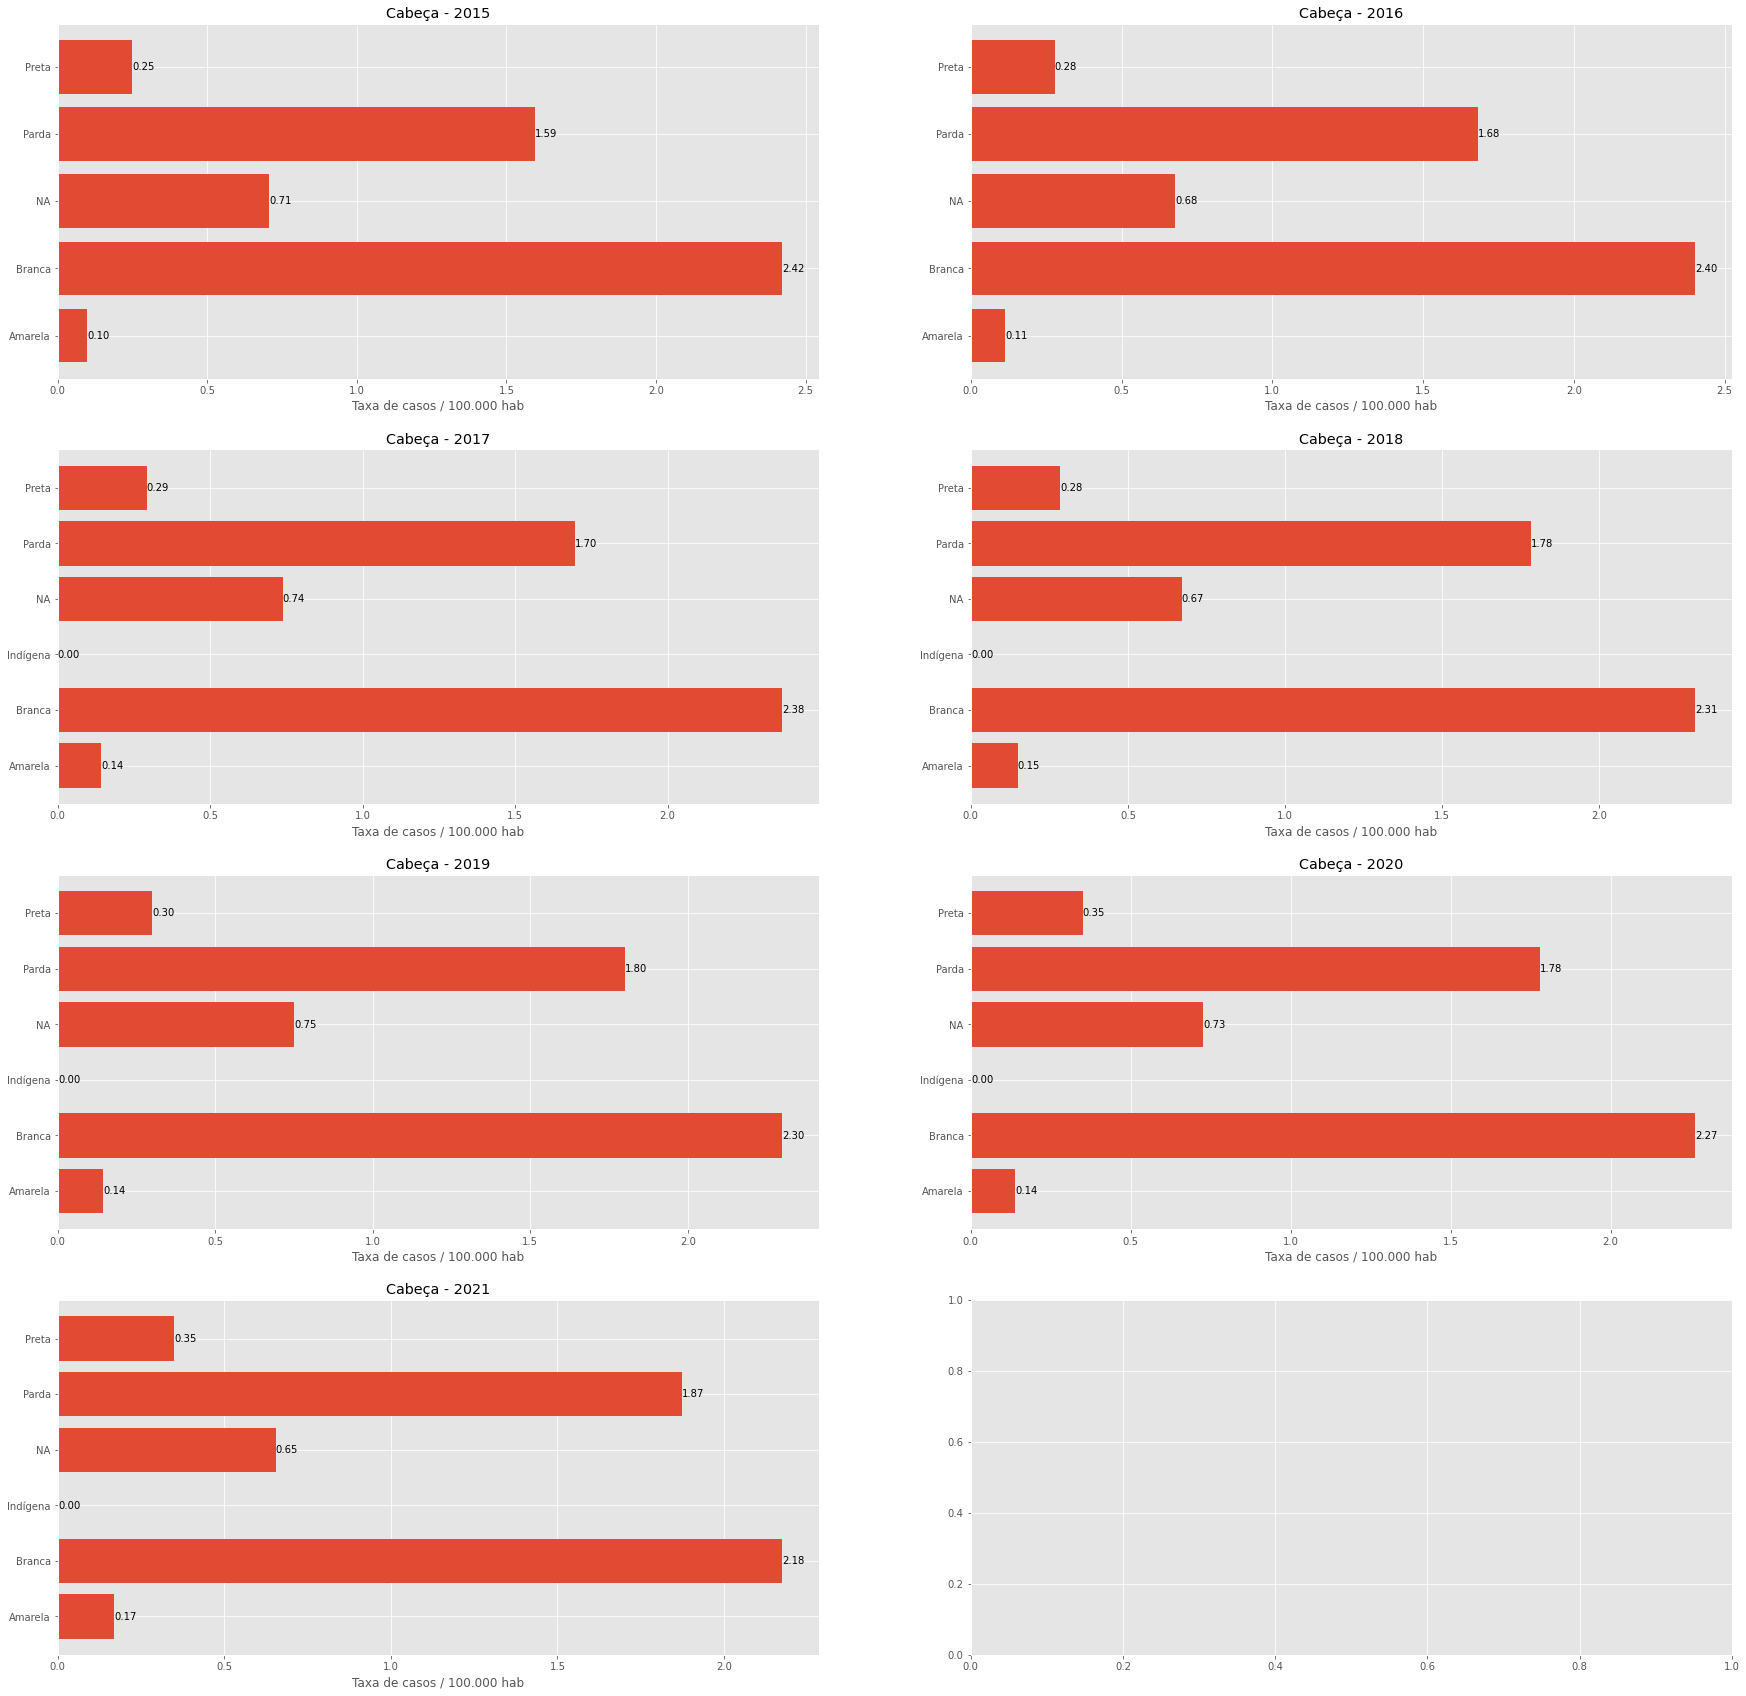

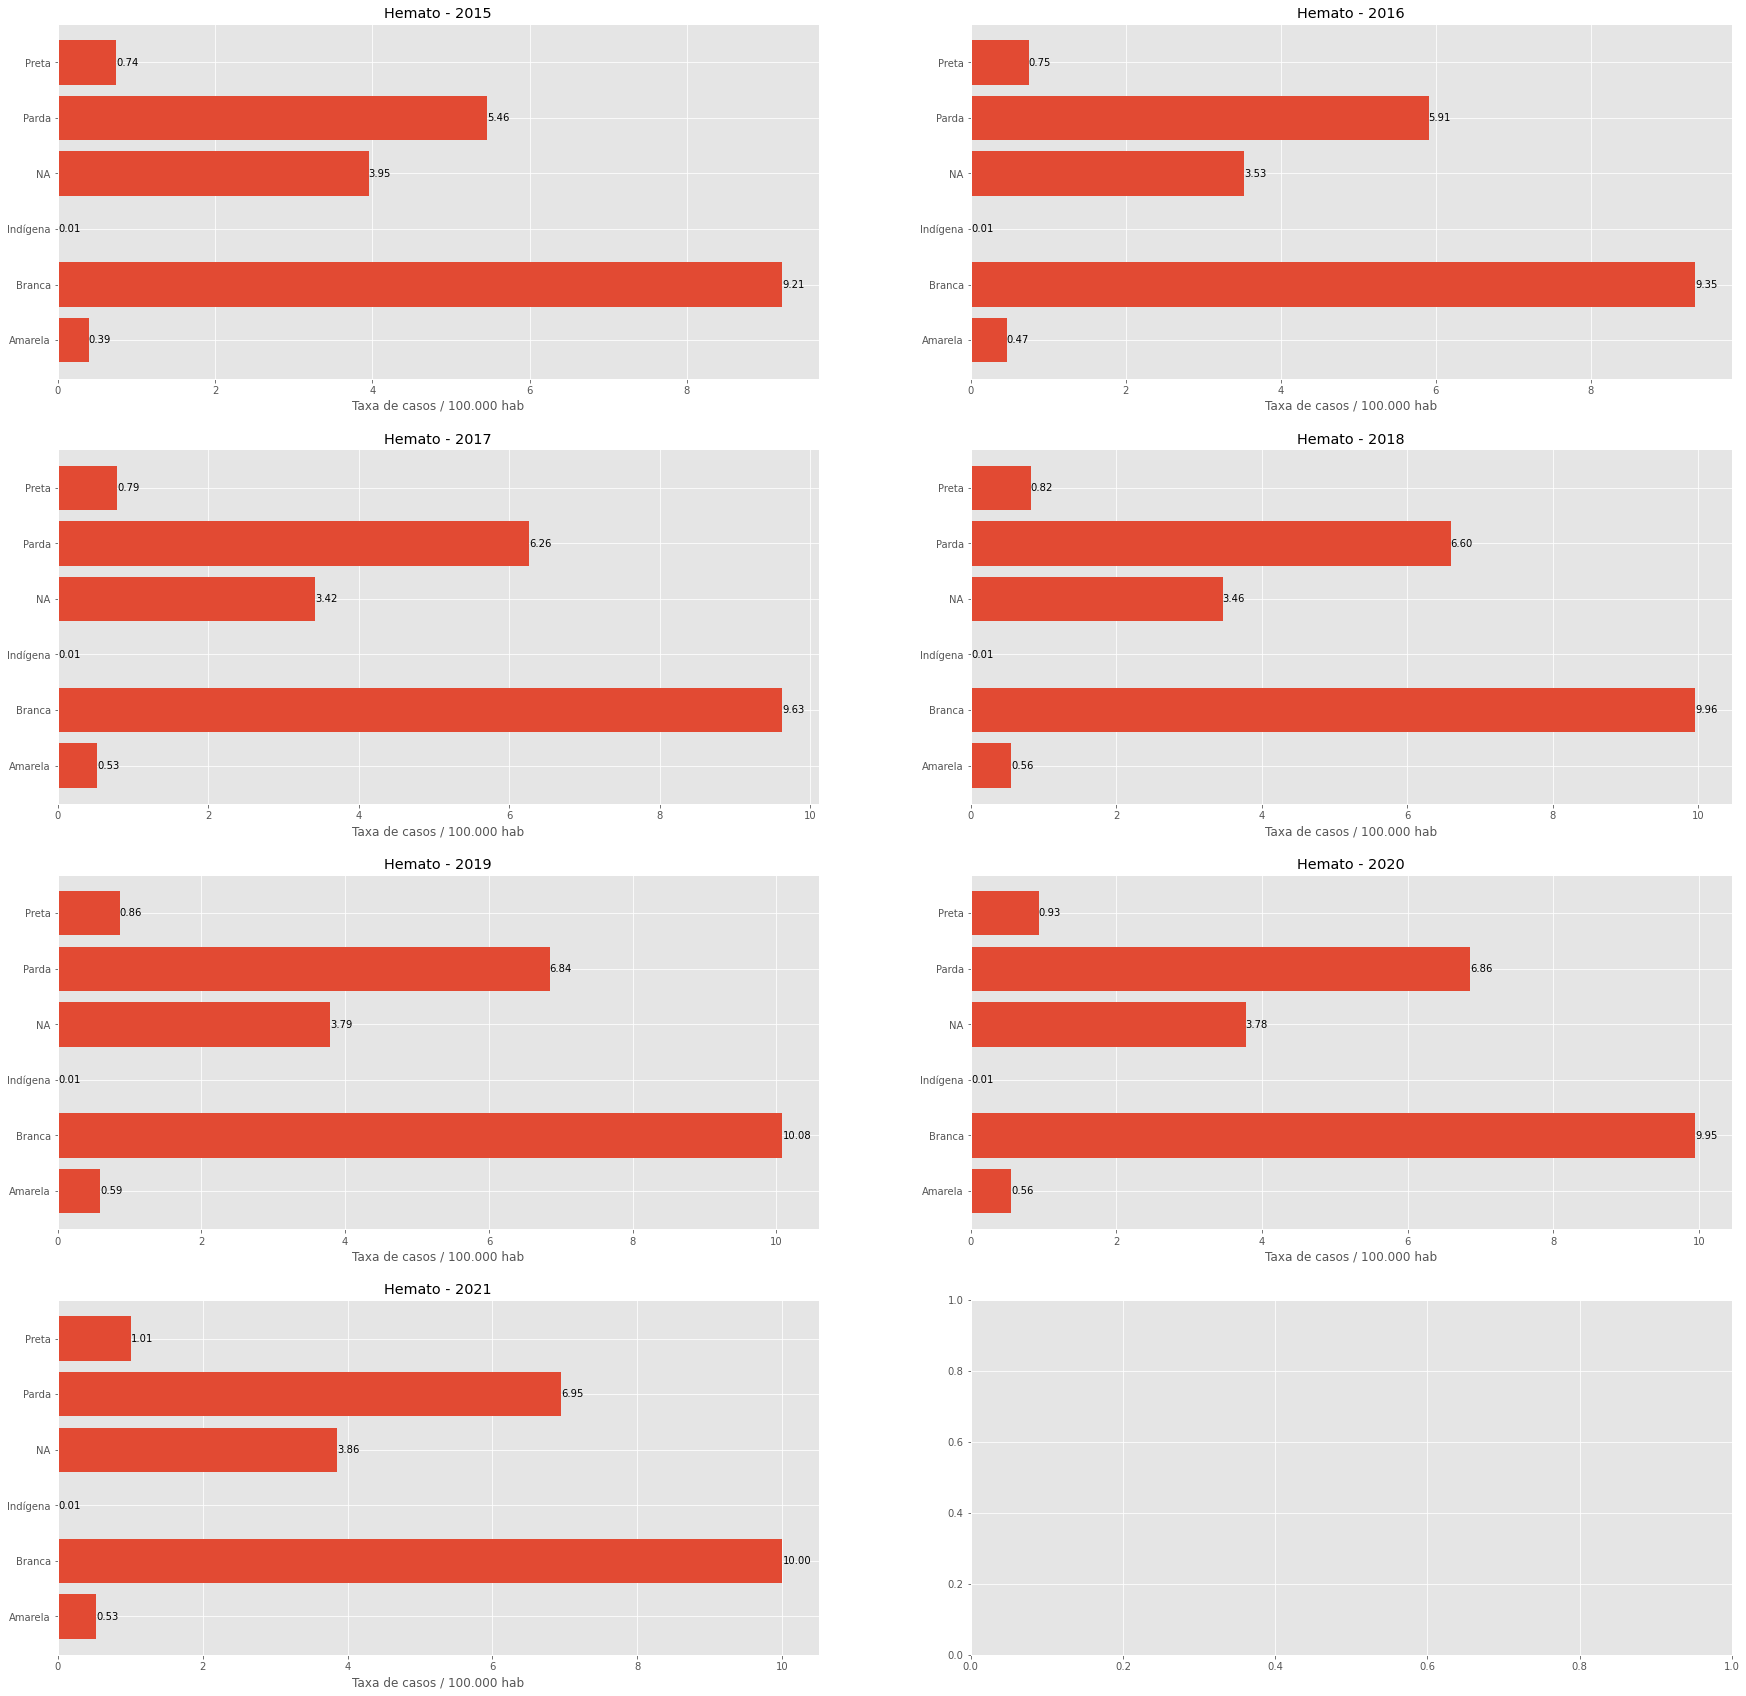

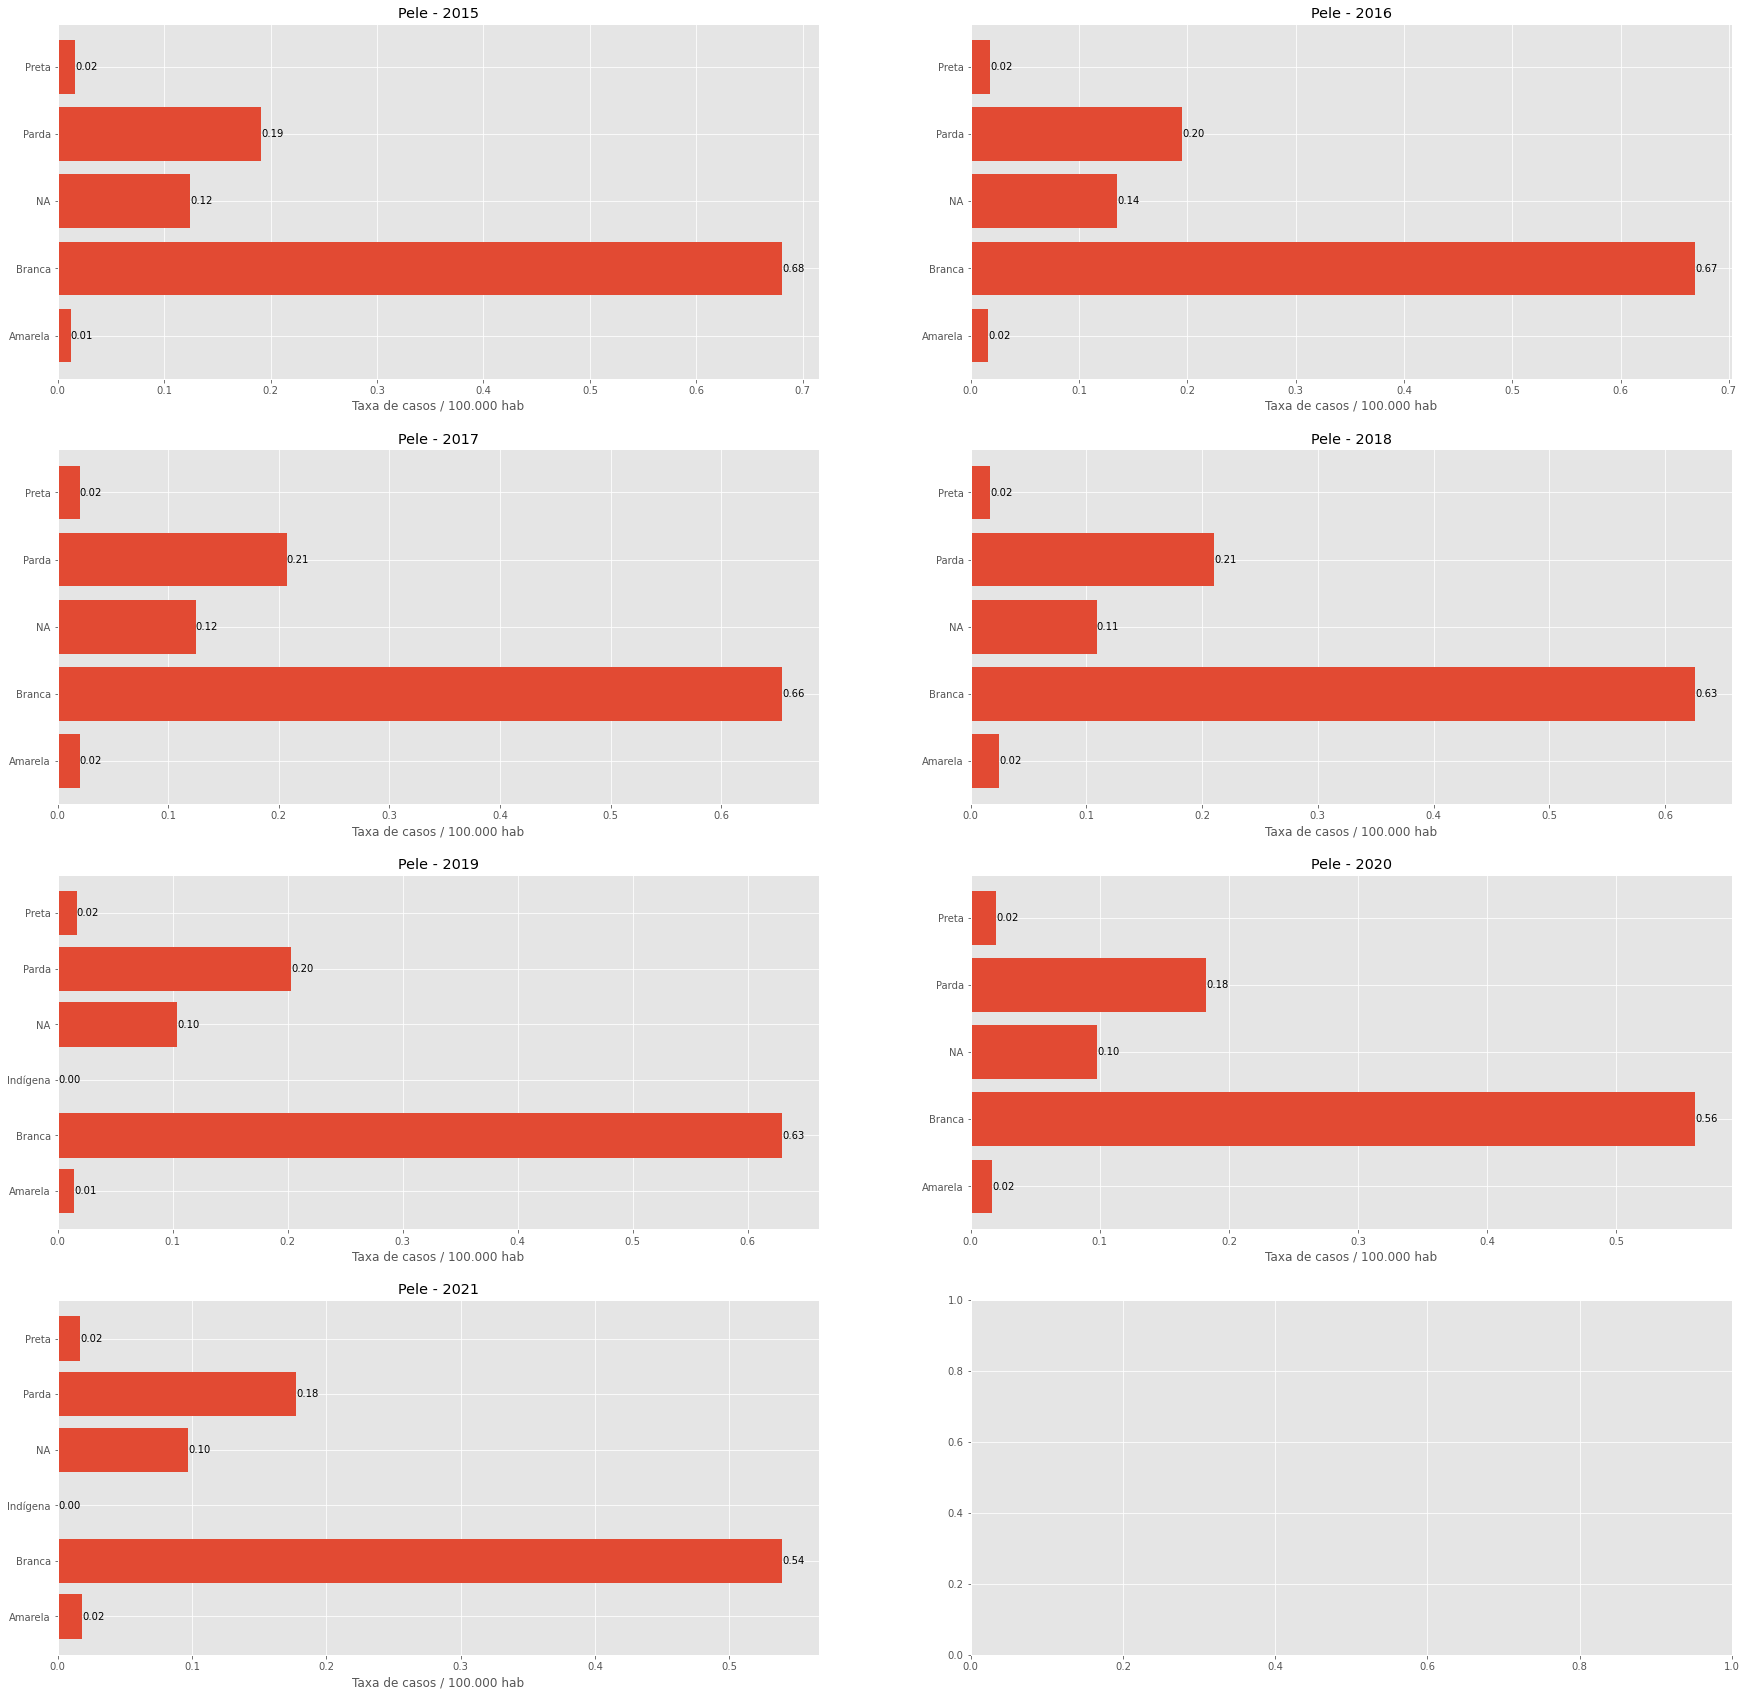

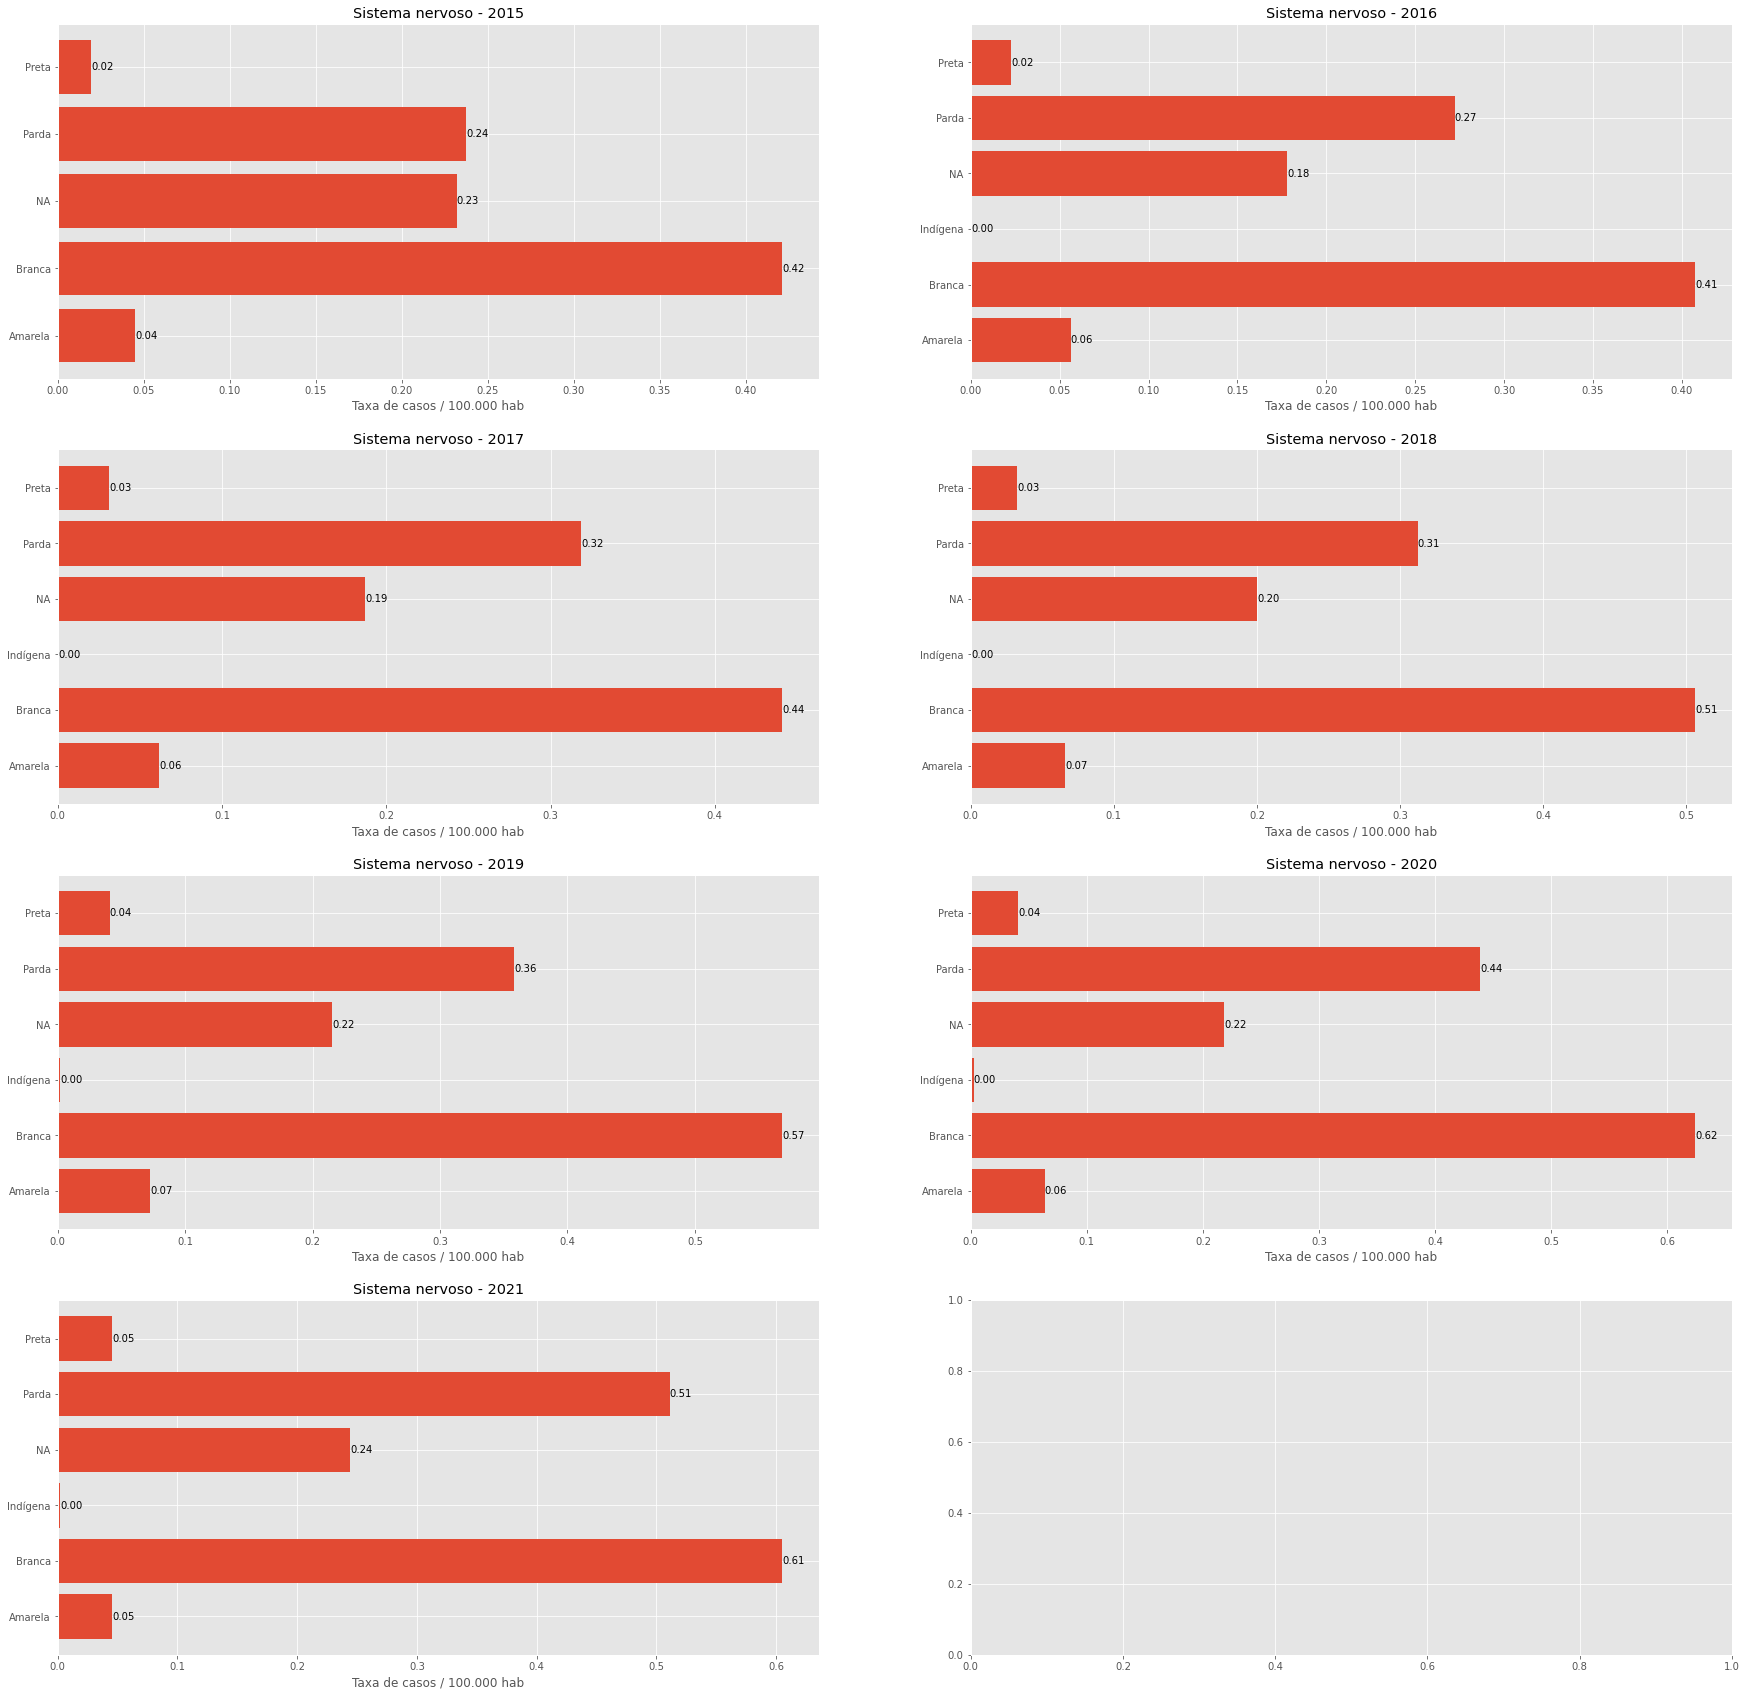

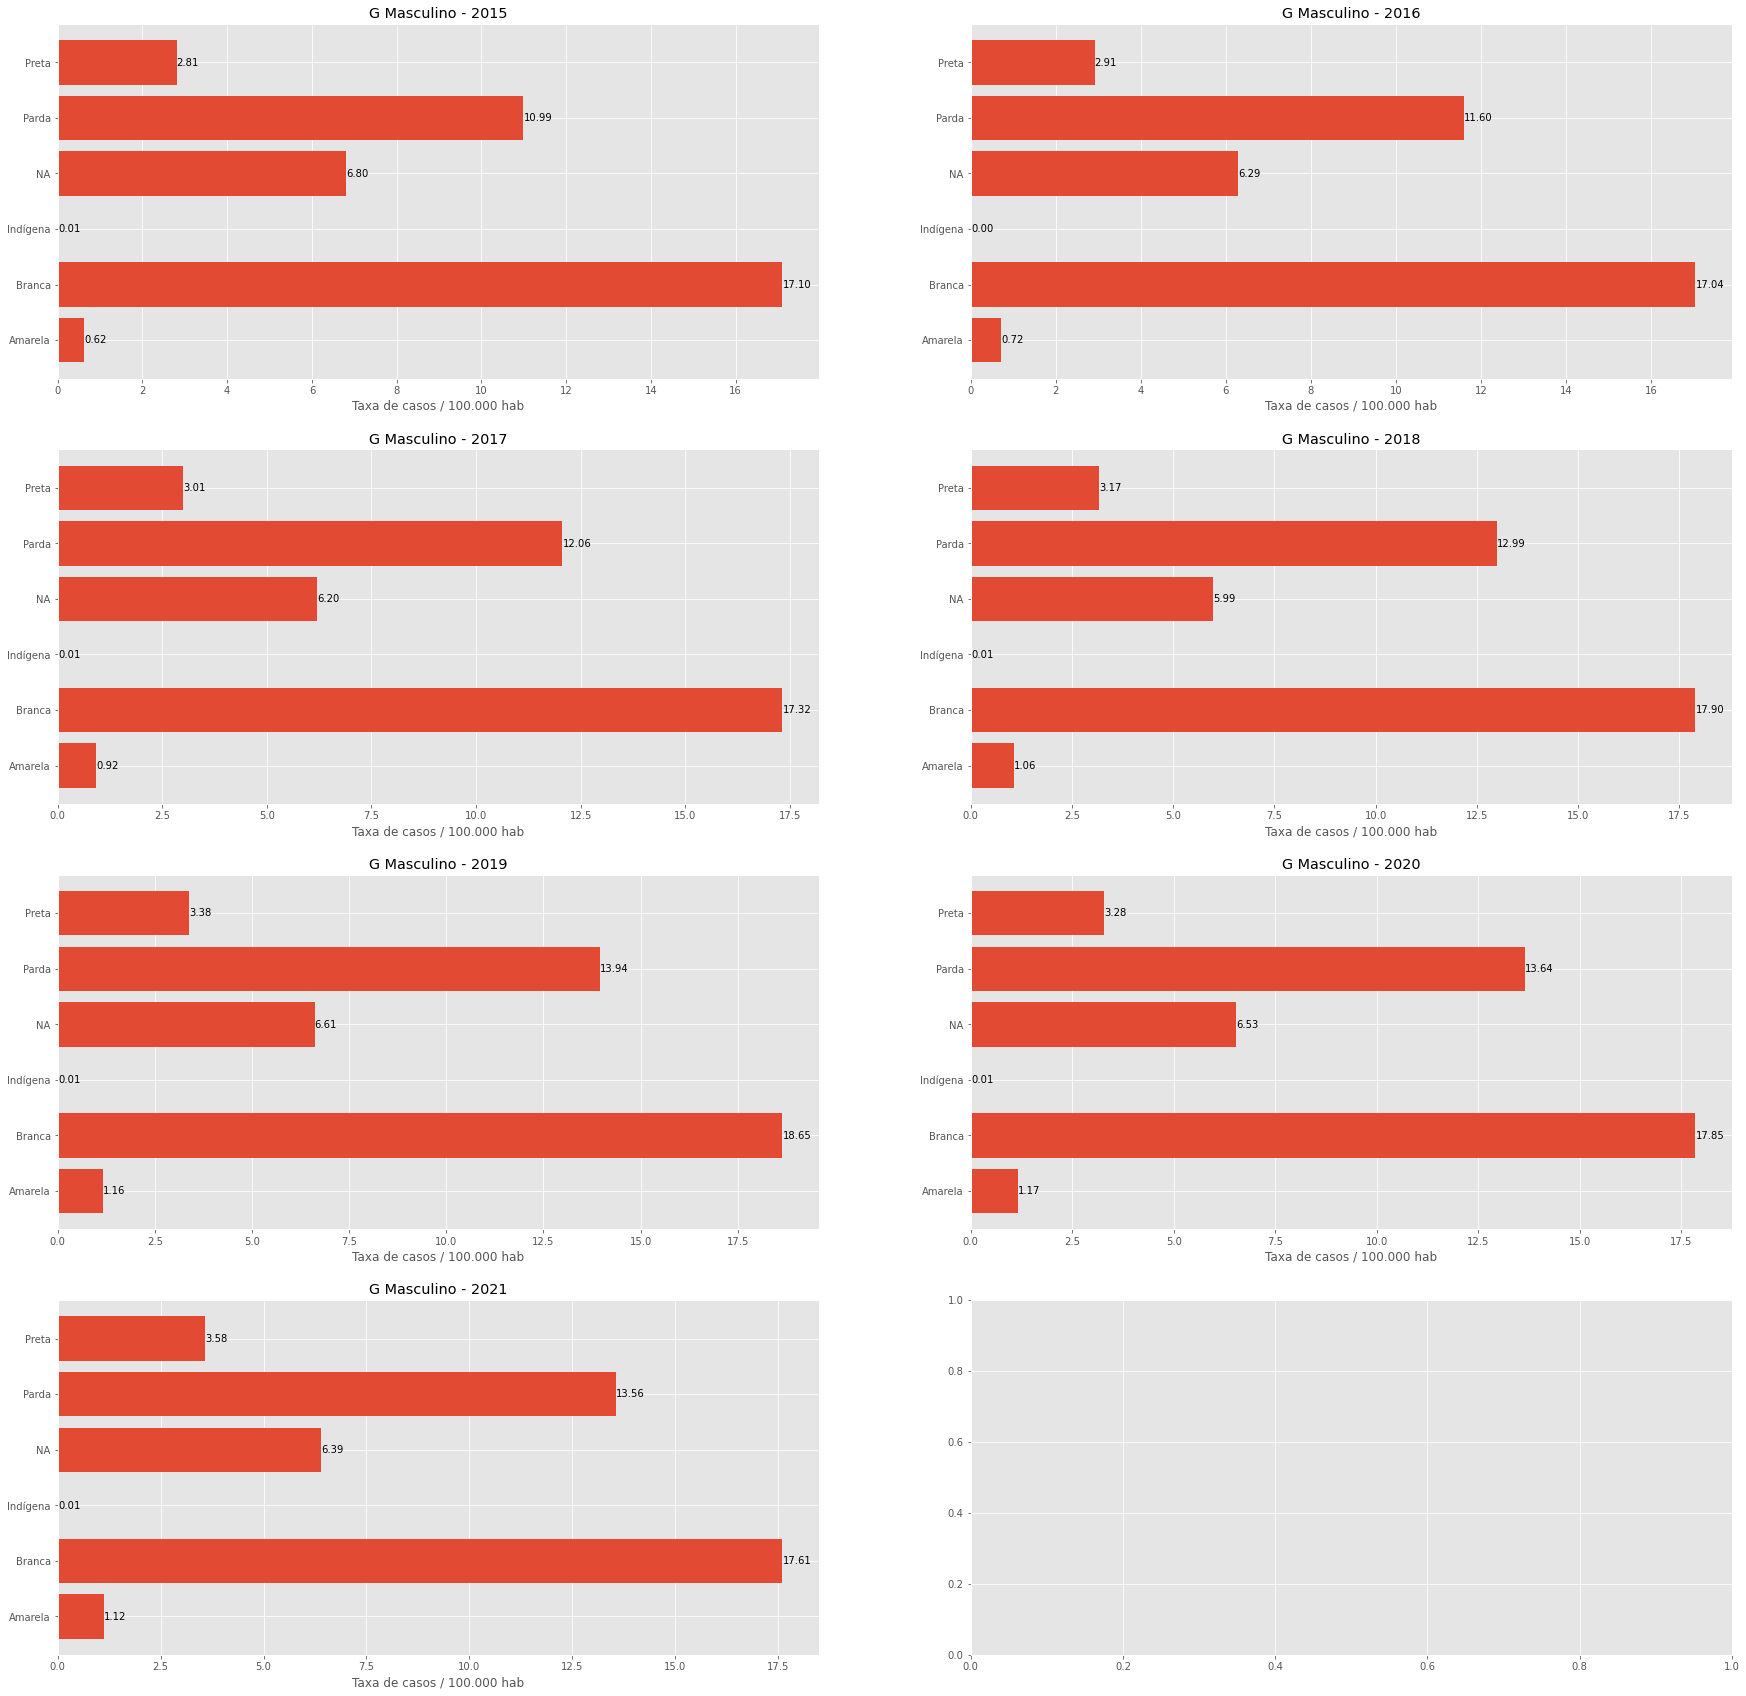

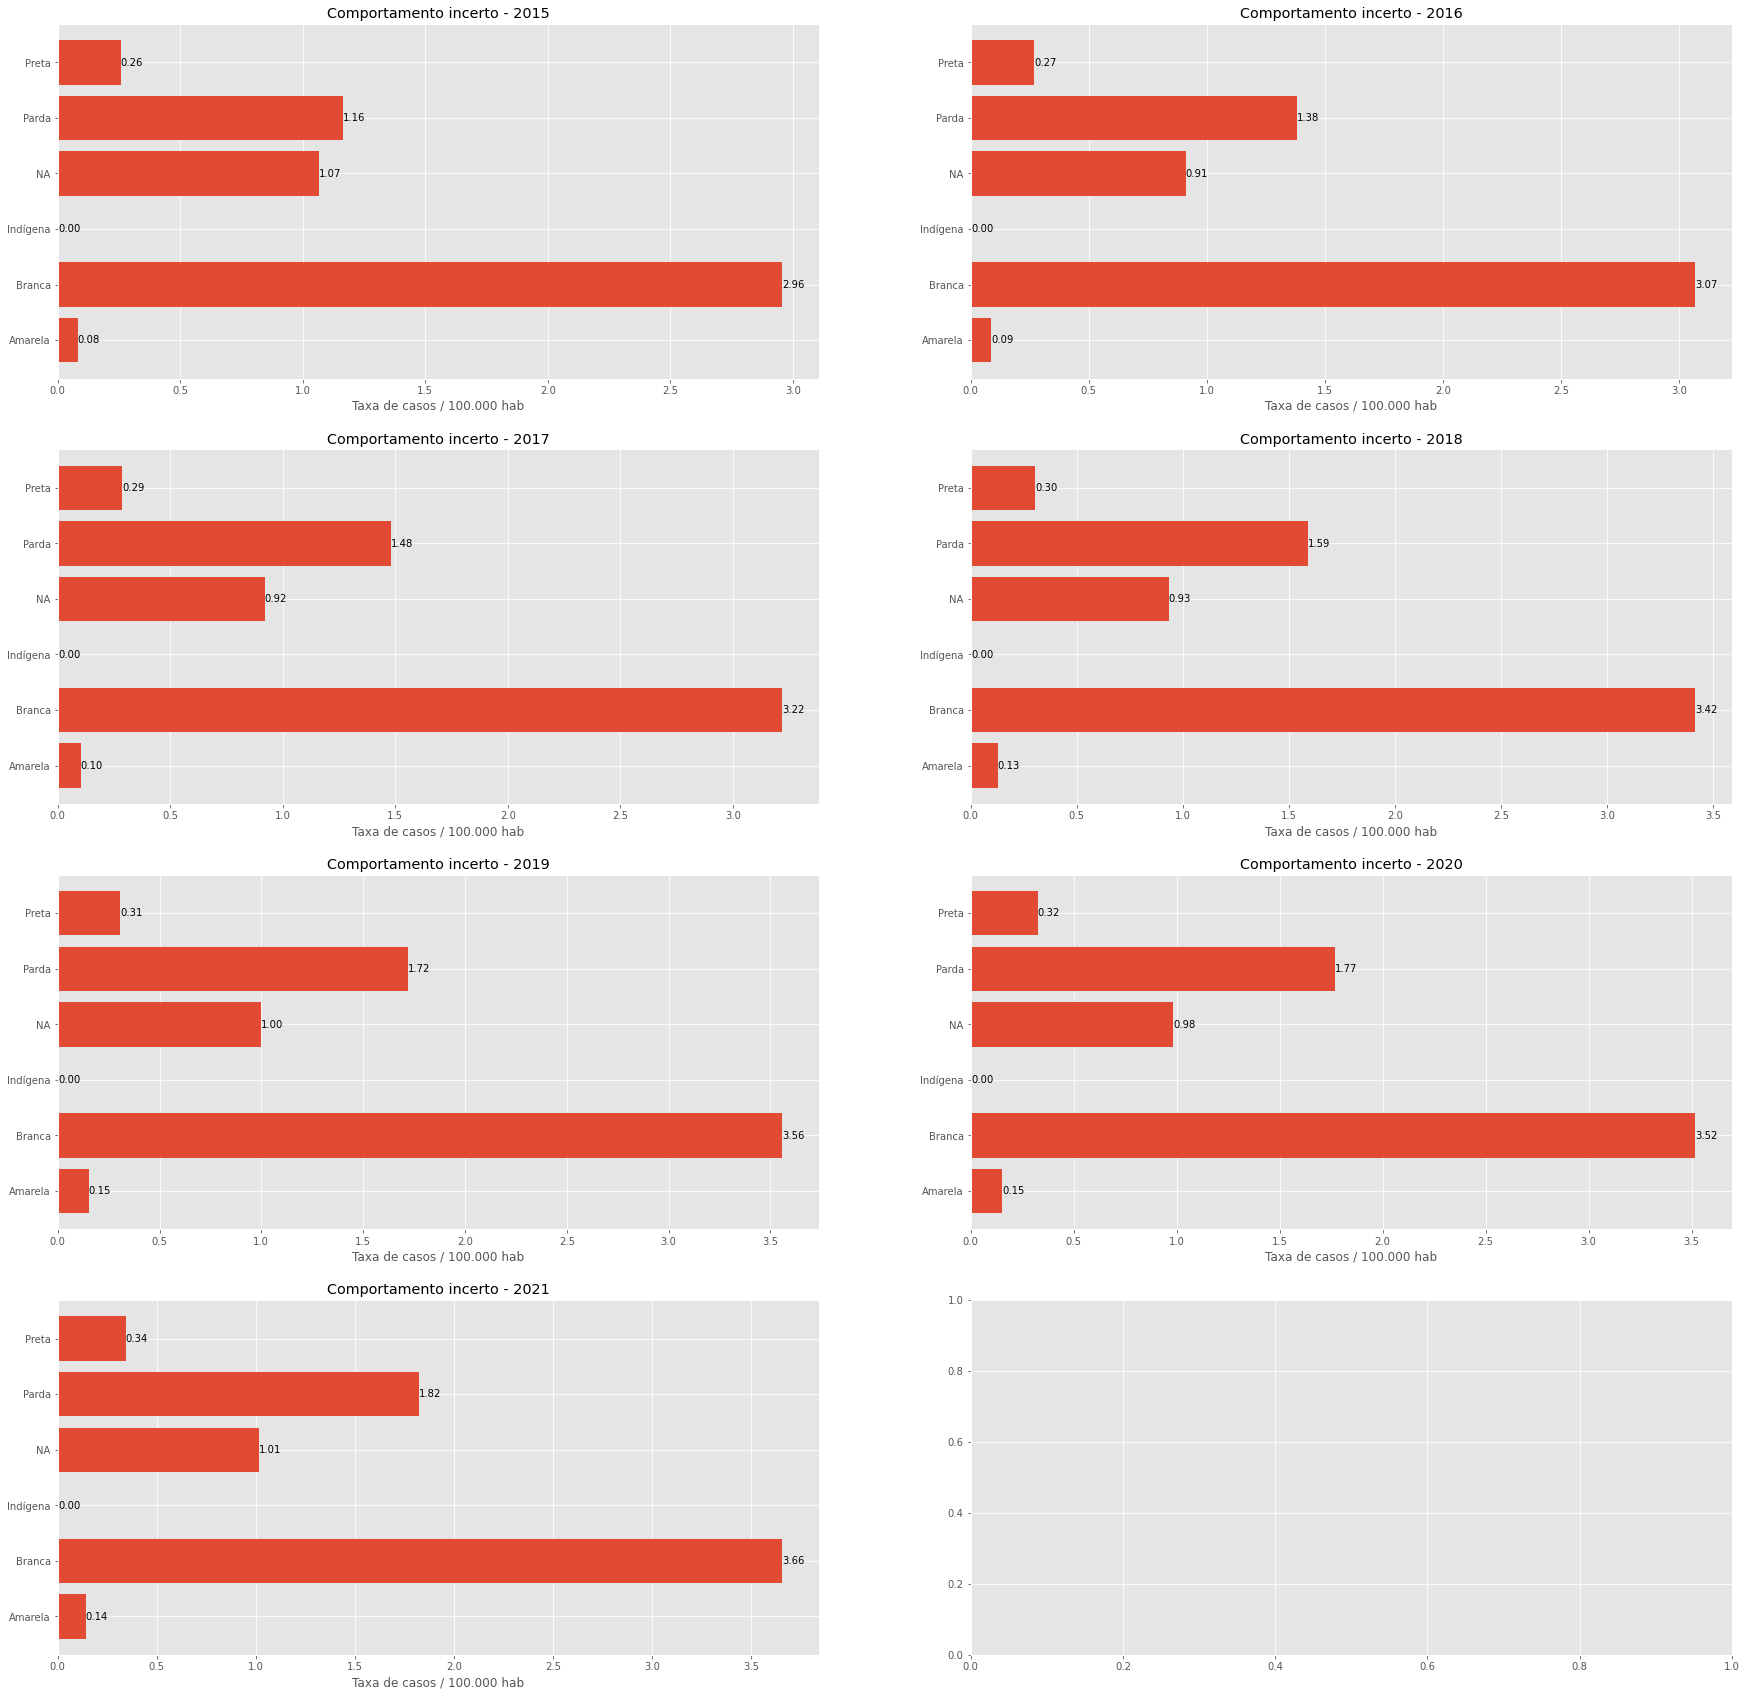

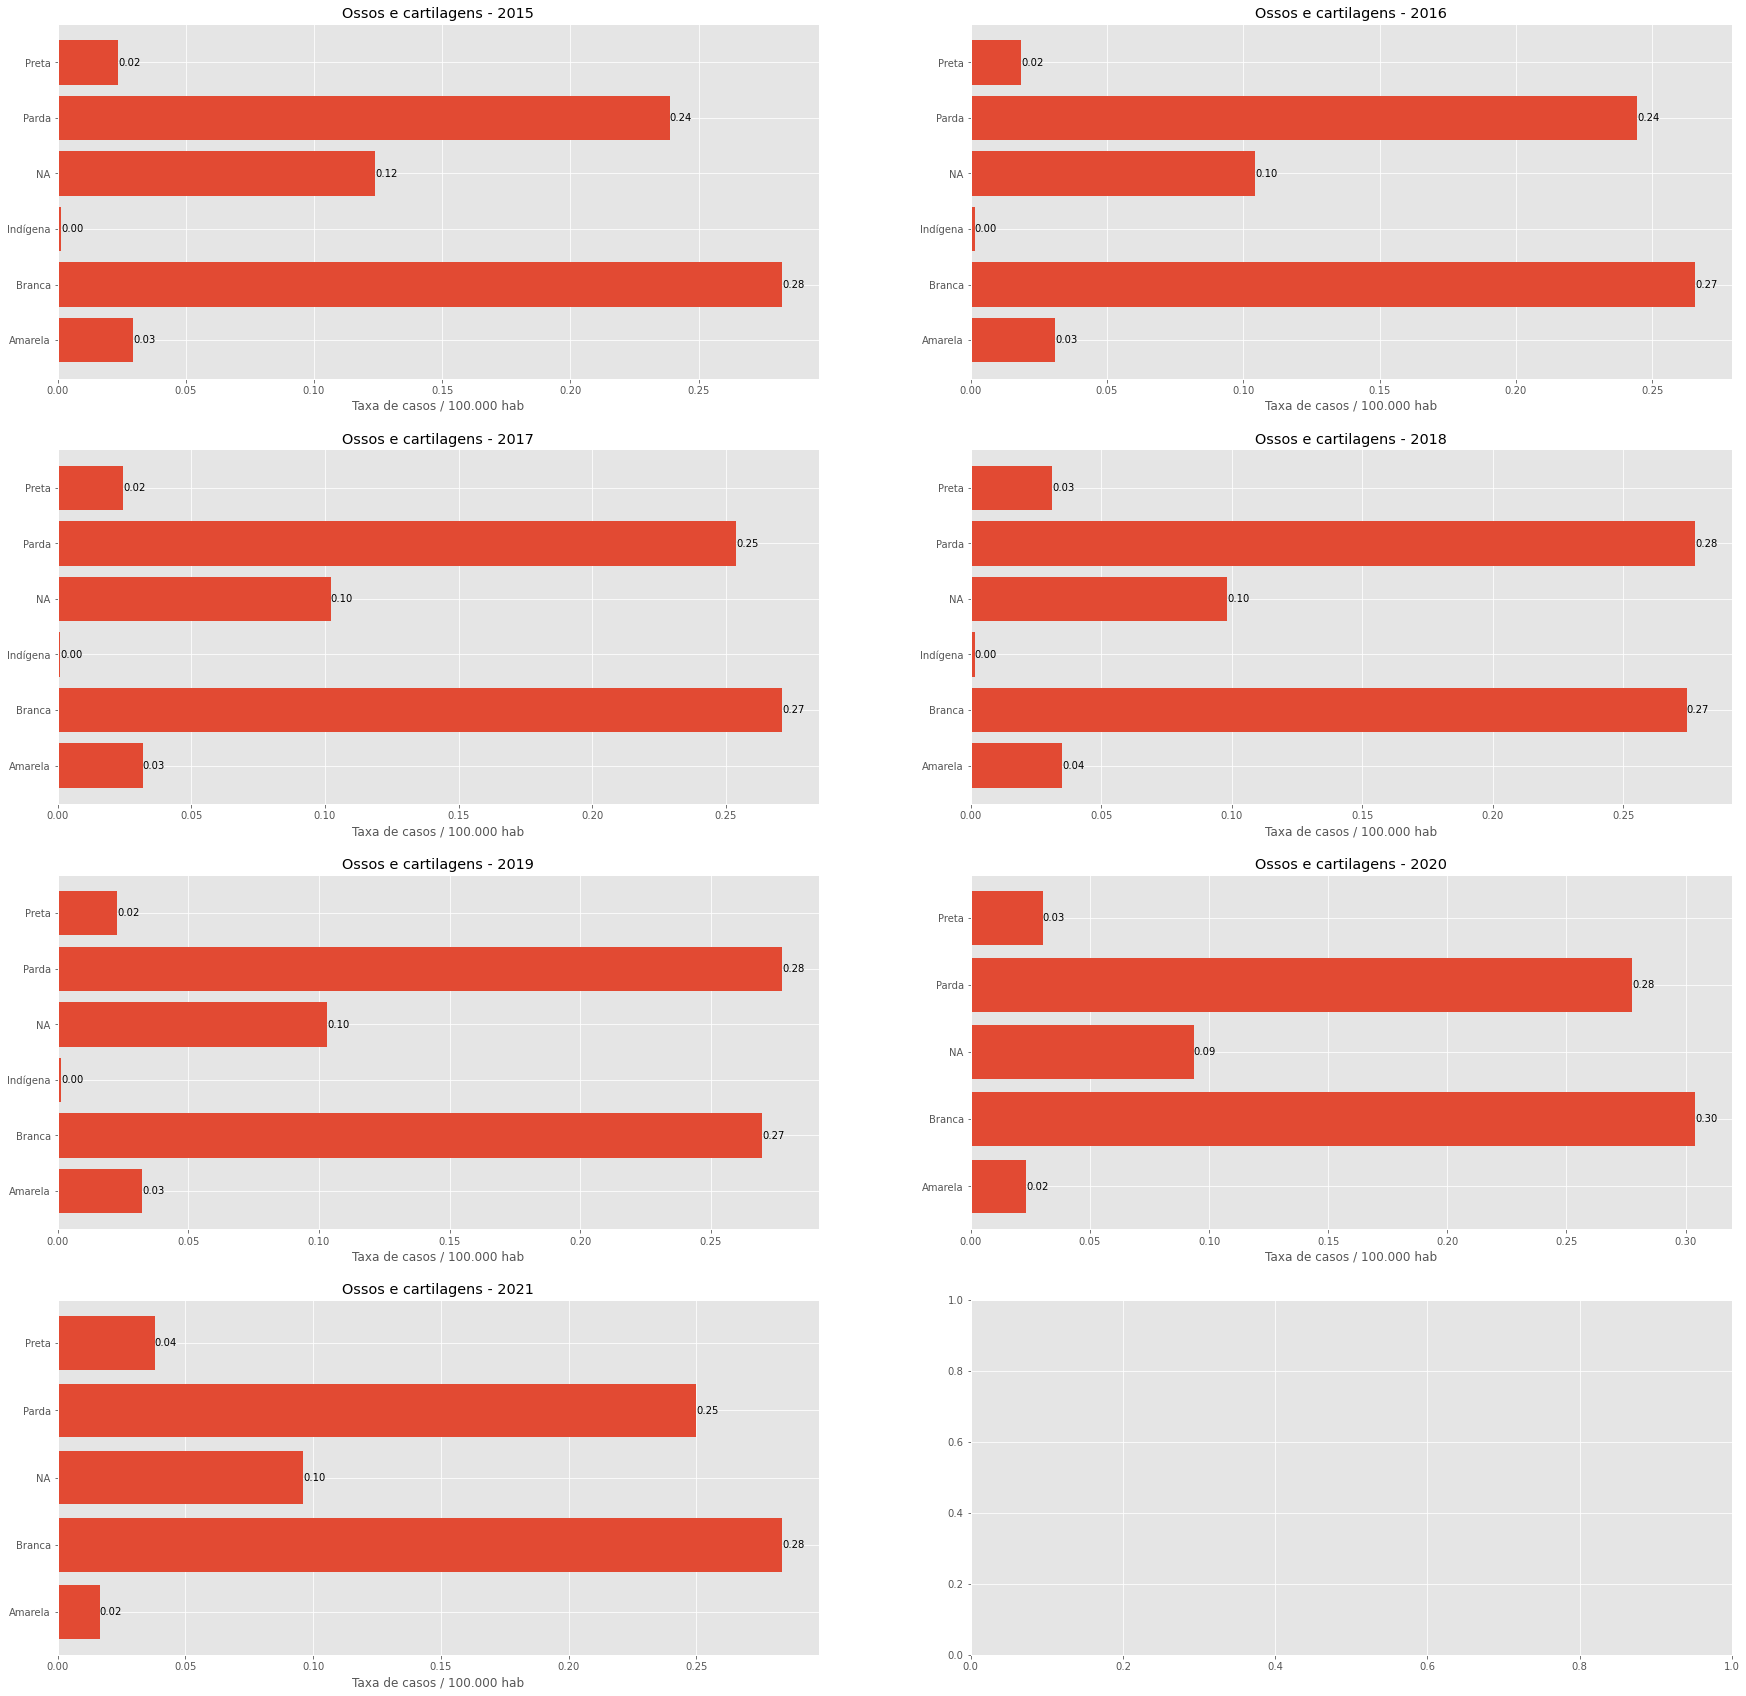

In [21]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça e pelo cid por ano
df_graph = df_raca_cid_pct.filter(df_raca_cid_pct.Year > 2014).sort(["Year", "AP_RACACOR"]).toPandas()
years = df_graph.sort_values("Year").Year.unique()
cids = df_graph.CID.unique()

for cid in cids:
    plt.style.use("ggplot")
    fig, axs = plt.subplots(4, 2, figsize=(30, 30))
    for year, ax in zip(years, axs.ravel()):
        df = df_graph[df_graph["CID"] == cid]
        df = df[df["Year"] == year]
        y_pos = df.AP_RACACOR
        y = np.arange(len(y_pos))
        x_pos = df.Taxa
        barhs = ax.barh(y, x_pos, align='center')
        ax.set_yticks(y)
        ax.set_yticklabels(y_pos)
        ax.set_xlabel('Taxa de casos / 100.000 hab')
        ax.set_title(f"{cid} - {year}")
        ax.bar_label(barhs, fmt='%.2f')

#plt.show()

**<h2>Número de pacientes por 100000 habitantes por raça por sexo por ano</h2>**

In [22]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça e pelo sexo por ano
df_raca_sexo_pct = df_final.groupBy("Year", "AP_RACACOR", "AP_SEXO").agg(F.count("AP_CNSPCN").alias("N_Raca"))
df_raca_sexo_pct = df_raca_sexo_pct.join(df_pop_br, df_raca_sexo_pct.Year == df_pop_br.ano, 'inner').select("Year", "AP_RACACOR", "AP_SEXO", "N_Raca", "populacao")
df_raca_sexo_pct = df_raca_sexo_pct.withColumn("Taxa", ( df_raca_sexo_pct.N_Raca / df_raca_sexo_pct.populacao ) * 100000 )
df_raca_sexo_pct.sort("Year").show()

+----+----------+-------+------+---------+--------------------+
|Year|AP_RACACOR|AP_SEXO|N_Raca|populacao|                Taxa|
+----+----------+-------+------+---------+--------------------+
|2014|   Amarela|      F|  1403|202768562|  0.6919218571959888|
|2014|  Indígena|      F|     8|202768562|0.003945384788002787|
|2014|  Indígena|      M|     8|202768562|0.003945384788002787|
|2014|   Amarela|      M|   878|202768562|  0.4330059804833059|
|2014|     Preta|      M|  3327|202768562|   1.640786898710659|
|2014|     Parda|      M| 15074|202768562|   7.434091286794252|
|2014|     Preta|      F|  3769|202768562|   1.858769408247813|
|2014|     Parda|      F| 23394|202768562|   11.53729146631715|
|2014|        NA|      F| 16813|202768562|   8.291719305086358|
|2014|    Branca|      F| 50071|202768562|  24.693670215010943|
|2014|    Branca|      M| 26827|202768562|  13.230354713468845|
|2014|        NA|      M| 10222|202768562|   5.041215412870561|
|2015|        NA|      M| 28639|20445004

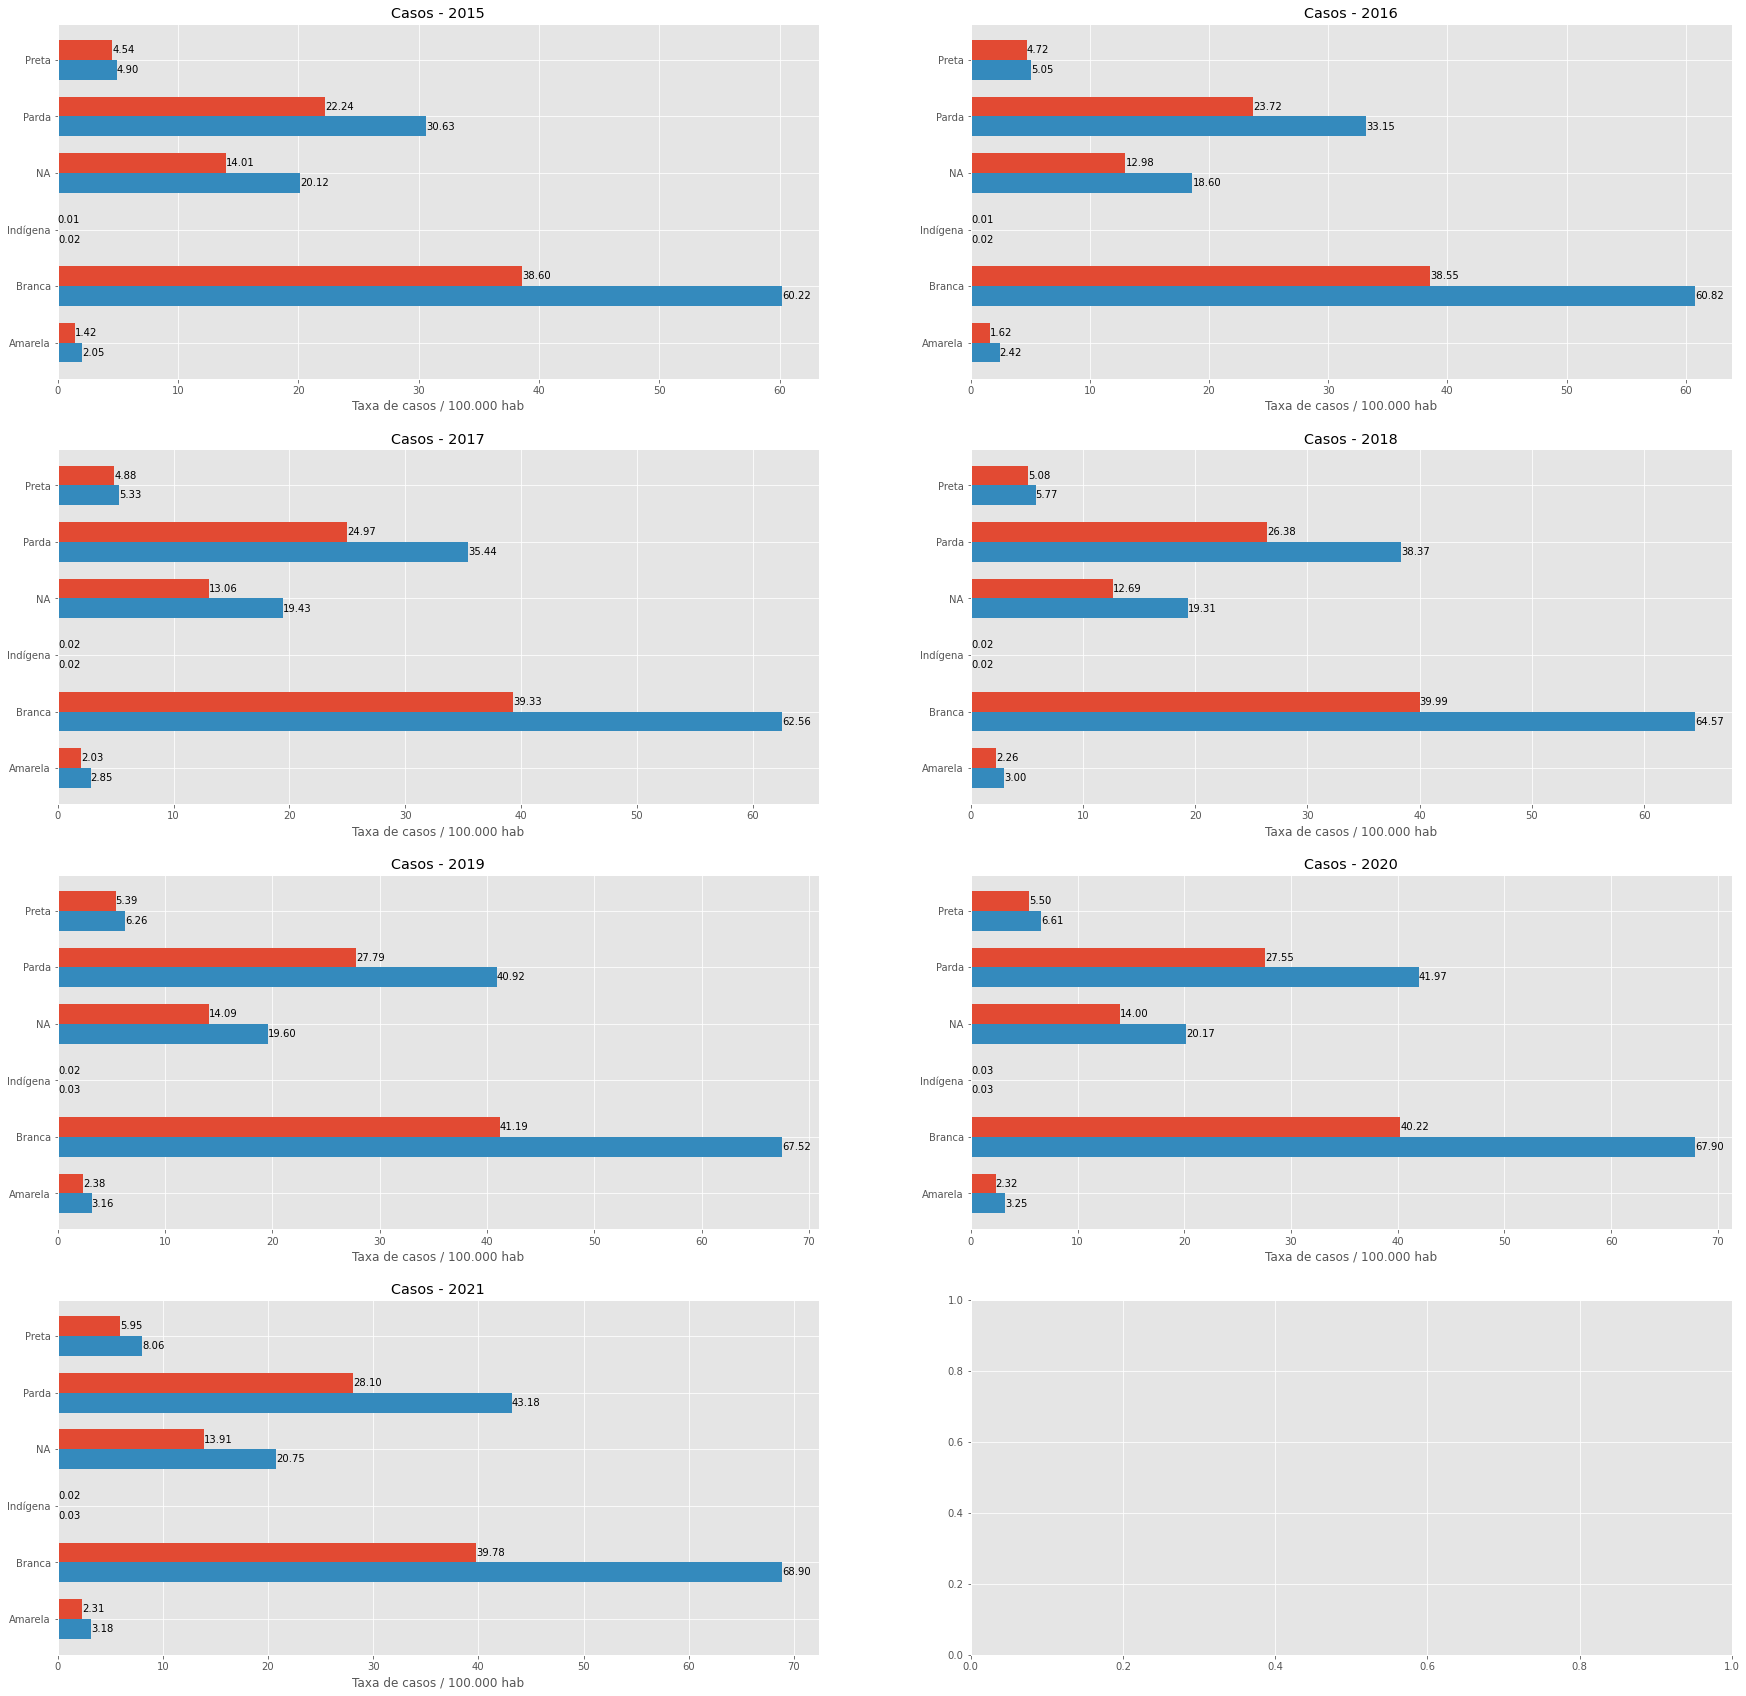

In [23]:
# Grafico da taxa de pacientes por 100000 habitantes por ano agrupado pela raça e pelo sexo por ano
df_graph = df_raca_sexo_pct.filter(df_raca_sexo_pct.Year > 2014).sort("AP_RACACOR").toPandas()
years = df_graph.sort_values("Year").Year.unique()

plt.style.use("ggplot")
fig, axs = plt.subplots(4, 2, figsize=(30, 30))

for year, ax in zip(years, axs.ravel()):
    df = df_graph[df_graph["Year"] == year]
    men = df[df.AP_SEXO == "M"]
    women = df[df.AP_SEXO == "F"]
    labels = df.AP_RACACOR.unique()
    y = np.arange(len(labels))
    width = 0.35
    rects1 = ax.barh(y + width/2, men.Taxa, width, label="Homens")
    rects2 = ax.barh(y - width/2, women.Taxa, width, label="Mulheres")
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Taxa de casos / 100.000 hab')
    ax.set_title(f"Casos - {year}")
    ax.bar_label(rects1, fmt='%.2f')
    ax.bar_label(rects2, fmt='%.2f')

plt.show()

**<h2>Média de idade por sexo por ano</h2>**

In [18]:
# Media de idade do sexo fem e masc por ano
media_sexo = df_final.groupBy("Year", "AP_Sexo").agg(F.mean("AP_NUIDADE").alias("media_idade")).sort("Year")
media_sexo.show()

+----+-------+------------------+
|Year|AP_Sexo|       media_idade|
+----+-------+------------------+
|2015|      F| 57.05886875737005|
|2015|      M| 63.71020558340615|
|2016|      M|63.759825822050836|
|2016|      F| 57.18390903273136|
|2017|      F| 57.28602148153895|
|2017|      M| 63.80693338554584|
|2018|      F|57.385116732548404|
|2018|      M| 63.98407259980361|
|2019|      F|57.582976064371906|
|2019|      M|  64.2694609582853|
|2020|      M| 64.18843547583458|
|2020|      F| 57.65887613245861|
|2021|      M| 64.25639882410583|
|2021|      F|57.724387223942784|
+----+-------+------------------+



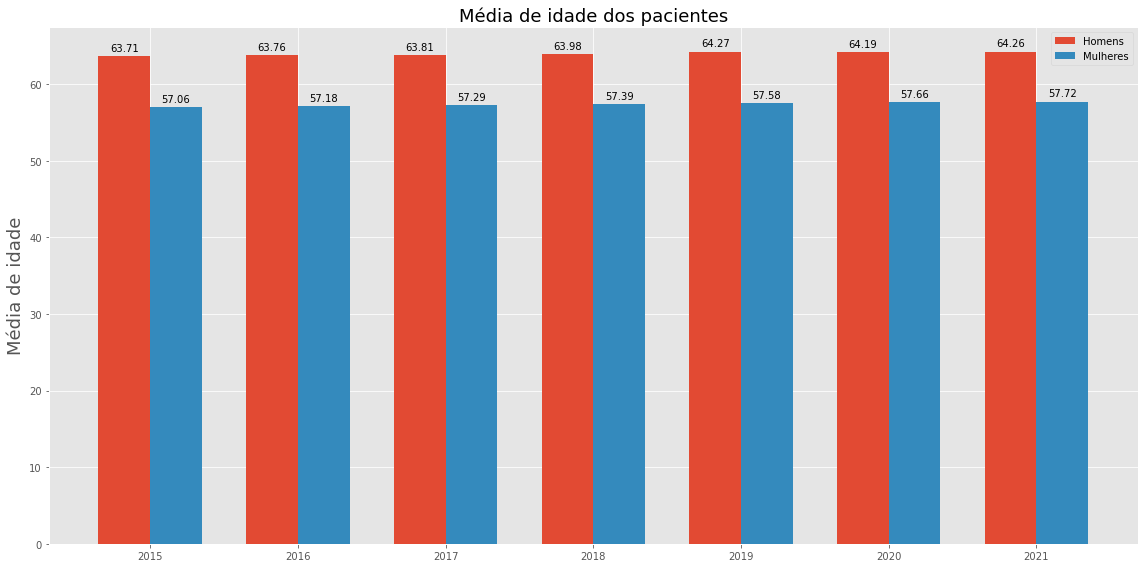

In [19]:
# Media de idade do sexo fem e masc por ano
df_graph = media_sexo.filter(media_sexo.Year > 2014).sort("Year").toPandas()
men = df_graph[df_graph.AP_Sexo == "M"].media_idade
women = df_graph[df_graph.AP_Sexo == "F"].media_idade

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Média de idade', fontdict={'fontsize': 18})
ax.set_title('Média de idade dos pacientes', fontdict={'fontsize': 18})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Média de idade por sexo por CID por ano</h2>**

In [26]:
# Media de idade do sexo fem e masc agrupados por cid e por ano
media_sexo_cid = df_final.groupBy("Year", "CID", "AP_Sexo").agg(F.mean("AP_NUIDADE").alias("media_idade")).sort("Year")
media_sexo_cid.show()

+----+--------------------+-------+------------------+
|Year|                 CID|AP_Sexo|       media_idade|
+----+--------------------+-------+------------------+
|2014|           Endocrino|      M|           23.2375|
|2014|Comportamento inc...|      M| 64.74510813594233|
|2014|              Cabeça|      F| 56.80099502487562|
|2014|                Pele|      F|55.170833333333334|
|2014|      Não específico|      M|63.481521739130436|
|2014|              Hemato|      F|49.340058102001294|
|2014|               Torax|      M|61.556858745537994|
|2014|              Hemato|      M|46.171596020171734|
|2014|Comportamento inc...|      F| 64.61771720613288|
|2014|     Sistema nervoso|      M|20.217391304347824|
|2014|           Endocrino|      F| 31.78787878787879|
|2014|      Não específico|      F| 57.28843537414966|
|2014|          G Feminino|      F|54.732875088883624|
|2014|      Trato urinario|      M| 61.27825159914712|
|2014|                Mama|      M| 63.38263229308006|
|2014|    

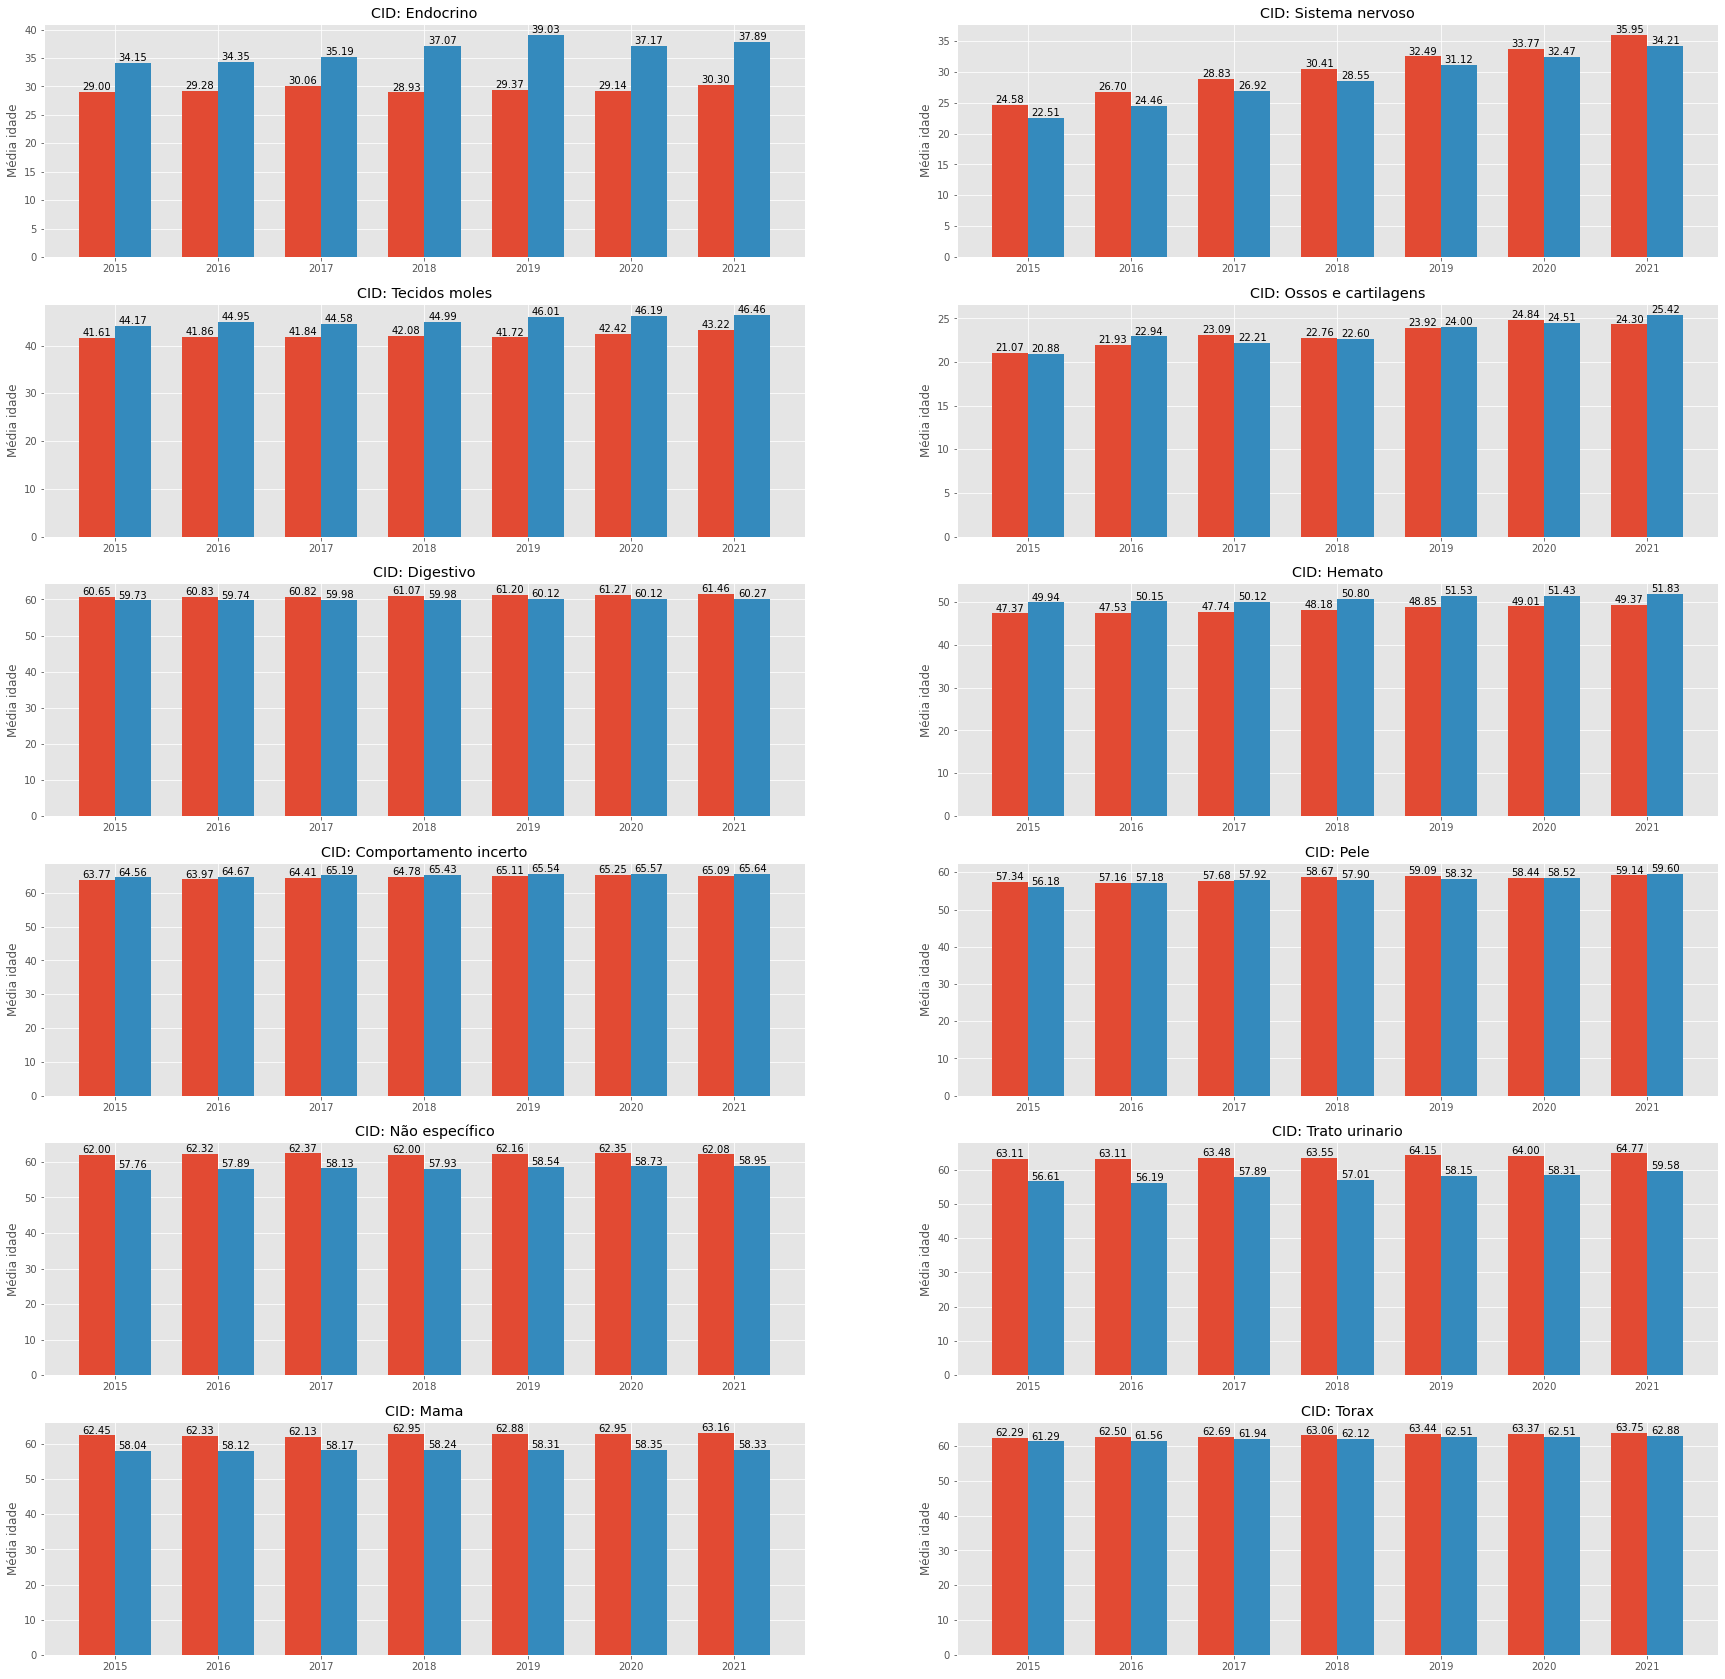

In [27]:
# Grafico da média das idades agrupado pelo cid e por ano
df_graph = media_sexo_cid.filter(media_sexo_cid.Year > 2014).sort("Year").toPandas()
cids = ['Endocrino', 'Sistema nervoso', 'Tecidos moles',
       'Ossos e cartilagens', 'Digestivo', 'Hemato',
       'Comportamento incerto', 'Pele', 'Não específico',
       'Trato urinario', 'Mama', 'Torax', 'Cabeça']

#df_graph.CID.unique()

plt.style.use("ggplot")
fig, axs = plt.subplots(6, 2, figsize=(30, 30))

for cid, ax in zip(cids, axs.ravel()):
    df = df_graph[df_graph["CID"] == cid]
    men = df[df.AP_Sexo == "M"]
    women = df[df.AP_Sexo == "F"]
    labels = df.Year.unique()
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, men.media_idade, width, label="Homens")
    rects2 = ax.bar(x + width/2, women.media_idade, width, label="Mulheres")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Média idade')
    ax.set_title(f"CID: {cid}")
    ax.bar_label(rects1, fmt='%.2f')
    ax.bar_label(rects2, fmt='%.2f')

plt.show()

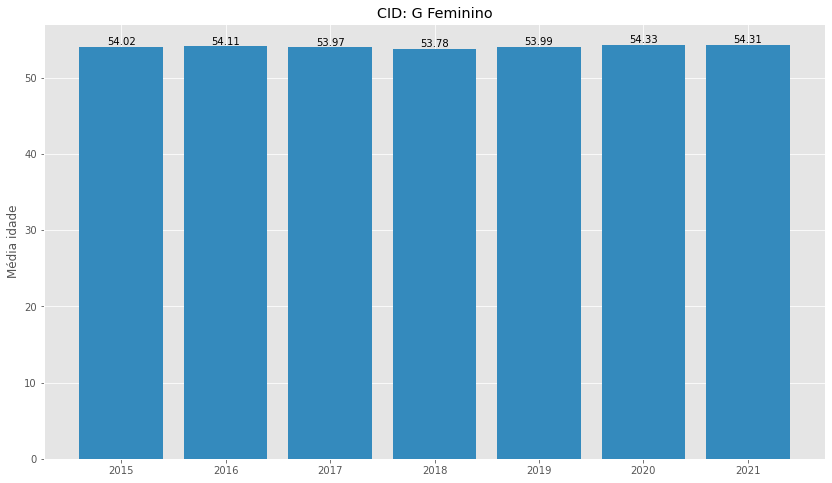

In [28]:
# Grafico da média das idades agrupado pelo cid G Feminino e por ano
df_graph = media_sexo_cid.filter(media_sexo_cid.Year > 2014).sort("Year").toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Feminino"]
women = df[df.AP_Sexo == "F"]
labels = df.Year.unique()
x = np.arange(len(labels))
rects2 = ax.bar(x, women.media_idade, color="#348ABD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Média idade')
ax.set_title("CID: G Feminino")
ax.bar_label(rects2, fmt='%.2f')

plt.show()

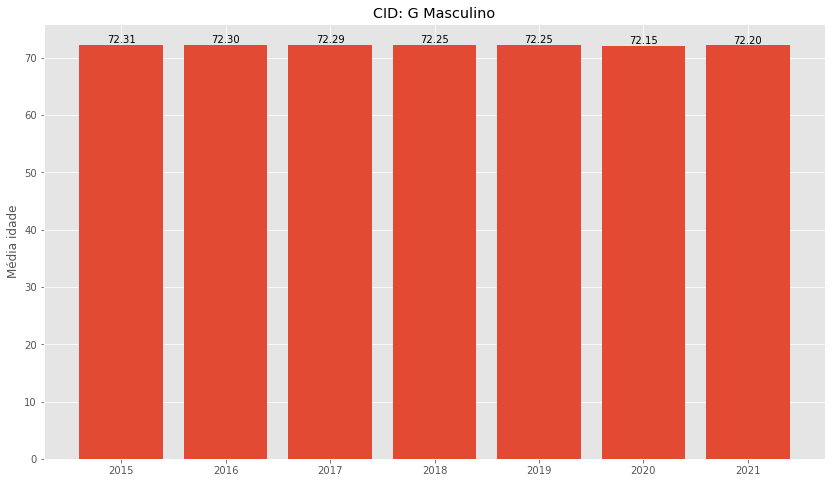

In [29]:
# Grafico da média das idades agrupado pelo cid G Masculino e por ano
df_graph = media_sexo_cid.filter(media_sexo_cid.Year > 2014).sort("Year").toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Masculino"]
women = df[df.AP_Sexo == "M"]
labels = df.Year.unique()
x = np.arange(len(labels))
rects2 = ax.bar(x, women.media_idade)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Média idade')
ax.set_title("CID: G Masculino")
ax.bar_label(rects2, fmt='%.2f')

plt.show()

**<h2>Pirâmide populacional</h2>**

In [30]:
# Contagem de pacientes por idade
idade = df_final.groupBy(["AP_NUIDADE", "AP_SEXO"]).agg(F.count("AP_NUIDADE").alias("contagem_idade")).sort(["AP_SEXO", "AP_NUIDADE"]).toPandas()
idade

AP_NUIDADE AP_SEXO  contagem_idade
0             0       F             118
1             1       F            1737
2             2       F            2276
3             3       F            2484
4             4       F            2449
..          ...     ...             ...
195          95       M             954
196          96       M             671
197          97       M             434
198          98       M             296
199          99       M             181

[200 rows x 3 columns]

In [31]:
idade_F = idade[idade.AP_SEXO == "F"]
idade_M = idade[idade.AP_SEXO == "M"]

In [32]:
# Contagem de idade por intervalo de idade
# age_bins = [0, 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99]
age_bracket = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90+"]
idade_F["intervalo"] = pd.cut(idade_F.AP_NUIDADE, bins=19, labels=age_bracket)
idade_F

/tmp/ipykernel_9843/1523016303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idade_F["intervalo"] = pd.cut(idade_F.AP_NUIDADE, bins=19, labels=age_bracket)


AP_NUIDADE AP_SEXO  contagem_idade intervalo
0            0       F             118       0-4
1            1       F            1737       0-4
2            2       F            2276       0-4
3            3       F            2484       0-4
4            4       F            2449       0-4
..         ...     ...             ...       ...
95          95       F             678       90+
96          96       F             482       90+
97          97       F             344       90+
98          98       F             231       90+
99          99       F             169       90+

[100 rows x 4 columns]

In [33]:
# Agrupar as idades por intervalo e somando
idade_F_final = idade_F.drop("AP_NUIDADE", axis=1)
idade_F_final = idade_F_final.groupby(["intervalo", "AP_SEXO"]).sum("contagem_idade").reset_index()
idade_F_final

intervalo AP_SEXO  contagem_idade
0        0-4       F           11255
1        5-9       F            8008
2      10-14       F            7488
3      15-19       F            7881
4      20-24       F           14930
5      25-29       F           27678
6      30-34       F           59398
7      35-39       F          107082
8      40-44       F          167937
9      45-49       F          292862
10     50-54       F          273069
11     55-59       F          273641
12     60-64       F          256045
13     65-69       F          204409
14     70-74       F          166319
15     75-79       F           79050
16     80-84       F           37720
17     85-89       F           13045
18       90+       F            2896

In [34]:
# Agrupar as idades por intervalo e somando
idade_M["intervalo"] = pd.cut(idade_M.AP_NUIDADE, bins=19, labels=age_bracket)
idade_M_final = idade_M.drop("AP_NUIDADE", axis=1)
idade_M_final = idade_M_final.groupby(["intervalo", "AP_SEXO"]).sum().reset_index()
idade_M_final

/tmp/ipykernel_9843/1831825145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idade_M["intervalo"] = pd.cut(idade_M.AP_NUIDADE, bins=19, labels=age_bracket)


intervalo AP_SEXO  contagem_idade
0        0-4       M           13677
1        5-9       M           10832
2      10-14       M           10098
3      15-19       M           11312
4      20-24       M           15079
5      25-29       M           14987
6      30-34       M           19189
7      35-39       M           25180
8      40-44       M           36245
9      45-49       M           73092
10     50-54       M          100404
11     55-59       M          145565
12     60-64       M          189634
13     65-69       M          208835
14     70-74       M          228125
15     75-79       M          127141
16     80-84       M           63964
17     85-89       M           20521
18       90+       M            3931

In [35]:
idade_final = pd.merge(idade_M_final, idade_F_final, on="intervalo")
idade_final

intervalo AP_SEXO_x  contagem_idade_x AP_SEXO_y  contagem_idade_y
0        0-4         M             13677         F             11255
1        5-9         M             10832         F              8008
2      10-14         M             10098         F              7488
3      15-19         M             11312         F              7881
4      20-24         M             15079         F             14930
5      25-29         M             14987         F             27678
6      30-34         M             19189         F             59398
7      35-39         M             25180         F            107082
8      40-44         M             36245         F            167937
9      45-49         M             73092         F            292862
10     50-54         M            100404         F            273069
11     55-59         M            145565         F            273641
12     60-64         M            189634         F            256045
13     65-69         M            208835         F            204409
14     70-74         M            228125         F            166319
15     75-79         M            127141         F             79050
16     80-84         M             63964         F             37720
17     85-89         M             20521         F             13045
18       90+         M              3931         F              2896

In [36]:
# Contar numero de atendimentos por sexo 
df_final.groupBy("AP_Sexo").agg(F.count("AP_Sexo").alias("numero_sexo")).show()

+-------+-----------+
|AP_Sexo|numero_sexo|
+-------+-----------+
|      F|    2010713|
|      M|    1317811|
+-------+-----------+



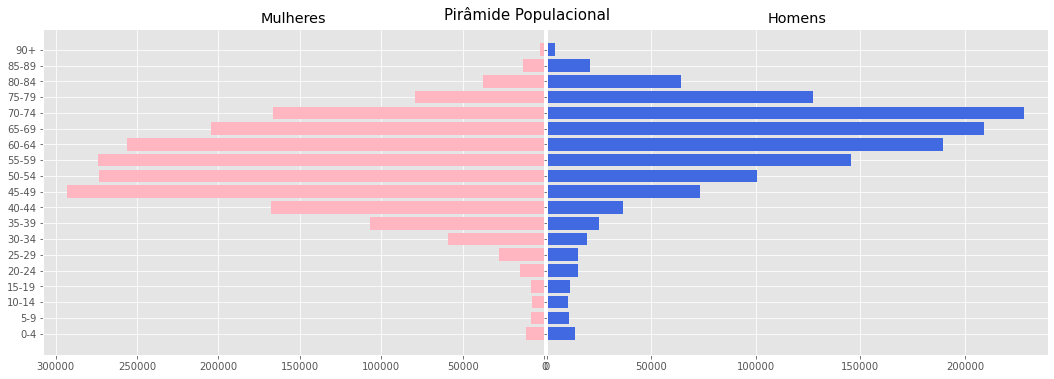

In [37]:
# Piramide populacional dos pacientes
y = range(0, len(idade_final))
x_male = idade_final['contagem_idade_x']
x_female = idade_final['contagem_idade_y']

#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(18, 6))
fig.subplots_adjust(wspace=0.005)

#specify background color and plot title
plt.figtext(.5,.9,"Pirâmide Populacional ", fontsize=15, ha='center')
    
#define male and female bars
rects1 = axes[0].barh(y, x_female, align='center', color='lightpink')
axes[0].set(title='Mulheres')
rects1 = axes[1].barh(y, x_male, align='center', color='royalblue')
axes[1].set(title='Homens')

#adjust grid parameters and specify labels for y-axis
axes[0].set(yticks=y, yticklabels=idade_final['intervalo'])
axes[0].invert_xaxis()

# axes[0].bar_label(rects1, fmt='%.2f')
# axes[1].bar_label(rects2, fmt='%.2f')

#display plot
plt.show()

**<h2>Óbitos por ano</h2>**

In [38]:
# Selecionar os pacientes que foram a óbito
df_obito = df_final.filter(df_final.AP_OBITO == 1)

In [39]:
# Número de óbitos por ano
df_obito_pct = df_obito.groupBy("Year").agg(F.count("AP_CNSPCN").alias("N_Obitos")).filter(df_obito.Year > 2014)
df_obito_pct.sort("Year").show()

+----+--------+
|Year|N_Obitos|
+----+--------+
|2015|   10301|
|2016|   10234|
|2017|   10323|
|2018|   10519|
|2019|   11009|
|2020|   11392|
|2021|   10620|
+----+--------+



No handles with labels found to put in legend.                                  


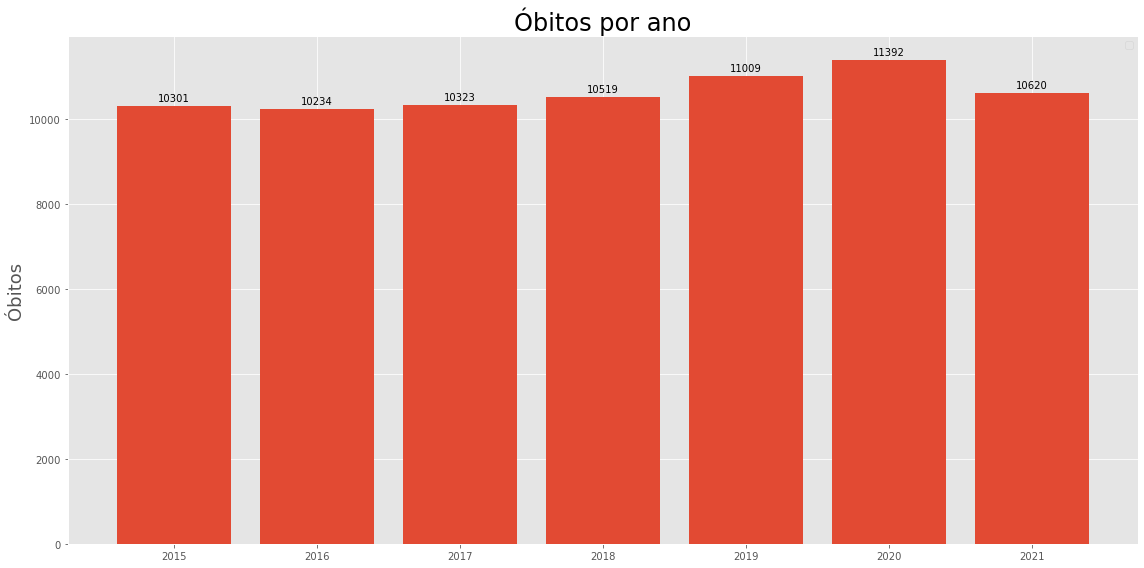

In [40]:
# Gráfico com o número de óbitos por ano
df_graph = df_obito_pct.sort("Year").toPandas()

labels = df_graph.Year
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x, df_graph.N_Obitos)

ax.set_ylabel('Óbitos', fontdict={'fontsize': 18})
ax.set_title('Óbitos por ano', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)

fig.tight_layout()

plt.show()

**<h2>Óbitos por sexo por ano</h2>**

In [41]:
# Número de óbitos agrupados sexo e por ano
df_obito_sexo_pct = df_obito.groupBy("Year", "AP_SEXO").agg(F.count("AP_CNSPCN").alias("N_Obitos")).filter(df_obito.Year > 2014)
df_obito_sexo_pct.sort("Year").show()

+----+-------+--------+
|Year|AP_SEXO|N_Obitos|
+----+-------+--------+
|2015|      M|    5342|
|2015|      F|    4959|
|2016|      F|    5045|
|2016|      M|    5189|
|2017|      M|    5206|
|2017|      F|    5117|
|2018|      M|    5272|
|2018|      F|    5247|
|2019|      M|    5437|
|2019|      F|    5572|
|2020|      F|    5874|
|2020|      M|    5518|
|2021|      M|    5096|
|2021|      F|    5524|
+----+-------+--------+



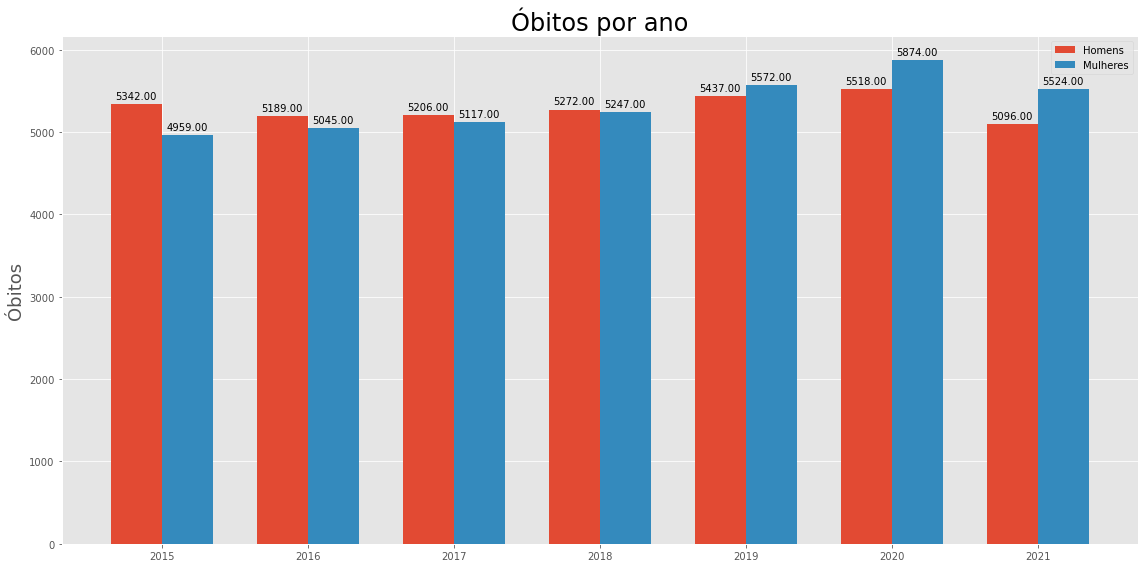

In [42]:
# Grafico de óbito agrupado por sexo e por ano
df_graph = df_obito_sexo_pct.sort("Year").toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].N_Obitos
women = df_graph[df_graph.AP_SEXO == "F"].N_Obitos

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Óbitos', fontdict={'fontsize': 18})
ax.set_title('Óbitos por ano', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Óbitos por raça por ano</h2>**

In [43]:
# Grafico de óbitos por raça por ano
df_obito_raca_pct = df_obito.groupBy("Year", "AP_RACACOR").agg(F.count("AP_CNSPCN").alias("N_Obito")).filter(df_obito.Year > 2014)
df_obito_raca_pct.sort("Year").show()

+----+----------+-------+
|Year|AP_RACACOR|N_Obito|
+----+----------+-------+
|2015|   Amarela|     77|
|2015|    Branca|   5459|
|2015|  Indígena|      2|
|2015|     Preta|    455|
|2015|        NA|   1632|
|2015|     Parda|   2676|
|2016|     Parda|   2769|
|2016|  Indígena|      3|
|2016|   Amarela|     66|
|2016|    Branca|   5197|
|2016|        NA|   1721|
|2016|     Preta|    478|
|2017|     Parda|   3041|
|2017|    Branca|   5118|
|2017|        NA|   1641|
|2017|  Indígena|      5|
|2017|   Amarela|     69|
|2017|     Preta|    449|
|2018|    Branca|   5390|
|2018|     Preta|    493|
+----+----------+-------+
only showing top 20 rows



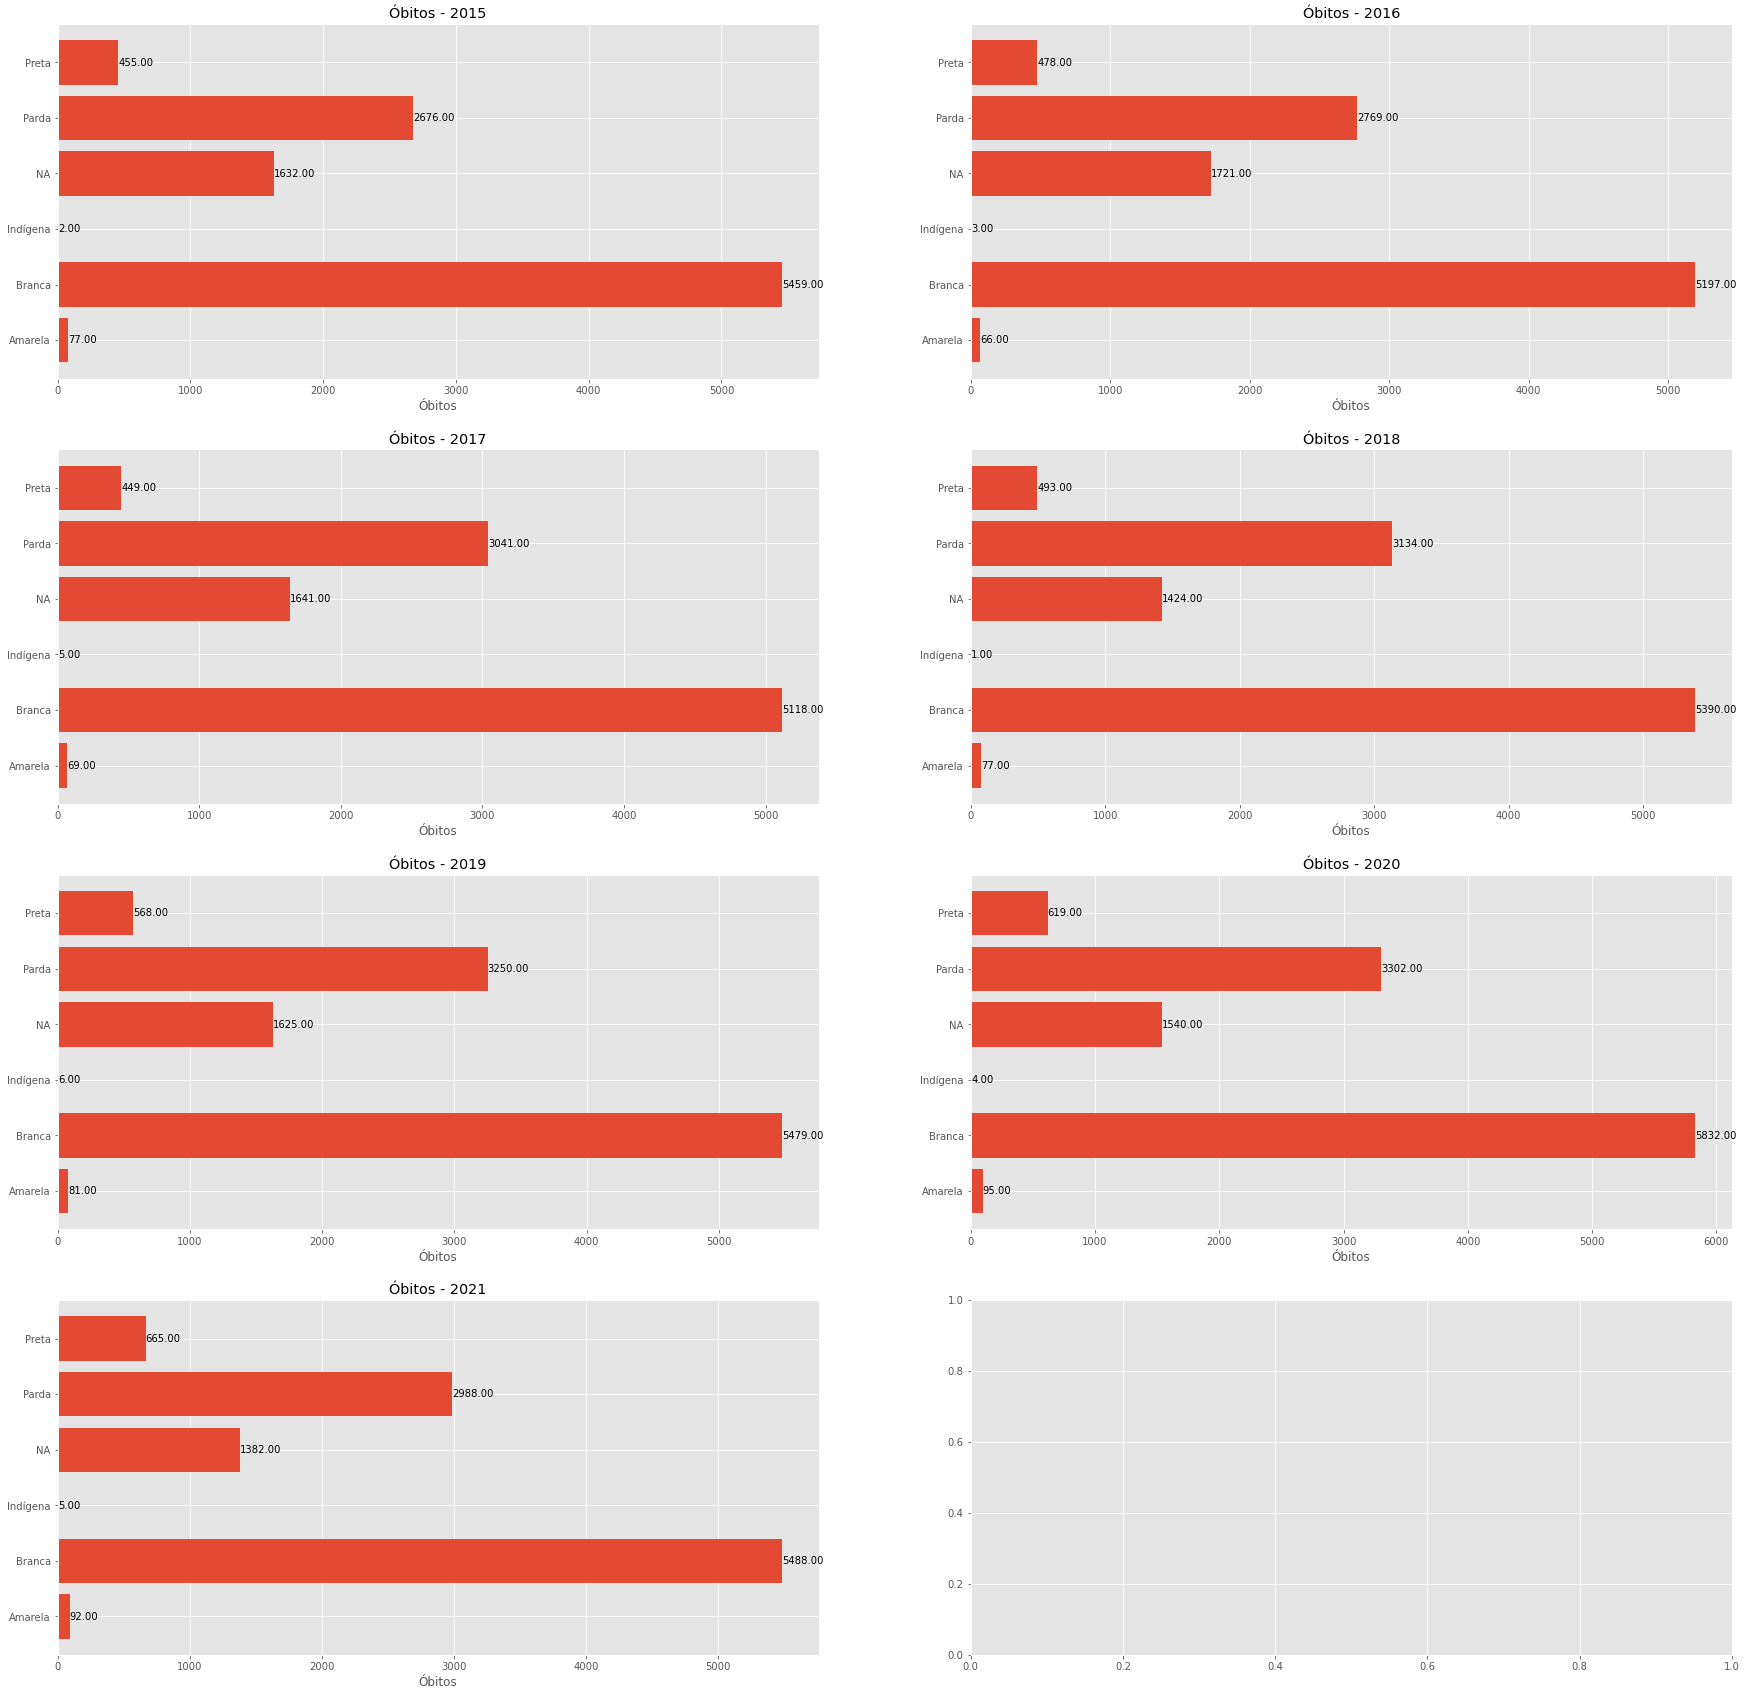

In [44]:
# Grafico de óbitos por raça por ano
df_graph = df_obito_raca_pct.sort("AP_RACACOR").toPandas()
years = df_graph.sort_values("Year").Year.unique()

fig, axs = plt.subplots(4, 2, figsize=(30, 30))

for year, ax in zip(years, axs.ravel()):
    df = df_graph[df_graph["Year"] == year]
    y_pos = df.AP_RACACOR
    y = np.arange(len(y_pos))
    x_pos = df.N_Obito
    barhs = ax.barh(y, x_pos, align='center')
    ax.set_yticks(y)
    ax.set_yticklabels(y_pos)
    ax.set_xlabel('Óbitos')
    ax.set_title(f"Óbitos - {year}")
    ax.bar_label(barhs, fmt='%.2f')

plt.show()

**<h2>Óbitos por CID por ano</h2>**

In [45]:
# Número de óbitos agrupado pelo cid por ano
df_obito_cid_pct = df_obito.groupBy("Year", "CID").agg(F.count("AP_CNSPCN").alias("N_Obitos")).filter(df_obito.Year > 2014)
df_obito_cid_pct.sort("Year").show()

+----+--------------------+--------+
|Year|                 CID|N_Obitos|
+----+--------------------+--------+
|2015|              Hemato|    1763|
|2015|              Cabeça|     536|
|2015|       Tecidos moles|     224|
|2015|           Endocrino|      42|
|2015| Ossos e cartilagens|      94|
|2015|     Sistema nervoso|      96|
|2015|                Pele|     107|
|2015|          G Feminino|     611|
|2015|Comportamento inc...|     139|
|2015|               Torax|    1132|
|2015|      Trato urinario|     153|
|2015|      Não específico|     447|
|2015|                Mama|    1547|
|2015|           Digestivo|    2517|
|2015|         G Masculino|     893|
|2016| Ossos e cartilagens|      73|
|2016|          G Feminino|     675|
|2016|           Endocrino|      44|
|2016|     Sistema nervoso|      82|
|2016|         G Masculino|     914|
+----+--------------------+--------+
only showing top 20 rows



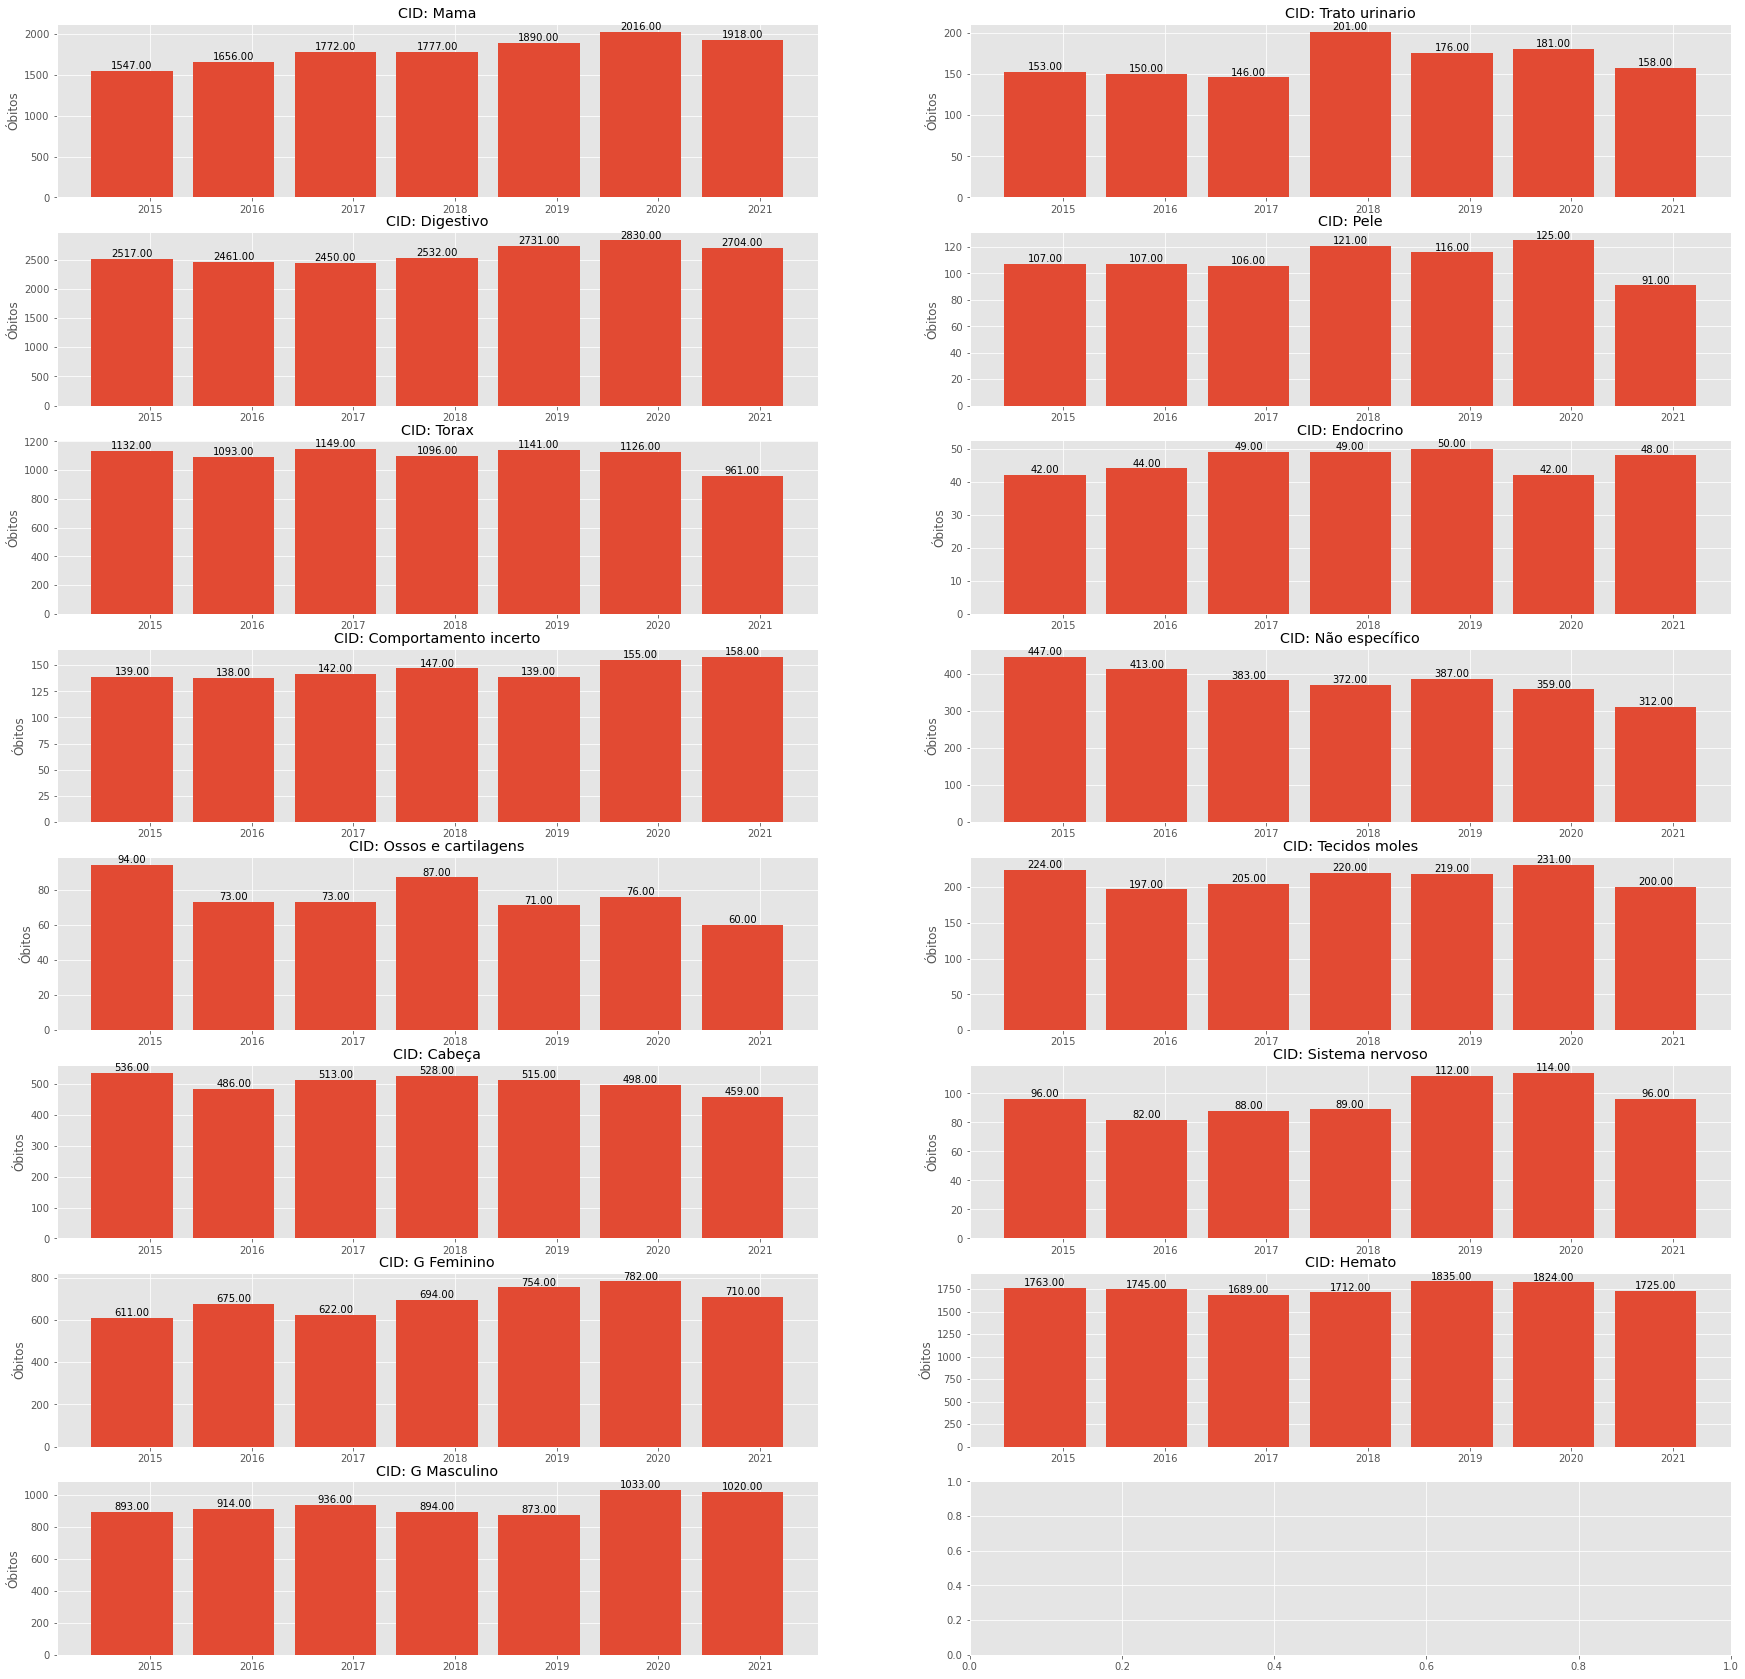

In [46]:
# Gráfico da taxa de óbito agrupado pelo cid por ano 
df_graph = df_obito_cid_pct.sort("Year").toPandas()
cids = df_graph.CID.unique()

fig, axs = plt.subplots(8, 2, figsize=(30, 30))

for cid, ax in zip(cids, axs.ravel()):
    df = df_graph[df_graph["CID"] == cid]
    labels = df.Year.unique()
    x = np.arange(len(labels))
    rects1 = ax.bar(x - width/2, df.N_Obitos)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Óbitos')
    ax.set_title(f"CID: {cid}")
    ax.bar_label(rects1, fmt='%.2f')

plt.show()

**<h2>Porcedimentos por CID</h2>**

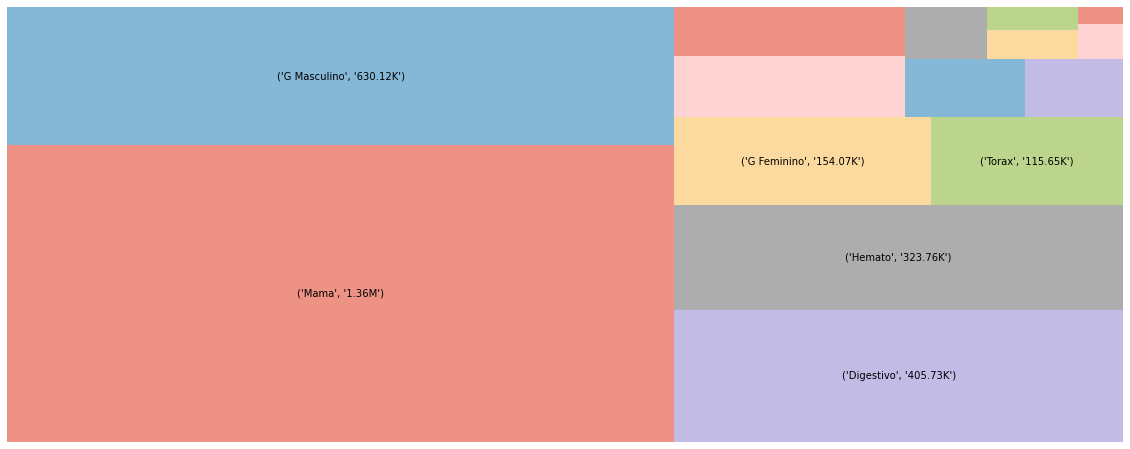

In [47]:
# Gráfico dos tratamentos iniciados e realizados por cid
df_cid = df_final.groupBy("CID").agg(F.count("AP_CNSPCN").alias("N"), F.sum("AP_VL_AP_S").alias("Valor_Total"))
df_cid = df_cid.sort(F.desc("N")).toPandas()
num_format = [numerize.numerize(i) for i in df_cid["N"]]
label = list(zip(df_cid["CID"], num_format))
fig, ax = plt.subplots(1, figsize = (20,8))
squarify.plot(sizes=df_cid["N"], label=label[:6], color=sns.color_palette(), alpha=0.6)
plt.axis('off')
plt.show()

**<h2>Valor total por CID</h2>**

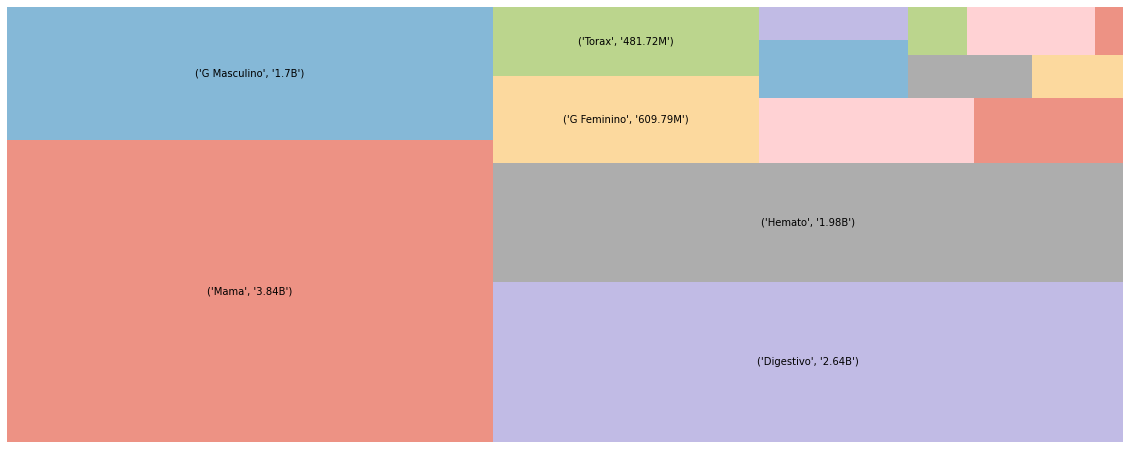

In [48]:
# Gráfico do valor total pago por cid
fig, ax = plt.subplots(1, figsize = (20,8))
num_format = [numerize.numerize(i) for i in df_cid["Valor_Total"]]
label = list(zip(df_cid["CID"], num_format))
squarify.plot(sizes=df_cid["Valor_Total"], label=label[:6], color=sns.color_palette(), alpha=0.6)
plt.axis('off')
plt.show()

**<h2>Procedimentos por estado</h2>**

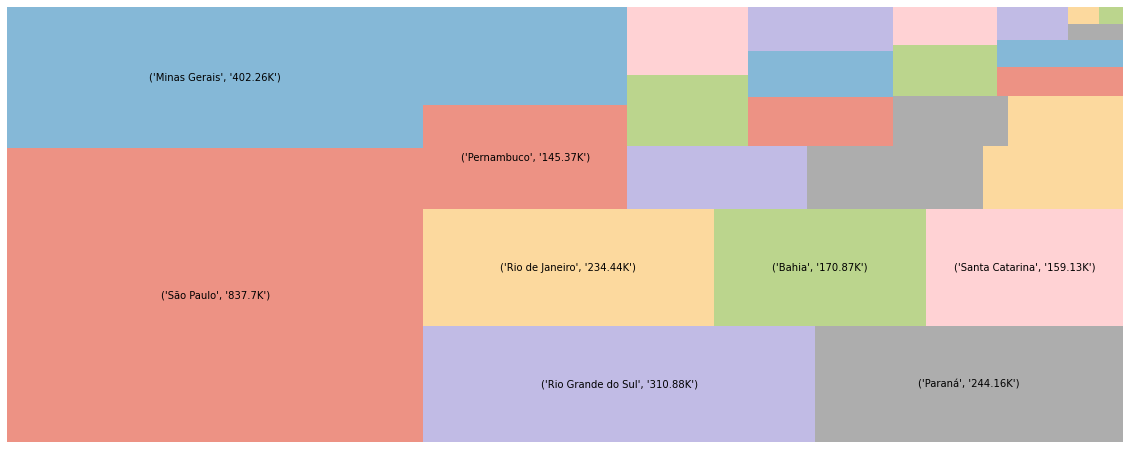

In [49]:
# Gráfico dos tratamentos iniciados e realizados por estado
df_uf = df_final.groupBy("NOME_UF").agg(F.count("AP_CNSPCN").alias("N"), F.sum("AP_VL_AP_S").alias("Valor_Total"))
df_uf = df_uf.sort(F.desc("N")).toPandas()
num_format = [numerize.numerize(i) for i in df_uf["N"]]
label = list(zip(df_uf["NOME_UF"], num_format))
fig, ax = plt.subplots(1, figsize = (20,8))
squarify.plot(sizes=df_uf["N"], label=label[:8], color=sns.color_palette(), alpha=0.6)
plt.axis('off')
plt.show()

**<h2>% do valor total por estado</h2>**

In [50]:
# Per_Capita por uf por cid
df_n_v_uf = df_final.groupBy("NOME_UF", "CID").agg(F.count("AP_CNSPCN").alias("N"), F.sum("AP_VL_AP_S").alias("Valor_Total"))
df_n_v_uf = df_n_v_uf.withColumn("Per_Capita", df_n_v_uf.N/df_n_v_uf.Valor_Total).sort("NOME_UF")
df_n_v_uf.show()

+-------+--------------------+----+-------------------+--------------------+
|NOME_UF|                 CID|   N|        Valor_Total|          Per_Capita|
+-------+--------------------+----+-------------------+--------------------+
|   Acre|           Endocrino|   6|            28295.0|2.120515992224774...|
|   Acre| Ossos e cartilagens|  19| 442662.54345703125|4.292208654388737E-5|
|   Acre|      Trato urinario|  69| 417984.18017578125|1.650780179550871...|
|   Acre|               Torax| 278|          1292471.0|2.150918666647066E-4|
|   Acre|      Não específico| 180|  651191.4509277344|2.764164052577149E-4|
|   Acre|              Hemato| 891|   6266386.26574707|1.421872132061709...|
|   Acre|                Pele|  21|  132758.4805908203|1.581819851096733...|
|   Acre|     Sistema nervoso|  59|  346638.3400878906|1.702062154608762...|
|   Acre|       Tecidos moles|  80|  322863.2800292969|2.477829005291055E-4|
|   Acre|         G Masculino|1183| 3929505.0487976074|3.010557271995329...|

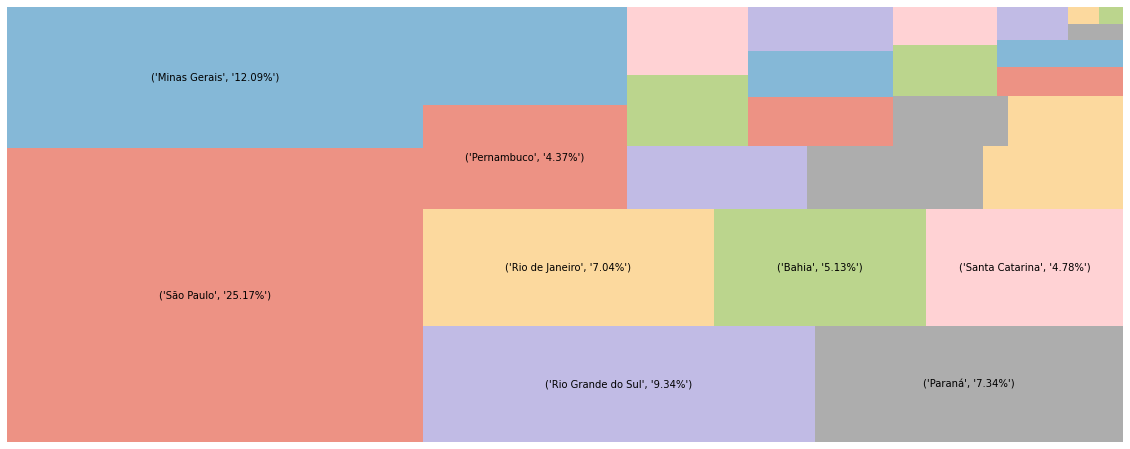

In [51]:
# percentagem do procedimento do total
df_pct = df_final.groupBy("NOME_UF").agg(F.count("AP_CNSPCN").alias("N"))
df_pct = df_pct.withColumn('%',F.col('N')/F.sum('N').over(Window.partitionBy())*100).sort(F.desc("%"))
df_pct_p = df_pct.toPandas()
num_format = ["{:.2f}%".format(i) for i in df_pct_p["%"]]
label = list(zip(df_pct_p["NOME_UF"], num_format))
fig, ax = plt.subplots(1, figsize = (20,8))
squarify.plot(sizes=df_pct_p["%"], label=label[:8], color=sns.color_palette(), alpha=0.6)
plt.axis('off')
plt.show()

**<h2>Procedimentos por CID por ano</h2>**

In [53]:
# Agrupar pelo ano e cid e contagem dos procedimetos e soma do valor pago
df_cid_ano = df_final.groupBy("Year", "CID").agg(F.count("AP_CNSPCN").alias("N"), F.sum("AP_VL_AP_S").alias("Valor_Total"))
df_cid_ano = df_cid_ano.filter(df_cid_ano.Year > 2014).sort("Year")
# Filtrar por cid
unico1 = df_cid_ano.filter(df_cid_ano.CID == "Mama").toPandas()
unico2 = df_cid_ano.filter(df_cid_ano.CID == "Digestivo").toPandas()
unico3 = df_cid_ano.filter(df_cid_ano.CID == "Hemato").toPandas()
unico4 = df_cid_ano.filter(df_cid_ano.CID == "G Masculino").toPandas()
unico5 = df_cid_ano.filter(df_cid_ano.CID == "G Feminino").toPandas()
unico6 = df_cid_ano.filter(df_cid_ano.CID == "Torax").toPandas()
unico7 = df_cid_ano.filter(df_cid_ano.CID == "Cabeça").toPandas()
unico8 = df_cid_ano.filter(df_cid_ano.CID == "Trato urinario").toPandas()
unico9 = df_cid_ano.filter(df_cid_ano.CID == "Tecidos moles").toPandas()
unico10 = df_cid_ano.filter(df_cid_ano.CID == "Ossos e cartilagens").toPandas()
unico11 = df_cid_ano.filter(df_cid_ano.CID == "Sistema nervoso").toPandas()
unico12 = df_cid_ano.filter(df_cid_ano.CID == "Pele").toPandas()
unico13 = df_cid_ano.filter(df_cid_ano.CID == "Endocrino").toPandas()

In [27]:
df_cid_ano = df_final.groupBy("Year").pivot("CID").agg(F.count("AP_CNSPCN").alias("N"))
df_cid_ano = df_cid_ano.filter(df_cid_ano.Year > 2014).sort("Year")
df_cid_ano.show()

+----+------+---------------------+---------+---------+----------+-----------+------+------+--------------+-------------------+----+---------------+-------------+-----+--------------+
|Year|Cabeça|Comportamento incerto|Digestivo|Endocrino|G Feminino|G Masculino|Hemato|  Mama|Não específico|Ossos e cartilagens|Pele|Sistema nervoso|Tecidos moles|Torax|Trato urinario|
+----+------+---------------------+---------+---------+----------+-----------+------+------+--------------+-------------------+----+---------------+-------------+-----+--------------+
|2015| 11251|                11499|    52306|      670|     20711|      81873| 41996|165715|          6147|               1506|2232|           2071|         3933|16330|          6720|
|2016| 11477|                12007|    54267|      734|     20971|      82545| 42904|169246|          5874|               1456|2253|           2064|         3960|16476|          6635|
|2017| 11892|                12733|    57353|      758|     22282|      85240| 4

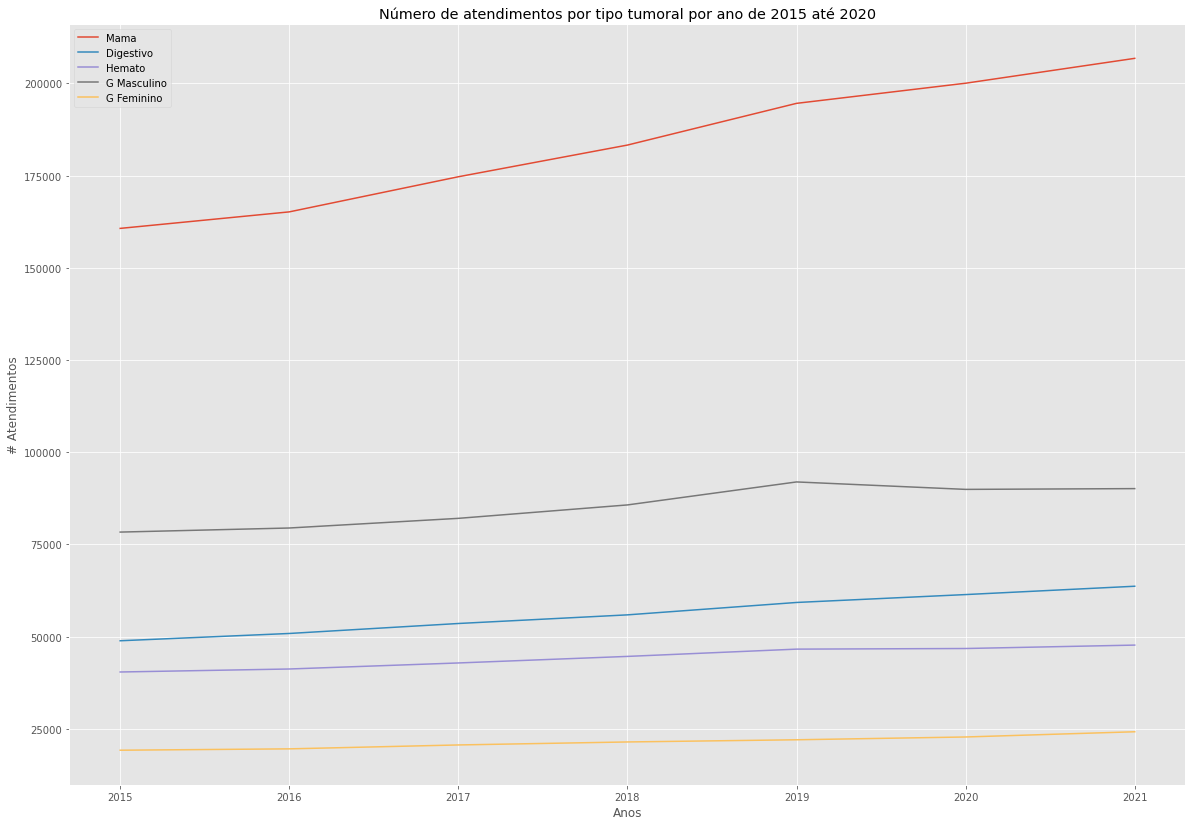

In [54]:
# Plotar gráfico número de atendimentos por cid e por ano
fig, ax = plt.subplots(figsize=(20, 14))
anos = unico1.Year
ax.plot(anos, unico1.N, label = "Mama")
ax.plot(anos, unico2.N, label = "Digestivo")
ax.plot(anos, unico3.N, label = "Hemato")
ax.plot(anos, unico4.N, label = "G Masculino")
ax.plot(anos, unico5.N, label = "G Feminino")
ax.set_ylabel('# Atendimentos')
ax.set_xlabel("Anos")
ax.set_title("Número de atendimentos por tipo tumoral por ano de 2015 até 2020")
ax.legend()
plt.show()

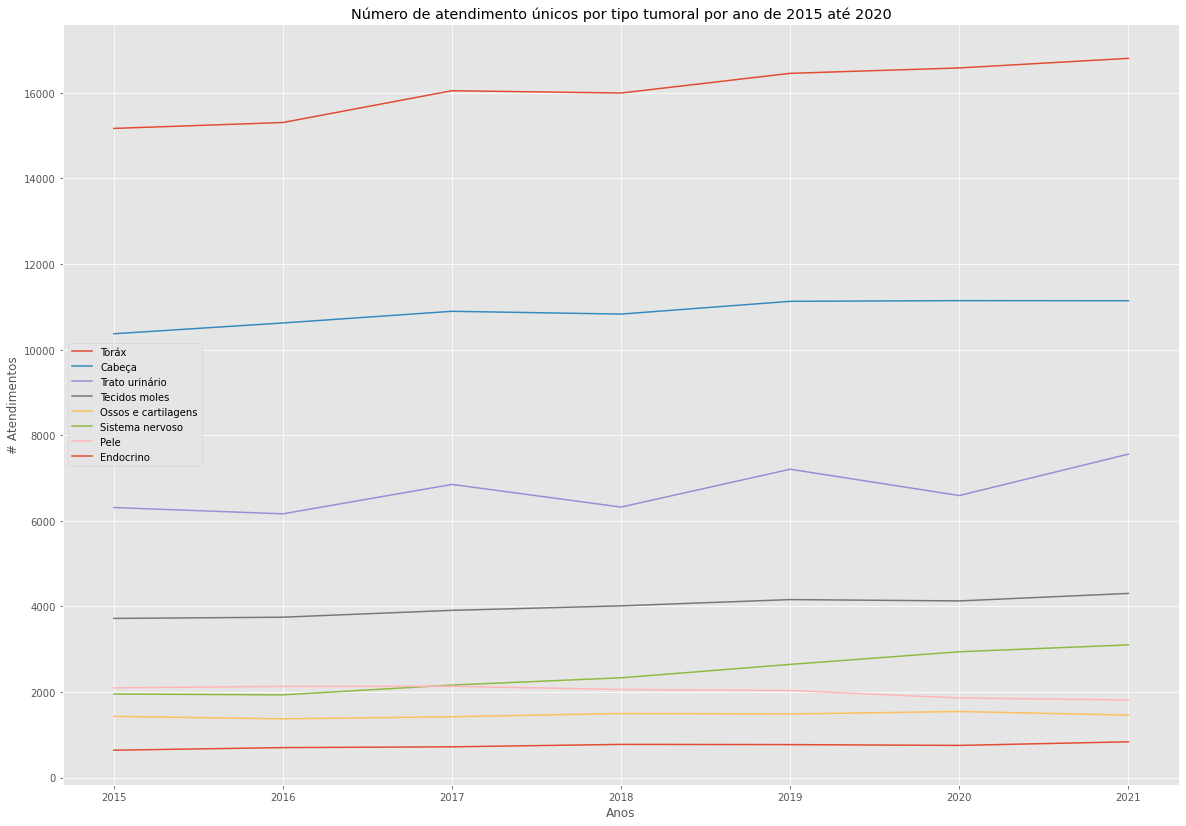

In [55]:
# Segunda parte do gráfico
fig, ax = plt.subplots(figsize=(20, 14))
anos = unico1.Year
ax.plot(anos, unico6.N, label = "Toráx")
ax.plot(anos, unico7.N, label = "Cabeça")
ax.plot(anos, unico8.N, label = "Trato urinário")
ax.plot(anos, unico9.N, label = "Tecidos moles")
ax.plot(anos, unico10.N, label = "Ossos e cartilagens")
ax.plot(anos, unico11.N, label = "Sistema nervoso")
ax.plot(anos, unico12.N, label = "Pele")
ax.plot(anos, unico13.N, label = "Endocrino")
ax.set_ylabel('# Atendimentos')
ax.set_xlabel("Anos")
ax.set_title("Número de atendimento únicos por tipo tumoral por ano de 2015 até 2020")
ax.legend()
plt.show()

**<h2>Valor total por CID por ano</h2>**

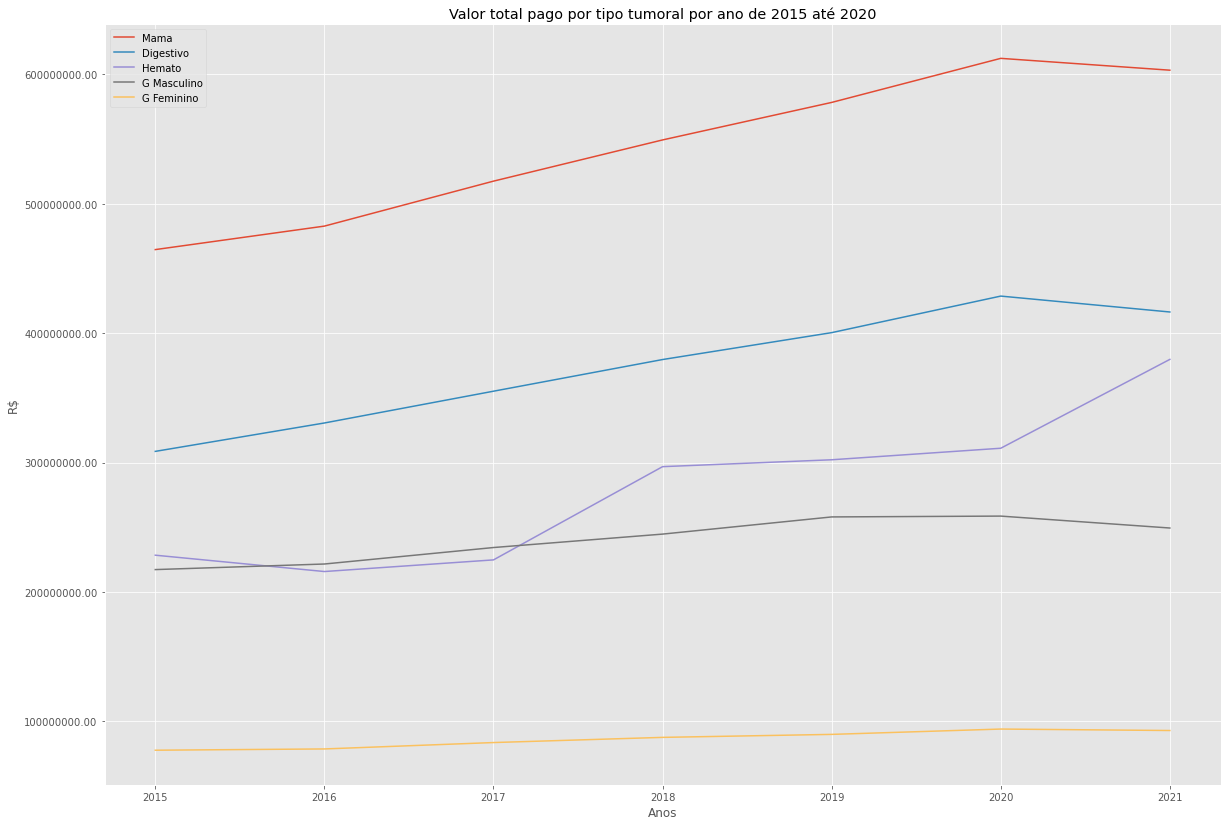

In [56]:
# Plotar gráfico valor das APAC por cid e por ano
fig, ax = plt.subplots(figsize=(20, 14))
anos = unico1.Year
ax.plot(anos, unico1.Valor_Total, label = "Mama")
ax.plot(anos, unico2.Valor_Total, label = "Digestivo")
ax.plot(anos, unico3.Valor_Total, label = "Hemato")
ax.plot(anos, unico4.Valor_Total, label = "G Masculino")
ax.plot(anos, unico5.Valor_Total, label = "G Feminino")
ax.set_ylabel('R$')
ax.set_xlabel("Anos")
ax.set_title("Valor total pago por tipo tumoral por ano de 2015 até 2020")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend()
plt.show()

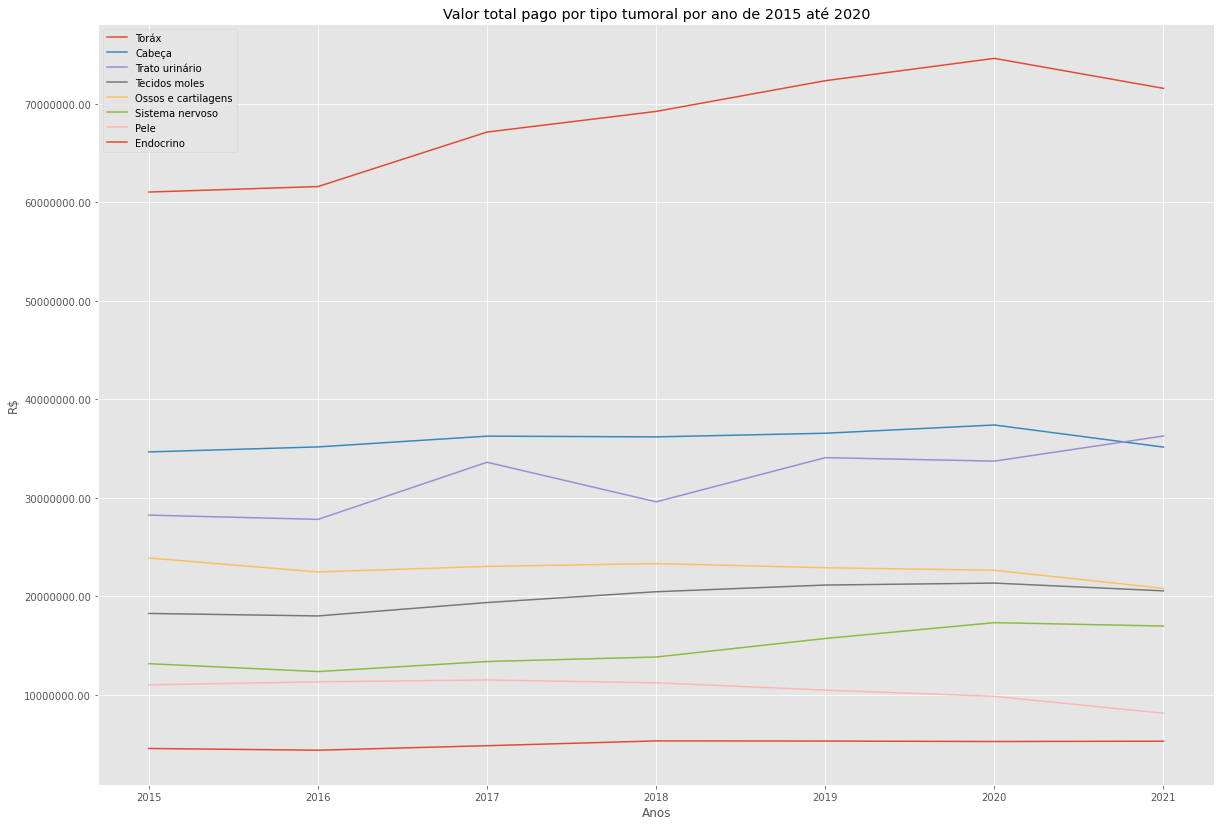

In [57]:
# SEgunda parte do gráfico
fig, ax = plt.subplots(figsize=(20, 14))
anos = unico1.Year
ax.plot(anos, unico6.Valor_Total, label = "Toráx")
ax.plot(anos, unico7.Valor_Total, label = "Cabeça")
ax.plot(anos, unico8.Valor_Total, label = "Trato urinário")
ax.plot(anos, unico9.Valor_Total, label = "Tecidos moles")
ax.plot(anos, unico10.Valor_Total, label = "Ossos e cartilagens")
ax.plot(anos, unico11.Valor_Total, label = "Sistema nervoso")
ax.plot(anos, unico12.Valor_Total, label = "Pele")
ax.plot(anos, unico13.Valor_Total, label = "Endocrino")
ax.set_ylabel('R$')
ax.set_xlabel("Anos")
ax.set_title("Valor total pago por tipo tumoral por ano de 2015 até 2020")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend()
plt.show()

**Contagem do número de procedimentos por estado por ano**

**<h2>Valor total em 2020 por estado</h2>**

In [25]:
total_estado = df_final.filter(df_final.Year > 2014).groupBy("Year", "NOME_UF").agg(F.count("AP_CNSPCN").alias("N"), F.sum("AP_VL_AP_S").alias("Valor_Total")).sort("Year")
total_estado.show()

+----+-------------------+-----+--------------------+
|Year|            NOME_UF|    N|         Valor_Total|
+----+-------------------+-----+--------------------+
|2015|         Pernambuco|20115| 7.633891447704315E7|
|2015|  Rio Grande do Sul|42560|1.5754911786032867E8|
|2015|              Bahia|20483| 8.005774244502258E7|
|2015|              Amapá|  452|  1365802.6848144531|
|2015|              Ceará|17372| 6.436766184564209E7|
|2015|              Piauí| 5518|1.9447524237579346E7|
|2015|Rio Grande do Norte| 7868| 3.295501914530182E7|
|2015|            Roraima|  349|   730149.4782562256|
|2015|              Goiás| 9725| 3.845774801387024E7|
|2015|            Sergipe| 3315|   8278228.476325989|
|2015|     Santa Catarina|19947| 7.099759064048767E7|
|2015|     Espírito Santo| 9035| 3.356562747635651E7|
|2015|     Rio de Janeiro|28492| 8.765930395726013E7|
|2015|               Acre|  929|   4133153.001396179|
|2015|           Rondônia| 1572|   6955239.992210388|
|2015|            Alagoas| 5

In [32]:
total_estado.filter(total_estado.Year == 2015).sort("Nome_UF").show(27)

+----+-------------------+------+--------------------+
|Year|            NOME_UF|     N|         Valor_Total|
+----+-------------------+------+--------------------+
|2015|               Acre|   929|   4133153.001396179|
|2015|            Alagoas|  5254|1.7564204776176453E7|
|2015|              Amapá|   452|  1365802.6848144531|
|2015|           Amazonas|  2802|    9851312.52696991|
|2015|              Bahia| 20483| 8.005774244502258E7|
|2015|              Ceará| 17372| 6.436766184564209E7|
|2015|   Distrito Federal|  4848| 1.703231804434967E7|
|2015|     Espírito Santo|  9035| 3.356562747635651E7|
|2015|              Goiás|  9725| 3.845774801387024E7|
|2015|           Maranhão|  6640| 2.445002500643921E7|
|2015|        Mato Grosso|  5016|1.7974048819366455E7|
|2015| Mato Grosso do Sul|  5709|1.7770800274856567E7|
|2015|       Minas Gerais| 52934| 1.917193935860138E8|
|2015|             Paraná| 28670|1.1146968895343018E8|
|2015|            Paraíba|  7315| 2.573283041556549E7|
|2015|    

/home/leandro/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/leandro/anaconda3/lib/python3.9/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/leandro/anaconda3/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


(-76.24758052684999, -26.59070825415, -35.70232894755001, 7.222992030549992)

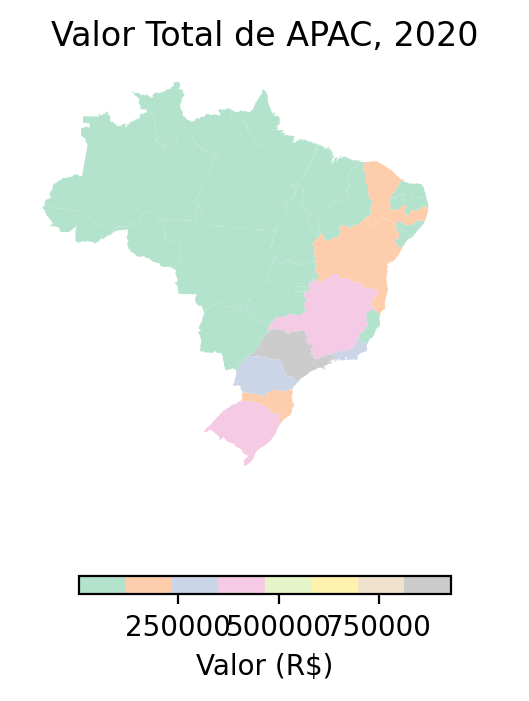

In [15]:
# Plotar gráfico do valor de apac por estado
states = geobr.read_state(year=2019)
estado = total_estado.filter(total_estado.Year == 2020).toPandas()
states = states.replace("Amazônas", "Amazonas")
states["name_state"] = states["name_state"].str.lower()
estado["Nome_UF"] = estado["Nome_UF"].str.lower()
states = states.merge(estado, how="left", left_on="name_state", right_on="Nome_UF")

# plt.rcParams.update({"font.size": 5})

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

states.plot(
    column="N",
    cmap="Pastel2",
    legend=True,
    legend_kwds={
        "label": "Valor (R$)",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    ax=ax,
)

ax.set_title("Valor Total de APAC, 2020")
ax.axis("off")

**<h2>Valor total por mês de 2015 a 2021</h2>**

In [11]:
df_full = spark.read.json("hdfs://127.0.1.1:9000/datasus/siasus-df-full")
df_full.show(5)

+-------+----------+-------------+---------+---------+---------+---------+---------+----------+----------+----------+--------------------+----------+---------+----------+---------+----------+----------+----------+----------+----------+---------+--------+---------+--------+---------+---------+---------+----------+---------+----------+--------+---------+---------+----------+-------+---------+---------+---------+--------+---------+--------+--------+----------+---------+--------+--------+----------+----------+----------+---------+----------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+------+---------+----------+---+----+---------+-----------+---------------+--------------+--------+----------------+---------+----------------+
|AP_ALTA|AP_APACANT|   AP_AUTORIZ|AP_CATEND|AP_CEPPCN|AP_CIDCAS|AP_CIDPRI|AP_CIDSEC|    AP_CMP|AP_CNPJCPF|AP_CNPJMNT|           AP_CNSPCN| AP_CODEMI|AP_CODUNI|AP_COIDADE|AP_CONDIC|  AP_DTAUT

In [85]:
# Calculando o valor da apac por mes e ordenando por mes
valor_total_mes = df_full.filter(df_full.Year > 2014).groupBy(["MesAno"]).agg(F.sum("AP_VL_AP").alias("Valor_Total"), F.mean("AP_VL_AP").alias("Media"))
valor_total_mes = valor_total_mes.withColumn('data', to_date("MesAno", 'MMyyyy')).sort('data')
valor_total_mes.show()

+------+--------------------+------------------+----------+
|MesAno|         Valor_Total|             Media|      data|
+------+--------------------+------------------+----------+
|012015|      1.3724914418E8| 560.2531836866318|2015-01-01|
|022015|1.3312742532000002E8| 548.0614942405705|2015-02-01|
|032015|1.3141572165999995E8| 520.6830737229138|2015-03-01|
|042015|      1.2657448412E8| 514.4885949109829|2015-04-01|
|052015|1.2888849895999998E8|509.94258760598365|2015-05-01|
|062015|1.2801060724000002E8| 512.8342450343331|2015-06-01|
|072015|1.2855797478999993E8| 516.3198968227509|2015-07-01|
|082015|      1.3156178243E8| 513.2355812638002|2015-08-01|
|092015|1.3288094424999993E8| 512.1995137454128|2015-09-01|
|102015|1.3184838680999997E8| 514.9362104371054|2015-10-01|
|112015|1.2932549332000002E8| 509.2457062077928|2015-11-01|
|122015|1.2629772105999999E8|502.45551640867114|2015-12-01|
|012016|1.2580015983999987E8| 507.7213906220986|2016-01-01|
|022016|1.2690593983999991E8| 506.659080

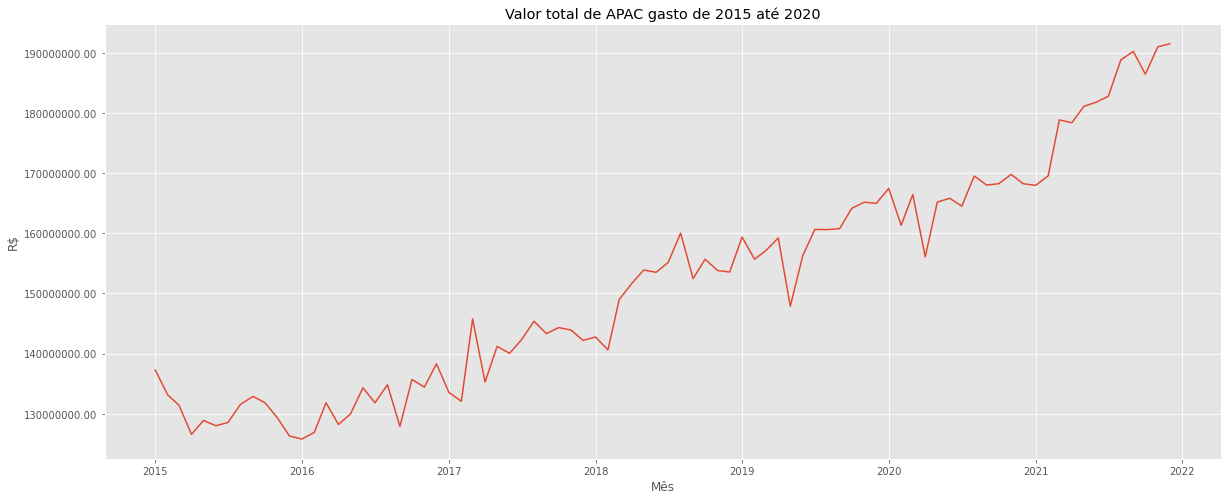

In [86]:
# Plotar gráfico do valor APAC por mês
valor_total_mes = valor_total_mes.toPandas()
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(valor_total_mes.data, valor_total_mes.Valor_Total)
ax.set_ylabel('R$')
ax.set_xlabel("Mês")
ax.set_title("Valor total de APAC gasto de 2015 até 2020")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

**<h2>Valor total por ano</h2>**

In [87]:
valor_total_ano = df_full.filter(df_full.Year > 2014).groupBy(["Year"]).agg(F.sum("AP_VL_AP").alias("Valor_Total"), F.mean("AP_VL_AP").alias("Media")).sort("Year")
valor_total_ano.show()

+----+--------------------+------------------+
|Year|         Valor_Total|             Media|
+----+--------------------+------------------+
|2015|1.5657381841399999E9| 519.3536992525495|
|2016|1.5800162127100003E9|510.12217711131115|
|2017| 1.689333192379999E9|509.40485035678415|
|2018|1.8220904332599986E9|  524.810596056742|
|2019|1.9118267538999999E9| 524.8327846796432|
|2020|1.9905942928999987E9| 526.5129336450555|
|2021| 2.188397656830003E9| 557.5339406741884|
+----+--------------------+------------------+



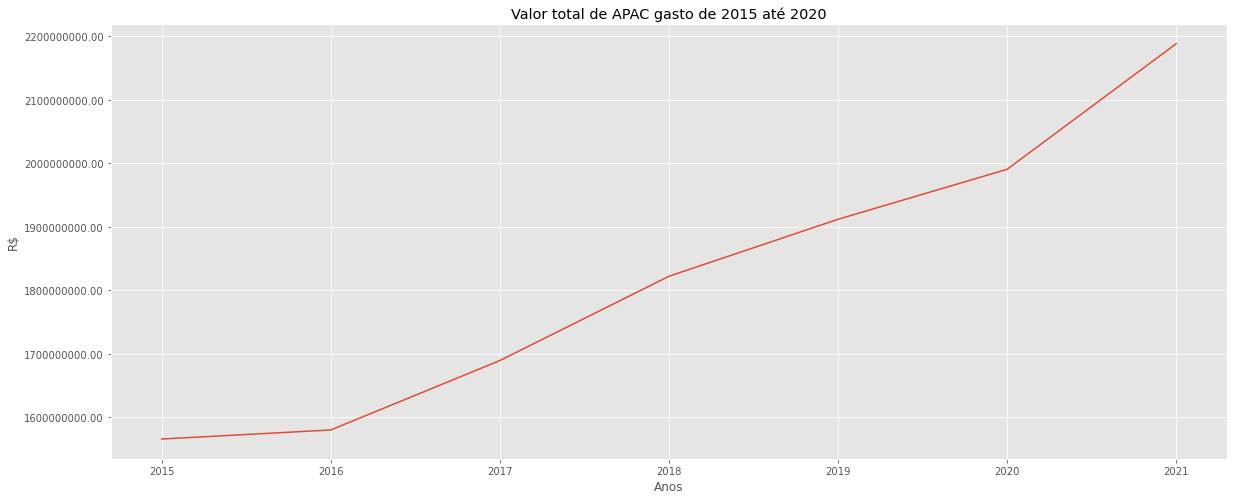

In [90]:
# Plotar gráfico do valor APAC por ano
valor_total_ano = valor_total_ano.toPandas()
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(valor_total_ano.Year, valor_total_ano.Valor_Total)
ax.set_ylabel('R$')
ax.set_xlabel("Anos")
ax.set_title("Valor total de APAC gasto de 2015 até 2020")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

**<h2>Número de procedimentos por ano</h2>**

In [91]:
# Contagem de procedimentos apac realizados por ano
df_proced_full = df_full.groupBy("Year").count().sort("Year")
df_proced_full.show()

+----+-------+
|Year|  count|
+----+-------+
|2015|3014786|
|2016|3097332|
|2017|3316520|
|2018|3471902|
|2019|3642741|
|2020|3780715|
|2021|3925282|
+----+-------+



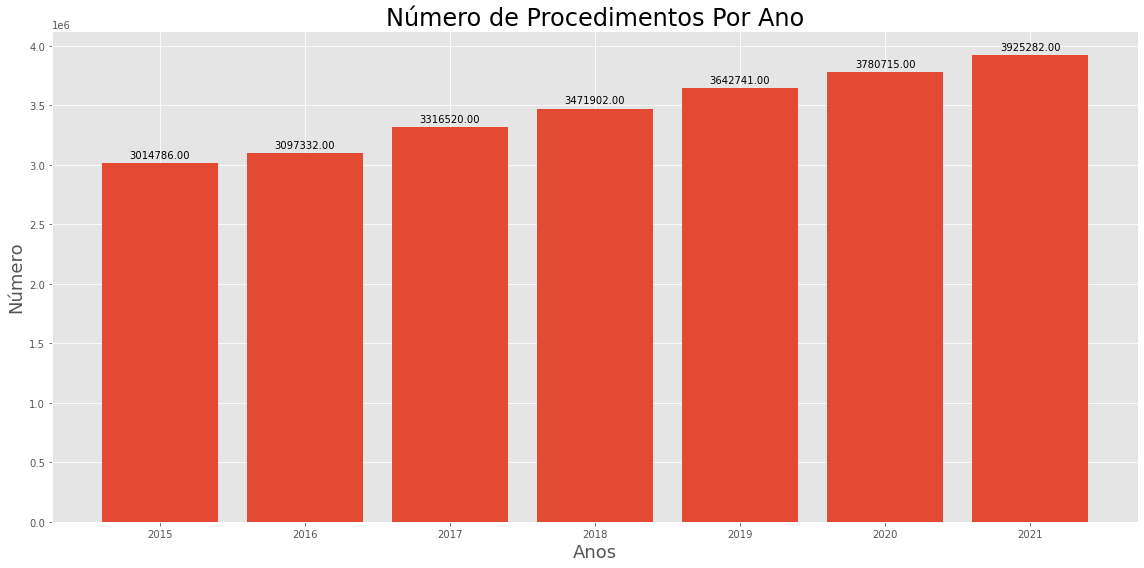

In [100]:
# Grafico da média de procedimentos por ano
df_graph = df_proced_full.toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(df_graph.Year, df_graph["count"])

ax.set_ylabel('Número', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Número de Procedimentos Por Ano', fontdict={'fontsize': 24})
ax.bar_label(rects1, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Média de procedimentos por sexo por ano</h2>**

In [75]:
# Média de procedimentos por ano
df_proced_ano = df_final.filter(df_final.Year > 2014).groupBy("Year", "AP_SEXO").agg(F.mean("N_PROCED").alias("Media_Proced")).sort("Year")
df_proced_ano.show()

+----+-------+------------------+
|Year|AP_SEXO|      Media_Proced|
+----+-------+------------------+
|2015|      M|19.791473117785035|
|2015|      F|27.065230901615834|
|2016|      M|23.450586350020668|
|2016|      F| 32.71460736416564|
|2017|      M| 24.87216638384893|
|2017|      F| 35.19354445392775|
|2018|      M| 25.29041505210588|
|2018|      F| 35.92409999894024|
|2019|      F| 34.58501776041649|
|2019|      M|24.354133285414076|
|2020|      M| 22.86240159441953|
|2020|      F|31.927412006664586|
|2021|      M|19.263684468397845|
|2021|      F| 26.86659119049624|
+----+-------+------------------+



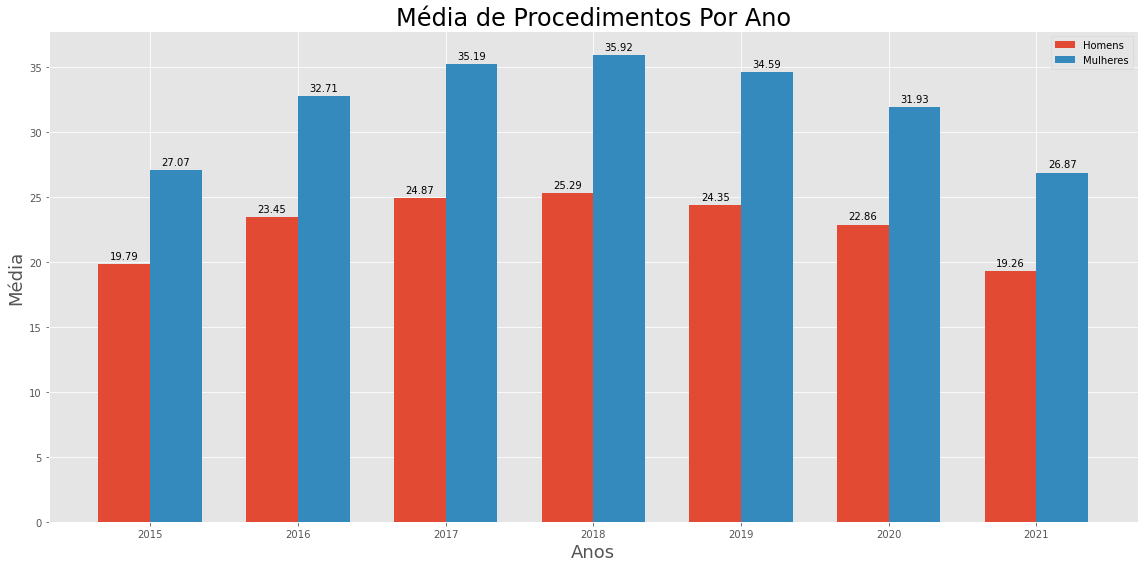

In [77]:
# Grafico da média de procedimentos por ano
df_graph = df_proced_ano.toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].Media_Proced
women = df_graph[df_graph.AP_SEXO == "F"].Media_Proced

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Média', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Média de Procedimentos Por Ano', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Média de procedimentos por sexo por cid por ano</h2>**

In [79]:
df_proced = df_final.filter(df_final.Year > 2014).groupBy("Year", "CID", "AP_SEXO").agg(F.mean("N_PROCED").alias("Media_Proced")).sort("Year")
df_proced.show()

+----+--------------------+-------+------------------+
|Year|                 CID|AP_SEXO|      Media_Proced|
+----+--------------------+-------+------------------+
|2015|       Tecidos moles|      F|11.458229114557279|
|2015|                Pele|      M| 8.907051282051283|
|2015|Comportamento inc...|      F| 43.12786062306216|
|2015|              Cabeça|      F| 6.145631067961165|
|2015|                Mama|      F| 33.56350667560812|
|2015|         G Masculino|      M| 26.09268012653744|
|2015|              Cabeça|      M| 5.841366554237841|
|2015|      Trato urinario|      M| 7.933545647558386|
|2015|              Hemato|      M|23.529483494469122|
|2015|     Sistema nervoso|      F| 9.470132743362832|
|2015| Ossos e cartilagens|      F|10.415730337078651|
|2015|      Não específico|      F| 11.60931630353118|
|2015|     Sistema nervoso|      M| 9.574121679520138|
|2015| Ossos e cartilagens|      M|10.858437146092864|
|2015|      Trato urinario|      F| 8.052238805970148|
|2015|    

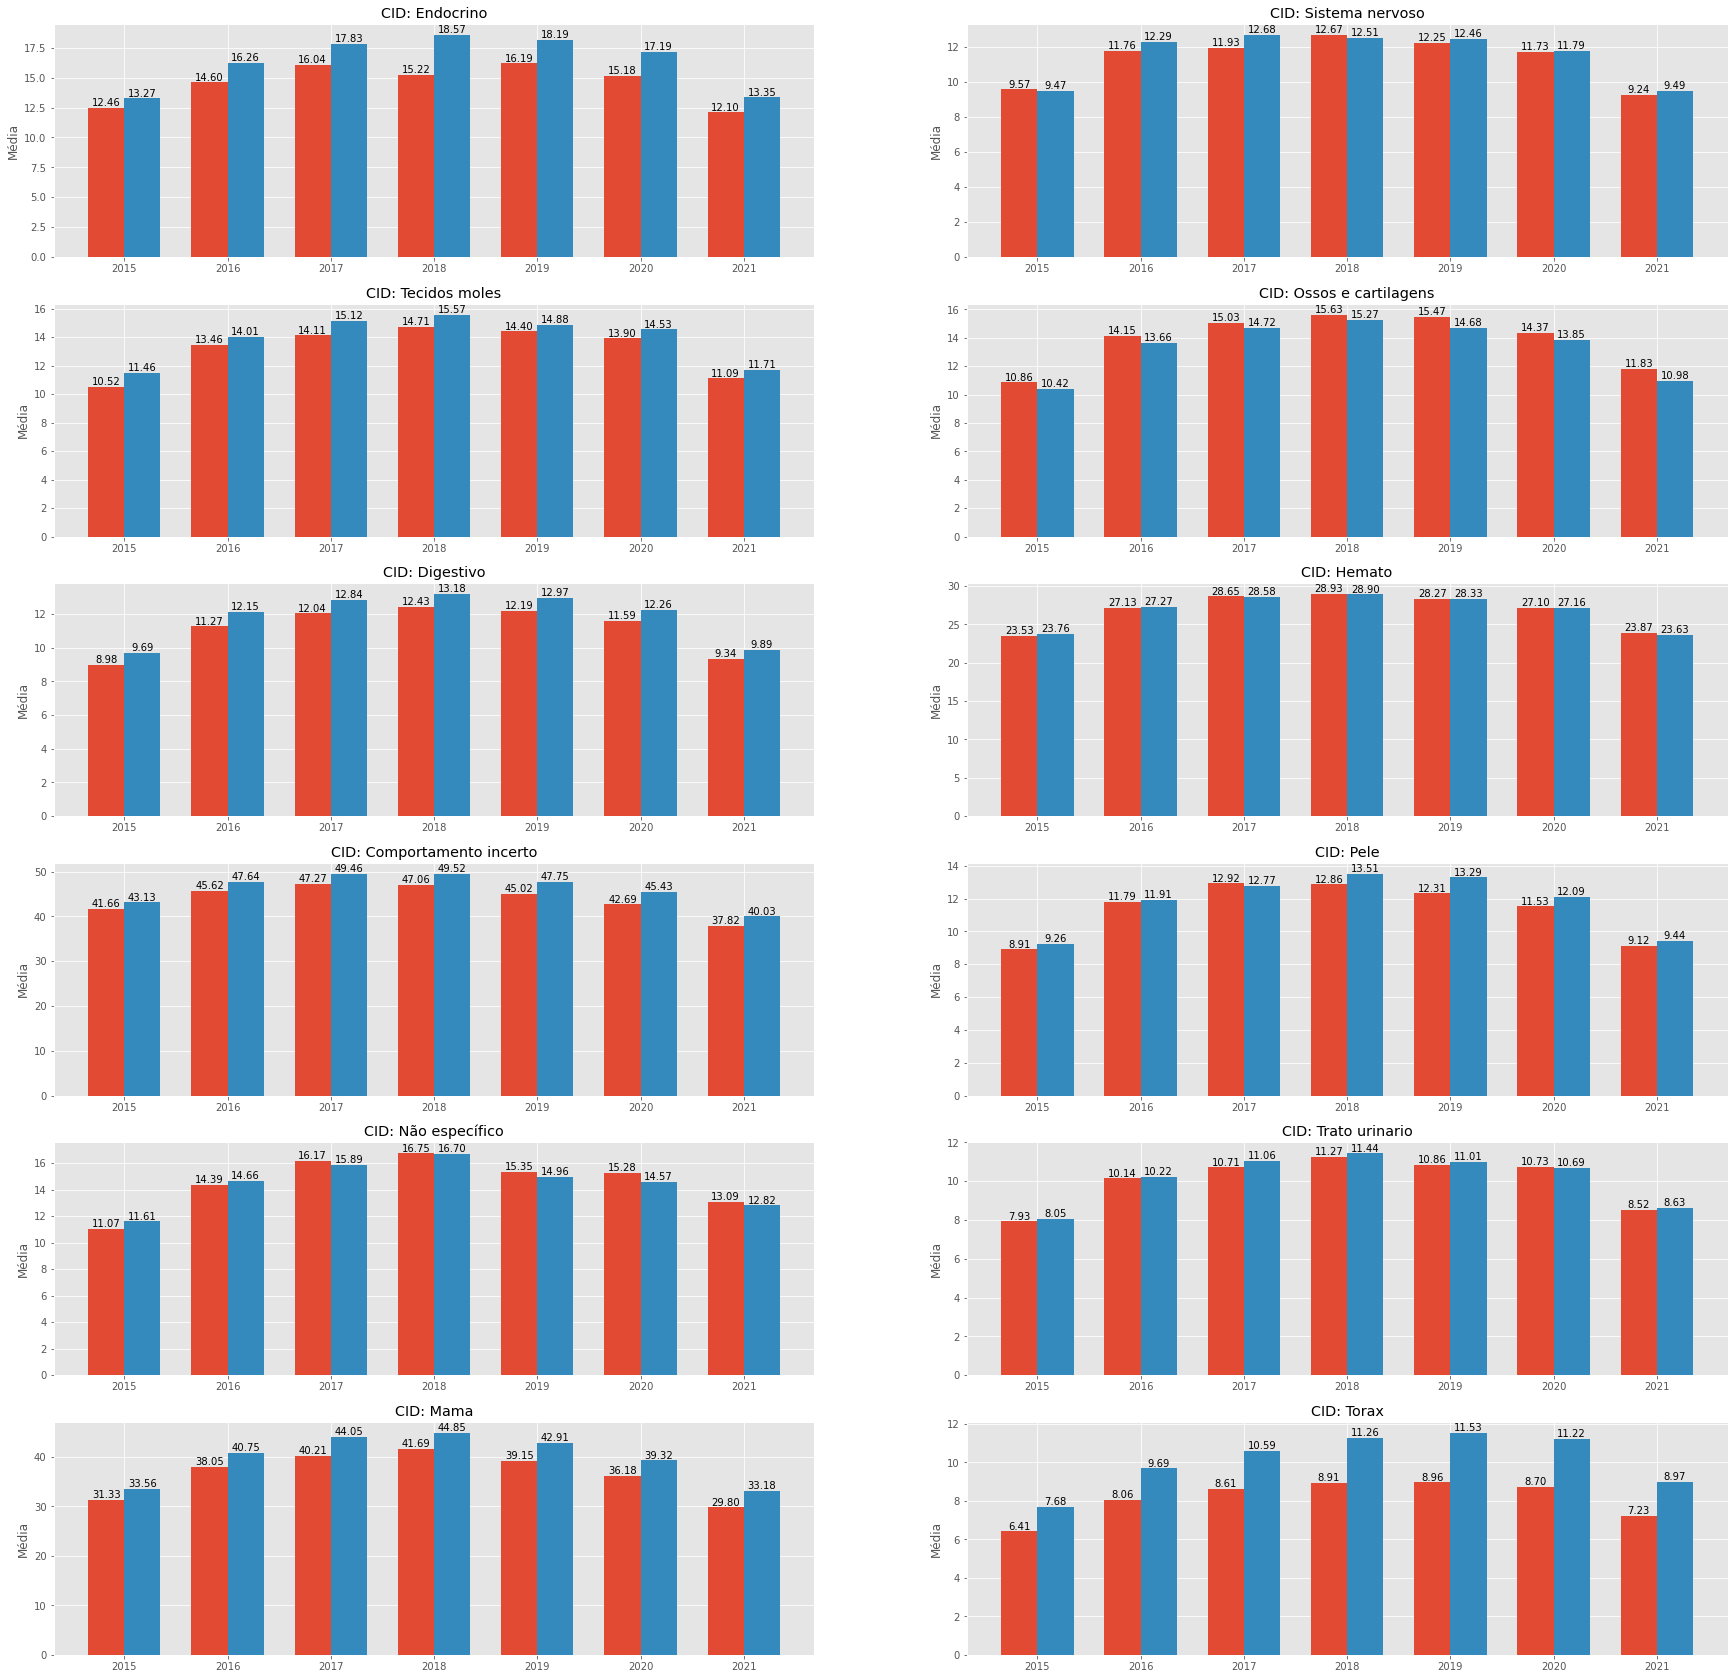

In [80]:
# Grafico
df_graph = df_proced.toPandas()
cids = ['Endocrino', 'Sistema nervoso', 'Tecidos moles',
       'Ossos e cartilagens', 'Digestivo', 'Hemato',
       'Comportamento incerto', 'Pele', 'Não específico',
       'Trato urinario', 'Mama', 'Torax', 'Cabeça']

plt.style.use("ggplot")
fig, axs = plt.subplots(6, 2, figsize=(30, 30))

for cid, ax in zip(cids, axs.ravel()):
    df = df_graph[df_graph["CID"] == cid]
    men = df[df.AP_SEXO == "M"].Media_Proced
    women = df[df.AP_SEXO == "F"].Media_Proced
    labels = df.Year.unique()
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, men, width, label="Homens")
    rects2 = ax.bar(x + width/2, women, width, label="Mulheres")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Média')
    ax.set_title(f"CID: {cid}")
    ax.bar_label(rects1, fmt='%.2f')
    ax.bar_label(rects2, fmt='%.2f')

plt.show()

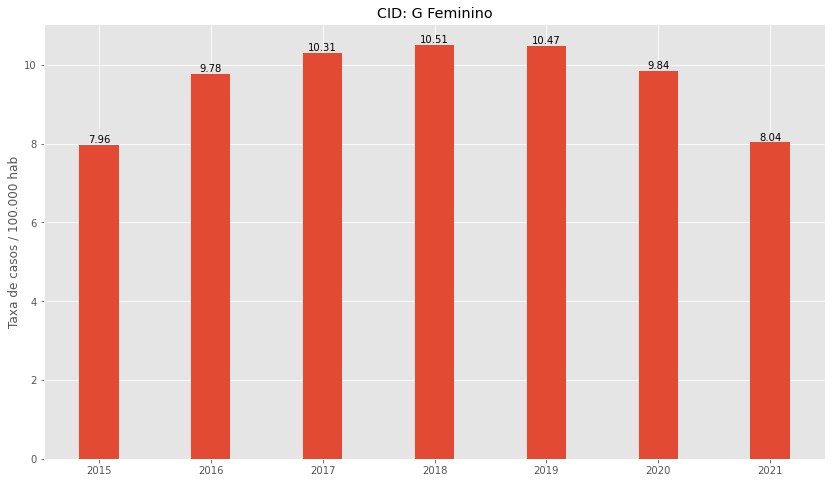

In [81]:
# Grafico do cid G Feminino
df_graph = df_proced.toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Feminino"]
women = df[df.AP_SEXO == "F"].Media_Proced
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women, width)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Feminino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

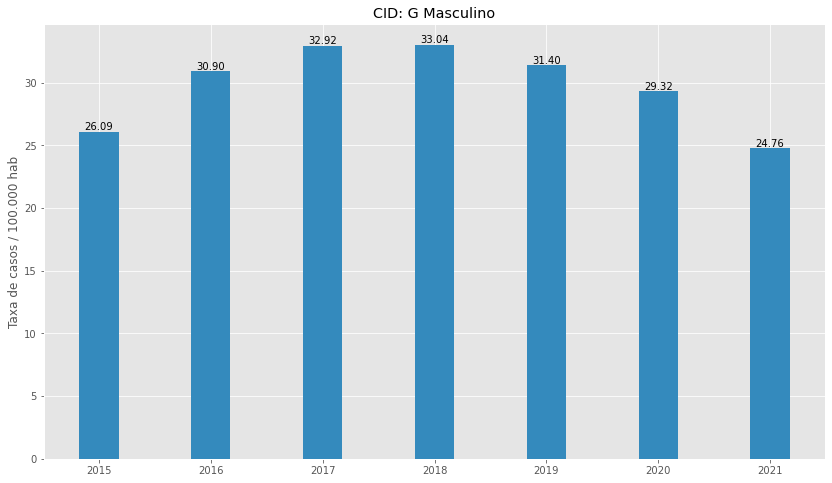

In [82]:
# Grafico do cid G Masculino
df_graph = df_proced.toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Masculino"]
women = df[df.AP_SEXO == "M"].Media_Proced
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women, width, color="#348ABD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Masculino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

**<h2>Média de linhas de tratamento por sexo por ano</h2>**

In [101]:
# Média de linhas de tratamento por ano
df_trat_ano = df_final.filter(df_final.Year > 2014).groupBy("Year", "AP_SEXO").agg(F.mean("AP_PRIPAL_N").alias("Media_Proced")).sort("Year")
df_trat_ano.show()

+----+-------+------------------+
|Year|AP_SEXO|      Media_Proced|
+----+-------+------------------+
|2015|      F|1.1534324505210822|
|2015|      M|1.0713333026721243|
|2016|      M|1.0728251821903614|
|2016|      F|1.1534370268625034|
|2017|      F|  1.16004005157934|
|2017|      M|1.0797219684114345|
|2018|      F|1.1677352578572362|
|2018|      M| 1.092048442102818|
|2019|      M|1.0872130460174605|
|2019|      F|1.1647825810914219|
|2020|      F|1.1633181037175881|
|2020|      M|1.0868659691081215|
|2021|      M| 1.095267025967663|
|2021|      F| 1.162906892970424|
+----+-------+------------------+



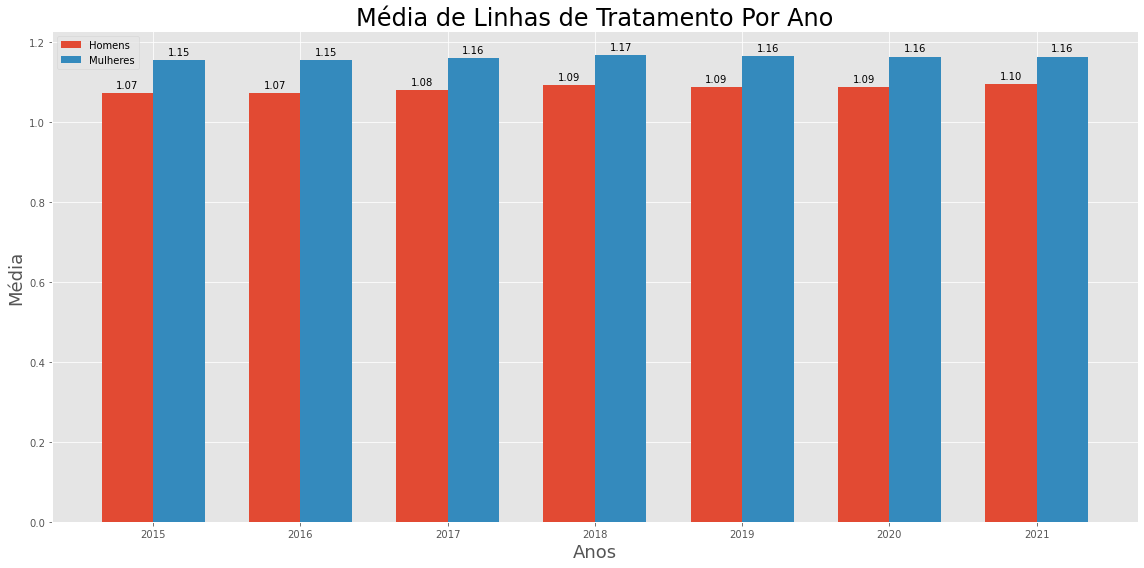

In [103]:
# Grafico da média de linhas de tratamento por ano
df_graph = df_trat_ano.toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].Media_Proced
women = df_graph[df_graph.AP_SEXO == "F"].Media_Proced

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Média', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Média de Linhas de Tratamento Por Ano', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Média de linhas de tratamento por sexo por cid por ano</h2>**

In [104]:
df_trat = df_final.filter(df_final.Year > 2014).groupBy("Year", "CID", "AP_SEXO").agg(F.mean("AP_PRIPAL_N").alias("Media_Proced")).sort("Year")
df_trat.show()

+----+--------------------+-------+------------------+
|Year|                 CID|AP_SEXO|      Media_Proced|
+----+--------------------+-------+------------------+
|2015|       Tecidos moles|      F|1.0290145072536268|
|2015|         G Masculino|      M| 1.060630488683693|
|2015|Comportamento inc...|      F|1.0358777498892662|
|2015|                Mama|      F|1.1958178382003293|
|2015| Ossos e cartilagens|      M|1.1064552661381652|
|2015|              Cabeça|      M|1.0717005766510717|
|2015|               Torax|      F|1.0520059435364042|
|2015|     Sistema nervoso|      F|1.0165929203539823|
|2015|      Não específico|      F|1.2032306536438768|
|2015|                Pele|      M|           1.03125|
|2015|      Trato urinario|      M| 1.026963906581741|
|2015|                Mama|      M|1.2201780415430268|
|2015|      Trato urinario|      F|1.0248756218905473|
|2015|     Sistema nervoso|      M|1.0188517566409596|
|2015|Comportamento inc...|      M| 1.041895895048667|
|2015|    

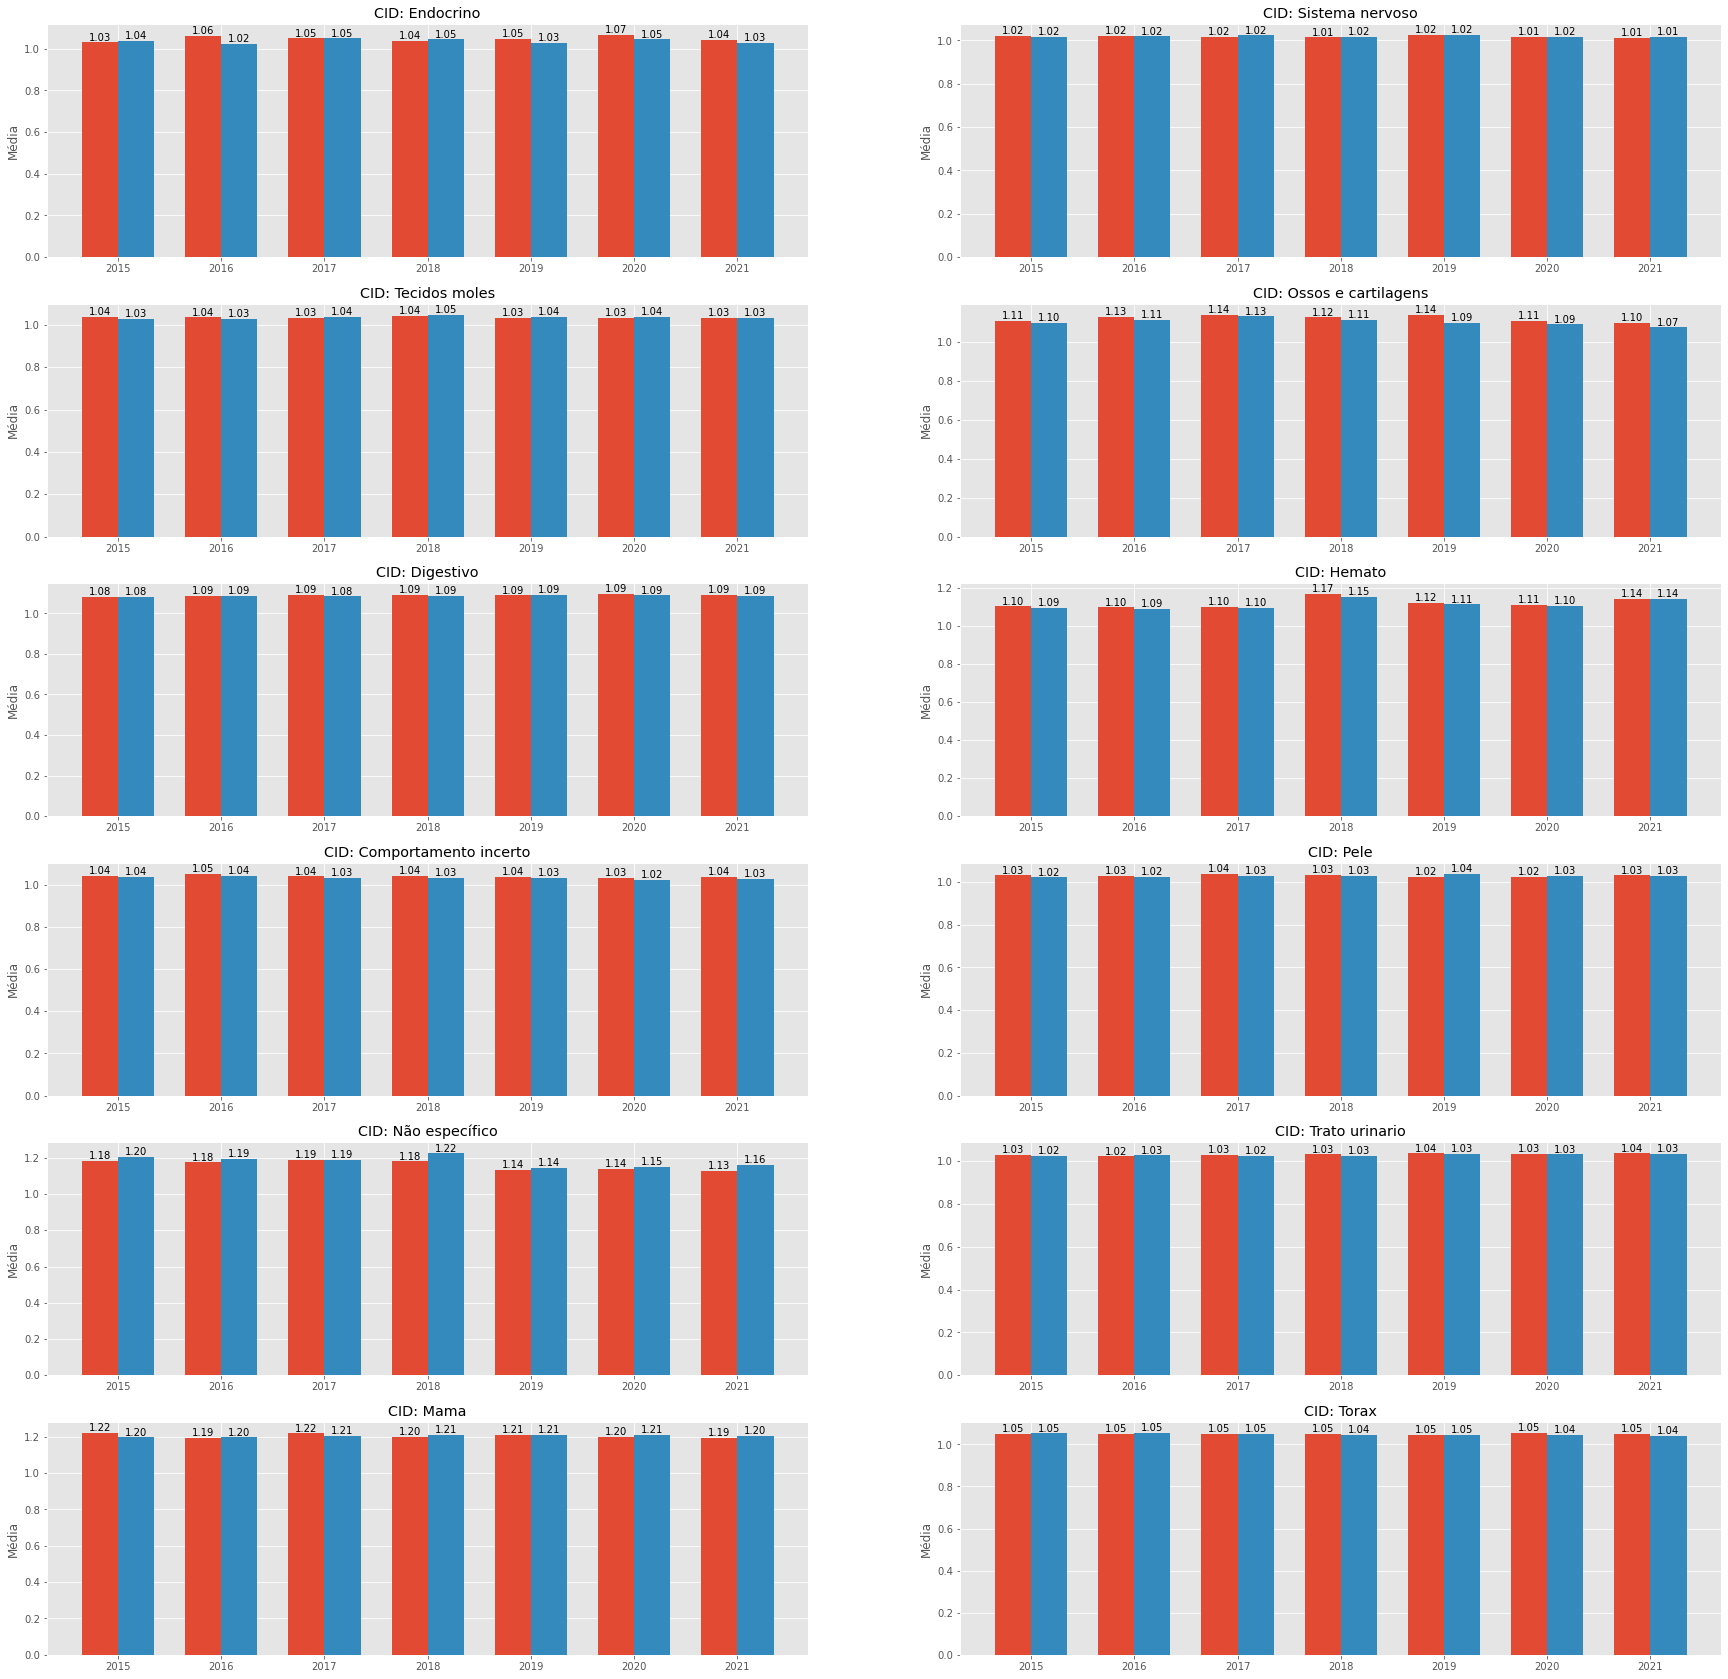

In [106]:
# Grafico
df_graph = df_trat.toPandas()
cids = ['Endocrino', 'Sistema nervoso', 'Tecidos moles',
       'Ossos e cartilagens', 'Digestivo', 'Hemato',
       'Comportamento incerto', 'Pele', 'Não específico',
       'Trato urinario', 'Mama', 'Torax', 'Cabeça']

plt.style.use("ggplot")
fig, axs = plt.subplots(6, 2, figsize=(30, 30))

for cid, ax in zip(cids, axs.ravel()):
    df = df_graph[df_graph["CID"] == cid]
    men = df[df.AP_SEXO == "M"].Media_Proced
    women = df[df.AP_SEXO == "F"].Media_Proced
    labels = df.Year.unique()
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, men, width, label="Homens")
    rects2 = ax.bar(x + width/2, women, width, label="Mulheres")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Média')
    ax.set_title(f"CID: {cid}")
    ax.bar_label(rects1, fmt='%.2f')
    ax.bar_label(rects2, fmt='%.2f')

plt.show()

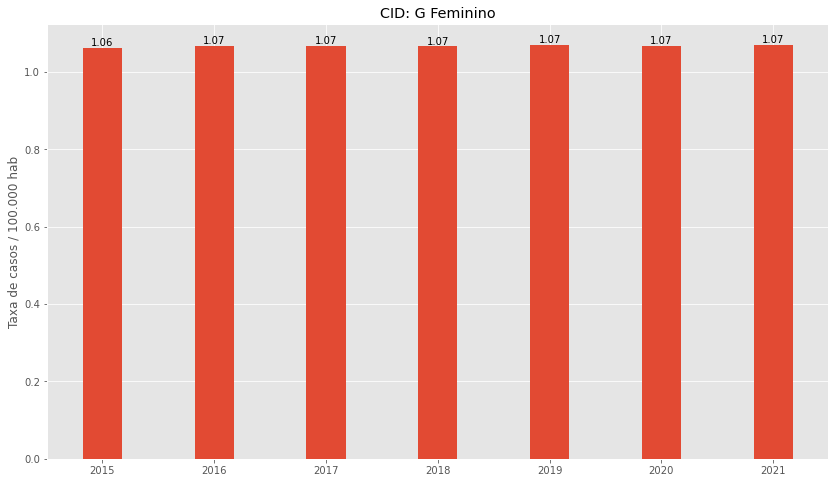

In [107]:
# Grafico do cid G Feminino
df_graph = df_trat.toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Feminino"]
women = df[df.AP_SEXO == "F"].Media_Proced
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women, width)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Feminino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

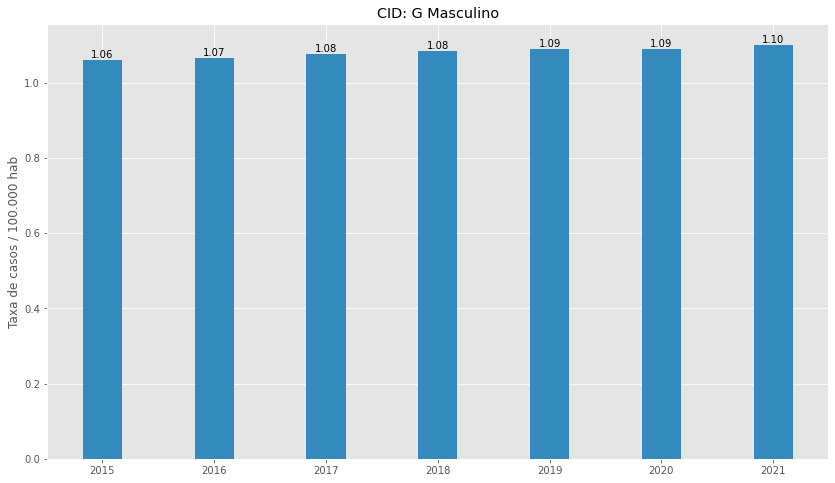

In [108]:
# Grafico do cid G Masculino
df_graph = df_trat.toPandas()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 8))

df = df_graph[df_graph["CID"] == "G Masculino"]
women = df[df.AP_SEXO == "M"].Media_Proced
labels = df.Year.unique()
width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x, women, width, color="#348ABD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Taxa de casos / 100.000 hab')
ax.set_title("CID: G Masculino")
ax.bar_label(rects1, fmt='%.2f')

plt.show()

**<h2>Média de tempo da apac total</h2>**

In [50]:
# Média de tempo da apac total
df_tempo_apac = df_final.filter(df_final.Year > 2014).groupBy("Year", "AP_SEXO").agg(F.mean("TEMP_APAC_TOTAL").alias("Tempo")).sort("Year")
df_tempo_apac.show()

+----+-------+------------------+
|Year|AP_SEXO|             Tempo|
+----+-------+------------------+
|2015|      F| 942.9169017114447|
|2015|      M| 756.5656878075703|
|2016|      F|1117.7843117361513|
|2016|      M| 870.5082417426855|
|2017|      F|1197.4212177305828|
|2017|      M| 916.9749651916634|
|2018|      F|1215.1040118975707|
|2018|      M|  928.475029299659|
|2019|      M| 896.8961749452174|
|2019|      F|1170.2993407092806|
|2020|      F|1080.7721740601896|
|2020|      M|  843.209317389138|
|2021|      M| 732.8311660950515|
|2021|      F| 920.8436863559668|
+----+-------+------------------+



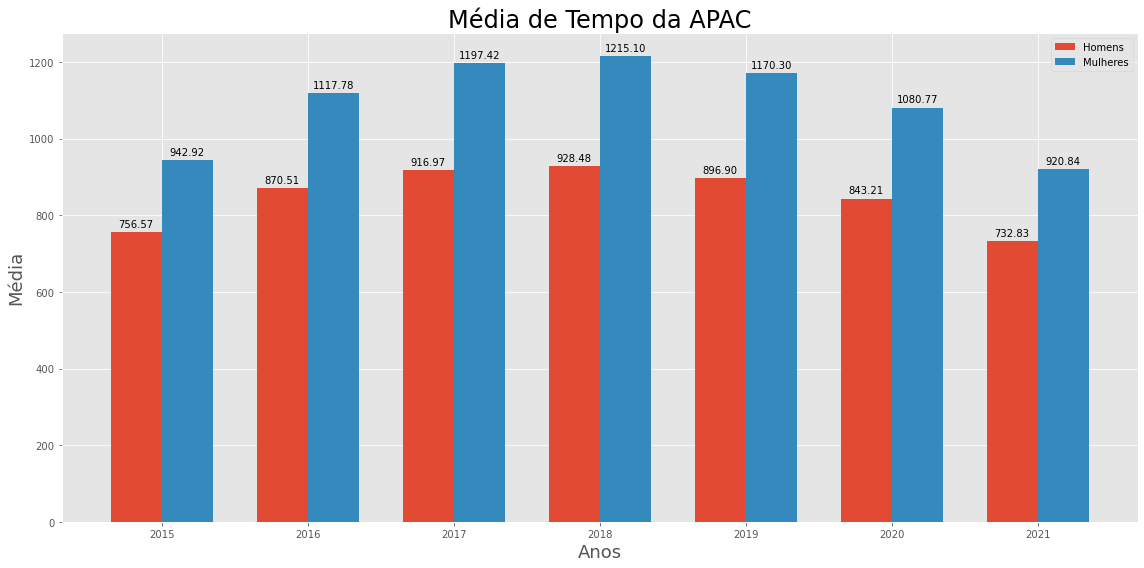

In [111]:
# Grafico da média de tempo da apac total
df_graph = df_tempo_apac.toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].Tempo
women = df_graph[df_graph.AP_SEXO == "F"].Tempo

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('Média', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Média de Tempo da APAC', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h2>Valor do total por proced total (per proced)</h2>**

In [117]:
df_per_proced = df_final.groupBy("Year", "AP_SEXO").agg(F.sum("AP_VL_AP_S").alias("Valor_Total"), F.sum("AP_VL_AP_C").alias("Count")).sort("Year")
df_per_proced = df_per_proced.withColumn("Per_Proced", F.col("Valor_Total") / F.col("Count"))
df_per_proced.show()

+----+-------+--------------------+-------+------------------+
|Year|AP_SEXO|         Valor_Total|  Count|        Per_Proced|
+----+-------+--------------------+-------+------------------+
|2015|      M| 6.671688472858429E8|1123952|   593.59193923392|
|2015|      F| 8.985693337253952E8|1890830|475.22481329648633|
|2016|      M|  6.68737548916481E8|1144053| 584.5337138371046|
|2016|      F|  9.11278660642334E8|1953276| 466.5386052162285|
|2017|      F| 9.768192358011093E8|2110494|462.83914372706545|
|2017|      M| 7.125139531754456E8|1205794| 590.9085243212734|
|2018|      M| 7.677590343615189E8|1245948| 616.2047166988662|
|2018|      F| 1.054331398794342E9|2225953|473.65393554775954|
|2019|      M| 8.069545112090454E8|1302466| 619.5589836579576|
|2019|      F| 1.104872242880661E9|2340269| 472.1133523029451|
|2020|      F|1.1592674514105453E9|2456826| 471.8557404596603|
|2020|      M| 8.313268417663574E8|1323887| 627.9439572760798|
|2021|      M| 9.136379373860397E8|1349001| 677.2700223

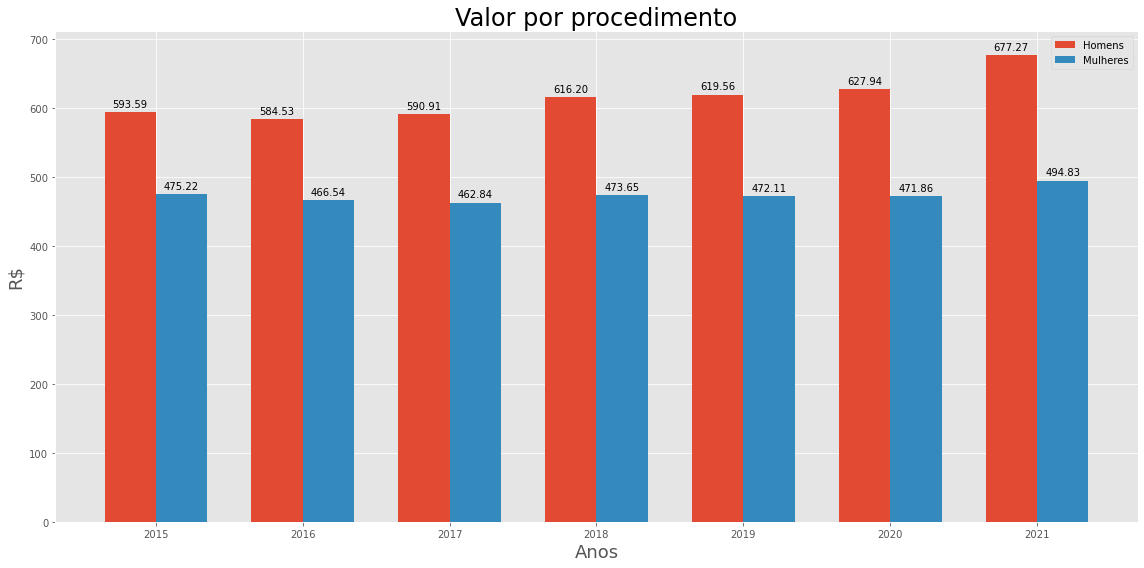

In [119]:
# Grafico do valor per proced
df_graph = df_per_proced.toPandas()
men = df_graph[df_graph.AP_SEXO == "M"].Per_Proced
women = df_graph[df_graph.AP_SEXO == "F"].Per_Proced

labels = df_graph.Year.unique()
x = np.arange(len(labels))
width= 0.35

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, men, width, label='Homens')
rects2 = ax.bar(x + width/2, women, width, label='Mulheres')

ax.set_ylabel('R$', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Valor por procedimento', fontdict={'fontsize': 24})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

**<h1>Mama</h1>**

In [47]:
# Filtrar o df apenas para tumore de mama
df_mama = df_full.filter(df_full.cid_orgao == 'Mama')
# Selecionar as colunas que vou trabalhar
df_mama = df_mama.select("AP_PRIPAL", "AQ_ESTADI", "cid_orgao", "MesAno", "Nome_UF", "AP_VL_AP", "Tratamento", "Year")

**<h3>Valor gasto no CID Mama</h3>**

In [44]:
# Calculando o valor da apac por mes e ordenando por mes
valor_total_mes_mama = df_mama.groupBy(["MesAno"]).agg(F.sum("AP_VL_AP").alias("Valor_Total"), F.mean("AP_VL_AP").alias("Media"))
valor_total_mes_mama = valor_total_mes_mama.withColumn('data', to_date("MesAno", 'MMyyyy')).sort('data')
valor_total_mes_mama.show()

+------+--------------------+------------------+----------+
|MesAno|         Valor_Total|             Media|      data|
+------+--------------------+------------------+----------+
|012015| 3.810410989999998E7| 323.1407410234229|2015-01-01|
|022015| 3.688648469999999E7|316.78533751288205|2015-02-01|
|032015| 3.951712204999998E7| 326.1134387172376|2015-03-01|
|042015|        3.80045558E7|322.18445222492556|2015-04-01|
|052015|3.8572219499999985E7|322.40236960882635|2015-05-01|
|062015| 3.853836889999998E7| 322.7939433788423|2015-06-01|
|072015| 3.857383984999999E7|324.46074264421367|2015-07-01|
|082015| 3.985327494999997E7|327.34771532534927|2015-08-01|
|092015| 3.980254214999999E7| 323.9086452857212|2015-09-01|
|102015| 3.935711720000002E7| 324.4502835850427|2015-10-01|
|112015| 3.907114360000002E7| 323.9434512606646|2015-11-01|
|122015|3.7957296249999985E7| 318.4203368147308|2015-12-01|
|012016| 3.864668354999999E7| 320.1534511610182|2016-01-01|
|022016| 3.853607204999998E7| 318.308941

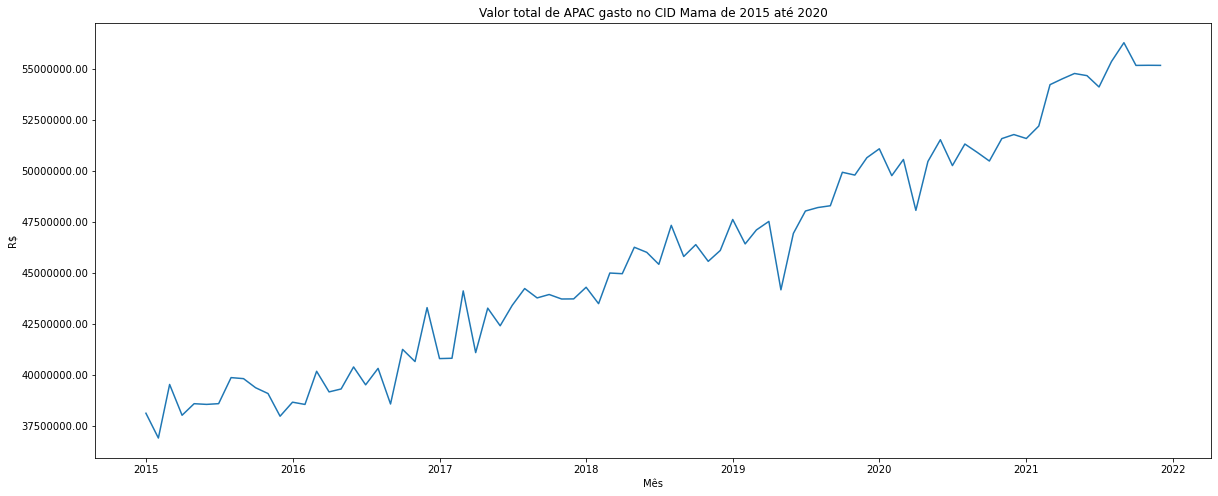

In [45]:
# Gráfico do valor APAC por mês no CID Mama
valor_total_mes_mama = valor_total_mes_mama.toPandas()
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(valor_total_mes_mama.data, valor_total_mes_mama.Valor_Total)
ax.set_ylabel('R$')
ax.set_xlabel("Mês")
ax.set_title("Valor total de APAC gasto no CID Mama de 2015 até 2020")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

**<h3>Valor gasto no CID Mama por estadiamento por ano</h3>**

In [49]:
# Calculando o valor da apac por mes e ordenando por mes
valor_total_mama_estad = df_mama.groupBy("Year", "Tratamento").agg(F.sum("AP_VL_AP").alias("Valor_Total"), F.mean("AP_VL_AP").alias("Media")).sort("Year")
valor_total_mama_estad.show()

+----+-----------+--------------------+------------------+
|Year| Tratamento|         Valor_Total|             Media|
+----+-----------+--------------------+------------------+
|2015|    inicial|      3.0643029225E8| 245.9170033914573|
|2015|metastatico|1.4281258995000017E8| 894.7316351846641|
|2015|    benigno|1.4995192649999997E7| 476.4916634890371|
|2016|metastatico|1.4658527655000022E8|  883.981067577674|
|2016|    benigno|1.4094681799999999E7| 484.5198281196287|
|2016|    inicial|      3.1902632205E8|246.22802233466652|
|2017|    inicial|3.4302686299999964E8|245.64417682704112|
|2017|metastatico|1.5590720925000012E8| 870.8245877877952|
|2017|    benigno|1.6267874349999998E7| 414.9862082599933|
|2018|    benigno|1.2841672399999997E7| 326.5772951528406|
|2018|metastatico| 1.690085053500002E8| 853.8629308254277|
|2018|    inicial|3.6470917290000015E8| 248.5508987679765|
|2019|    inicial| 3.787045392500003E8|247.39221501241866|
|2019|    benigno|       1.107662015E7| 270.524365612406

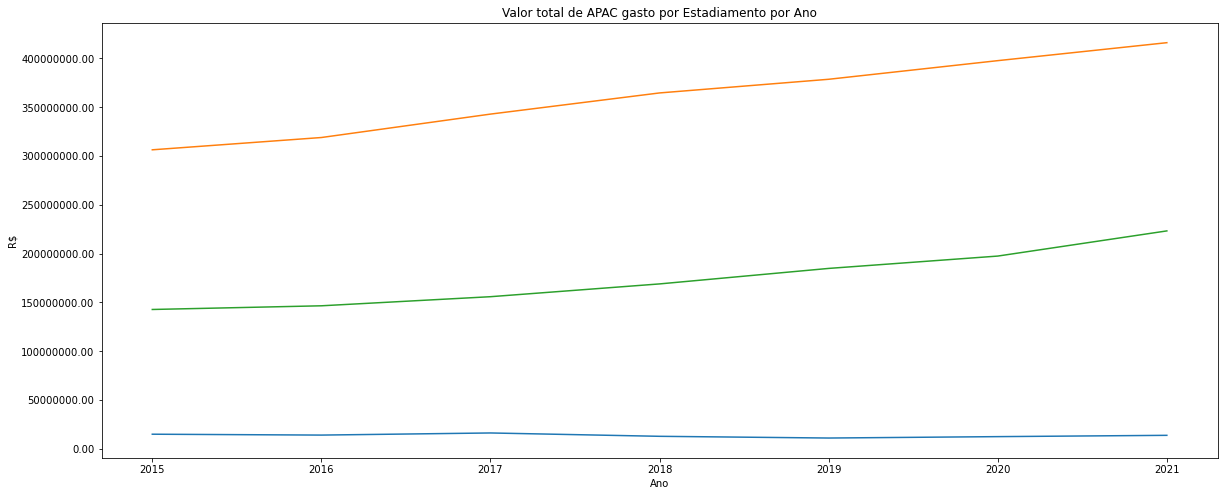

In [52]:
# Gráfico do valor APAC por mês no CID Mama
df_graph = valor_total_mama_estad.toPandas()

ben = df_graph[df_graph["Tratamento"] == "benigno"]
inicial = df_graph[df_graph["Tratamento"] == "inicial"]
meta = df_graph[df_graph["Tratamento"] == "metastatico"]

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(ben.Year, ben.Valor_Total)
ax.plot(inicial.Year, inicial.Valor_Total)
ax.plot(meta.Year, meta.Valor_Total)

ax.set_ylabel('R$')
ax.set_xlabel("Ano")
ax.set_title("Valor total de APAC gasto por Estadiamento por Ano")
              
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
              
plt.show()

**<h3>Número de procedimentos por CID Mama ano</h3>**

In [54]:
def inicial_metastatico(AQ_ESTADI):
    if AQ_ESTADI == '0':
        return 'benigno'
    elif AQ_ESTADI == '1' or AQ_ESTADI == '2' or AQ_ESTADI == '3': 
        return 'inicial'
    else:
        return 'metastatico'
    
cases_inic_meta = F.udf(inicial_metastatico, StringType())
df_final = df_final.withColumn("Tratamento", cases_inic_meta("AQ_ESTADI"))
df_final.show(5)

+--------------------+----------+----------+--------------------+-----------+----------+--------+---------+-----------+-----------+-----------+----------+-------+--------------------+--------+----------+--------------+------------------+-----------+---------+--------------------+-----------+--------------------+-----+-----+--------------------+------+-----------+-----------------+--------+----------------+---------+---------------+----+-----------+
|           AP_CNSPCN|  AP_DTFIM| AP_DTINIC|         AP_DTINIC_L|AP_DTINIC_N|AP_NUIDADE|AP_OBITO|AP_PRIPAL|AP_PRIPAL_C|AP_PRIPAL_N|AP_PRIPAL_S|AP_RACACOR|AP_SEXO|         AP_TPAPAC_L|AP_VL_AP|AP_VL_AP_C|    AP_VL_AP_L|        AP_VL_AP_S|AQ_DTIDEN_Y|AQ_ESTADI|         AQ_ESTADI_L|AQ_ESTADI_N|                 CID|CID_C|CID_N|               CID_S|MESANO|MESANO_LAST|          NOME_UF|N_PROCED|TEMPO_APAC_ATUAL|TEMPO_AUT|TEMP_APAC_TOTAL|Year| Tratamento|
+--------------------+----------+----------+--------------------+-----------+----------+------

Traceback (most recent call last):                                              
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 642, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 595, in read_int
    raise EOFError
EOFError


In [55]:
# Contagem de procedimentos apac realizados por ano no CID Mama
df_proced_mama = df_final.groupBy("Year", "Tratamento").count().sort("Year")
df_proced_mama.show()

+----+-----------+------+
|Year| Tratamento| count|
+----+-----------+------+
|2015|    inicial|257383|
|2015|    benigno| 17084|
|2015|metastatico|150493|
|2016|metastatico|153604|
|2016|    inicial|262522|
|2016|    benigno| 16743|
|2017|    inicial|275632|
|2017|    benigno| 18334|
|2017|metastatico|160549|
|2018|    inicial|285679|
|2018|metastatico|167816|
|2018|    benigno| 19010|
|2019|    inicial|301378|
|2019|metastatico|180620|
|2019|    benigno| 17600|
|2020|metastatico|186186|
|2020|    inicial|303622|
|2020|    benigno| 18188|
|2021|    inicial|308884|
|2021|metastatico|199044|
+----+-----------+------+
only showing top 20 rows



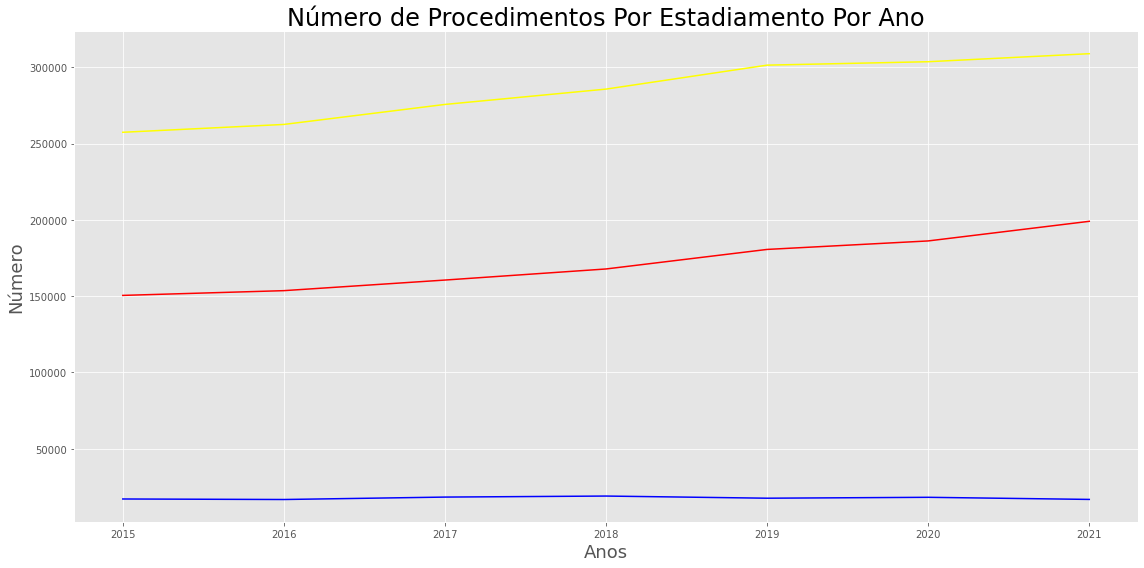

In [58]:
# Grafico da média de procedimentos por ano
df_graph = df_proced_mama.toPandas()
ben = df_graph[df_graph["Tratamento"] == "benigno"]
inicial = df_graph[df_graph["Tratamento"] == "inicial"]
meta = df_graph[df_graph["Tratamento"] == "metastatico"]

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16, 8))
anos = df_graph.Year.unique()

ax.plot(anos, ben["count"], color="blue")
ax.plot(anos, inicial["count"], color="yellow")
ax.plot(anos, meta["count"], color="red")

ax.set_ylabel('Número', fontdict={'fontsize': 18})
ax.set_xlabel("Anos", fontdict={"fontsize": 18})
ax.set_title('Número de Procedimentos Por Estadiamento Por Ano', fontdict={'fontsize': 24})

fig.tight_layout()

plt.show()

**<h3>Número de procedimentos no tratamento anti-HER2</h3>**

In [39]:
# Agrupando por estadiamento, procedimento e mes / ano e contanto as APAC pagas
df_proced = df_mama.groupBy(["AQ_ESTADI", "AP_PRIPAL", "MesAno"]).agg(F.count("AP_PRIPAL").alias("Contagem")).sort("MesAno", "AQ_ESTADI")
df_proced.show()

+---------+---------+------+--------+
|AQ_ESTADI|AP_PRIPAL|MesAno|Contagem|
+---------+---------+------+--------+
|        0|304050261|012015|       2|
|        0|304050067|012015|      33|
|        0|304040029|012015|     170|
|        0|304050130|012015|      16|
|        0|304050121|012015|     341|
|        0|304050296|012015|      10|
|        0|304050270|012015|       9|
|        0|304050288|012015|       3|
|        0|304050113|012015|     186|
|        0|304040185|012015|       3|
|        0|304050318|012015|      19|
|        0|304020141|012015|     159|
|        0|304050300|012015|      11|
|        0|304020346|012015|     387|
|        0|304020133|012015|     124|
|        0|304020338|012015|     491|
|        0|304050075|012015|      57|
|        0|304050040|012015|     499|
|        1|304020338|012015|    1231|
|        1|304040029|012015|      97|
+---------+---------+------+--------+
only showing top 20 rows



In [40]:
# Filtrar df_mama com os procedimentos para her2
# 03.04.02.041-9 - 03.04.02.042-7 - 03.04.02.043-5 - 03.04.02.044-3 - 03.04.04.018-5 - 03.04.05.026-1 - 03.04.05.027-0 - 03.04.05.028-8 - 03.04.05.029-6 - 	03.04.05.030-0 -03.04.05.031-8
df_her = df_mama.filter((df_mama.AP_PRIPAL == 304020419) | (df_mama.AP_PRIPAL == 304020427) | (df_mama.AP_PRIPAL == 304020435) | (df_mama.AP_PRIPAL == 304020443) | (df_mama.AP_PRIPAL == 304040185) | (df_mama.AP_PRIPAL == 304050261) |
                        (df_mama.AP_PRIPAL == 304050270) | (df_mama.AP_PRIPAL == 304050288) | (df_mama.AP_PRIPAL == 304050296) | (df_mama.AP_PRIPAL == 304050300) | (df_mama.AP_PRIPAL == 304050318))
df_her_result = df_her.groupBy(["AP_PRIPAL", "MesAno"]).count().alias("Contagem").sort("MesAno")
# df_her_result = df_her_result.withColumn('MesAno', to_date("MesAno", 'MMyyyy')).sort('MesAno')
df_her_result.show()

+---------+----------+-----+
|AP_PRIPAL|    MesAno|count|
+---------+----------+-----+
|304050300|2015-01-01|  932|
|304050318|2015-01-01| 1278|
|304050270|2015-01-01|  375|
|304050288|2015-01-01|  307|
|304040185|2015-01-01|  413|
|304050261|2015-01-01|  121|
|304050296|2015-01-01|  321|
|304050261|2015-02-01|  123|
|304050296|2015-02-01|  314|
|304040185|2015-02-01|  393|
|304050300|2015-02-01|  974|
|304050270|2015-02-01|  379|
|304050288|2015-02-01|  286|
|304050318|2015-02-01| 1248|
|304050300|2015-03-01| 1068|
|304050270|2015-03-01|  395|
|304050296|2015-03-01|  342|
|304040185|2015-03-01|  638|
|304050261|2015-03-01|  149|
|304050288|2015-03-01|  311|
+---------+----------+-----+
only showing top 20 rows



In [41]:
# Transformar os procedimentos individuais
teste1 = df_her_result.filter(df_her_result.AP_PRIPAL == 304020419).toPandas()
teste2 = df_her_result.filter(df_her_result.AP_PRIPAL == 304020427).toPandas()
teste3 = df_her_result.filter(df_her_result.AP_PRIPAL == 304020435).toPandas()
teste4 = df_her_result.filter(df_her_result.AP_PRIPAL == 304020443).toPandas()
teste5 = df_her_result.filter(df_her_result.AP_PRIPAL == 304040185).toPandas()
teste6 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050261).toPandas()
teste7 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050270).toPandas()
teste8 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050288).toPandas()
teste9 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050296).toPandas()
teste10 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050300).toPandas()
teste11 = df_her_result.filter(df_her_result.AP_PRIPAL == 304050318).toPandas()

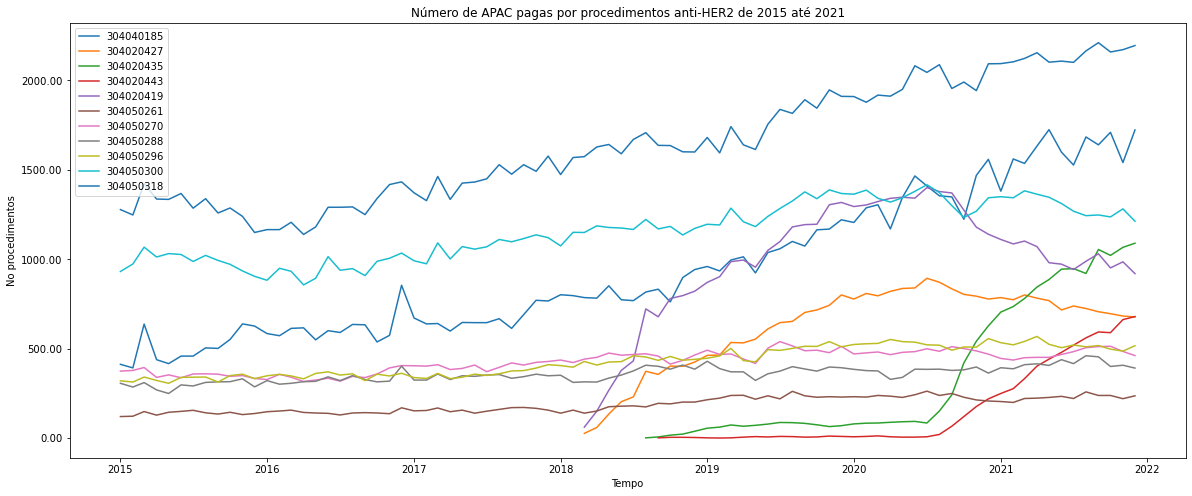

In [42]:
# Gráfico do número de procedimentos anti-her2 por mês
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(teste5["MesAno"], teste5["count"], label = "304040185")
ax.plot(teste2["MesAno"], teste2["count"], label = "304020427")
ax.plot(teste3["MesAno"], teste3["count"], label = "304020435")
ax.plot(teste4["MesAno"], teste4["count"], label = "304020443")
ax.plot(teste1["MesAno"], teste1["count"], label = "304020419")
ax.plot(teste6["MesAno"], teste6["count"], label = "304050261")
ax.plot(teste7["MesAno"], teste7["count"], label = "304050270")
ax.plot(teste8["MesAno"], teste8["count"], label = "304050288")
ax.plot(teste9["MesAno"], teste9["count"], label = "304050296")
ax.plot(teste10["MesAno"], teste10["count"], label = "304050300")
ax.plot(teste11["MesAno"], teste11["count"], label = "304050318")
ax.set_ylabel('No procedimentos')
ax.set_xlabel("Tempo")
ax.set_title("Número de APAC pagas por procedimentos anti-HER2 de 2015 até 2021")
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend()
plt.show()

In [ ]:
# Tabela dos códigos dos procedimentos e do significado
proced = ["03.04.02.041-9", "03.04.02.042-7", "03.04.02.043-5", "03.04.02.044-3", "03.04.04.018-5", "03.04.05.026-1", "03.04.05.027-0", "03.04.05.028-8", "03.04.05.029-6", "03.04.05.030-0", "03.04.05.031-8"]
descri = ["POLIQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO – 1ª LINHA",
          "MONOQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO – 1ª LINHA",
          "POLIQUIMIOTERAPIA COM DUPLO ANTI HER-2 DO CARCINOMA DE MAMA HER-2 POSITIVO 1ª LINHA",
          "QUIMIOTERAPIA COM DUPLO ANTI-HER-2 DO CARCINOMA DE MAMA HER-2 POSITIVO – 1ª LINHA",	
	      "POLIQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO III (PRÉVIA)",	
	      "POLIQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO I (ADJUVANTE)",	
	      "POLIQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO II (ADJUVANTE)",	
	      "POLIQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO III (ADJUVANTE)",	
	      "MONOQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO I (ADJUVANTE)",	
	      "MONOQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO II (ADJUVANTE)",
          "MONOQUIMIOTERAPIA DO CARCINOMA DE MAMA HER-2 POSITIVO EM ESTÁDIO III (ADJUVANTE)"]

plot_data = [go.Table(header=dict(values=["Procedimento", "Descrição"],
            font=dict(size=18),
            align="left"),
        cells=dict(
            values=[proced, descri],
            align = "center", font = dict(size=14))),]

plot_layout = go.Layout(height=780, width=1000, showlegend=False, title_text="Número de procedimentos de 2015 até 2021")

fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)

**<h1>Resultado do valor total APAC e número de pacientes por mes em CA MAMA</h1>**

**Tabela de procedimentos da APAC**

In [ ]:
# Importar tabela de procedimentos APAC com descrição
proced = spark.read.csv("hdfs://192.168.0.17:9000/user/hadoop/siasus2/procedimentos.csv", sep=",", inferSchema=True, header=True)
proced.show()

In [ ]:
# Contagem do numero de procedimentos
df_proced = df_mama.groupBy(["AP_PRIPAL"]).count().sort(F.desc("count"))
df_proced.show()

In [ ]:
df_proced = df_proced.join(proced, df_proced.AP_PRIPAL == proced.CODIGO, 'left').sort(F.desc("count"))
df_proced.show()

In [ ]:
plot_data = [go.Table(header=dict(values=["Codigo procedimentos APAC", "Descrição procedimentos", "Contagem"],
            font=dict(size=18),
            align="left"),
        cells=dict(
            values=[df_proced.toPandas()["AP_PRIPAL"], df_proced.toPandas()["DESCRICAO"], df_proced.toPandas()["count"]],
            align = "center", font = dict(size=14))),]

plot_layout = go.Layout(height=1600, width=1000, showlegend=False, title_text="Número de procedimentos totais de 2015 até 2020")

fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)